# HighRes vs. ERA5 - NASST events and European heat waves

### 1. Load modules

In [1]:
import numpy as np
#import numpy.matlib 
#import math
from scipy import signal
import xarray as xr
#from scipy.stats import gaussian_kde, ttest_ind
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.markers import MarkerStyle
#import matplotlib.rasterize_and_save as raster
import cartopy
import cartopy.crs as ccrs
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta, MO
import datetime
#import matplotlib.animation as animation
from matplotlib import rc
from dask.distributed import Client, LocalCluster
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import os
import glob
from tqdm import tqdm
import warnings

In [2]:
# set up cluster
cluster = LocalCluster(n_workers=4, threads_per_worker=4)
client = Client(cluster)
client

<Client: 'tcp://127.0.0.1:44887' processes=4 threads=16, memory=235.37 GiB>

## Lead lag analysis plots: Define functions for ..
* Lat Lon Maps
* Box averages - Line plots

In [11]:
def lead_lag(var, cold_events, rm_value):
    # Detrend data set by replacing nans by zeros beforehand
    var_null = var.squeeze().fillna(0)
    var_detrend = signal.detrend(var_null, axis=0)
    # Produce xarray Data Array
    var_detrend_xr =  xr.DataArray(data=var_detrend, dims=["time", "lat","lon"], coords=dict(time = var.time,lat= var.lat, lon=var.lon)) 
    # Deseasonalize
    var_anom = var_detrend_xr.groupby("time.dayofyear") - (var_detrend_xr.groupby("time.dayofyear").mean("time", skipna=True) - var_detrend_xr.mean('time', skipna=True))
    #### Lead lag analysis without any mean
    lags = [str(int(n)) for n in np.linspace(-60,60,121)]
    var_10_lags=[]
    for i in range(0,len(lags)):
        var_10_lags.append(var_anom.where(var_anom.time ==((cold_events.time + pd.Timedelta(lags[i]+" days")).assign_coords(time=cold_events.time + pd.Timedelta(lags[i]+" days")))))
        var_10_lags[i].coords['lead_lag'] = int(lags[i])
        
    var_10_lags_set = xr.DataArray(np.stack(var_10_lags, axis=0),dims=["lead_lag", "time", "lat","lon"],coords=dict(lead_lag= [int(n) for n in np.linspace(-60,60,121)], time=var_10_lags[60].time,lat= var_10_lags[0].lat,lon= var_10_lags[0].lon)).rolling(lead_lag=rm_value, center=True).mean(skipna=True).dropna("lead_lag")
    
    var_lags_set= [var_10_lags_set.where(var_10_lags_set !=0)] # Replace back zeros by nans
    #print(var_lags_set[0].shape)    
    return(var_lags_set)

composite_type_number=1

def maps(var_lags_set):
    # time mean -> maps
    var_lags_map= [var_lags_set[i].mean('time') for i in range(0,composite_type_number)]
    return (var_lags_map)
    
def lines(var_lags_set):    
    weights = np.cos(np.deg2rad(var_lags_set[0].lat)) 
    # lon & lat means -> line plots
    var_lags_Atl_line= [var_lags_set[i].sel(lon=slice(320.0, 345.0), lat=slice(60.0,45.0)).weighted(weights).mean('lon', skipna=True).mean('lat', skipna=True).mean('time') for i in range(0,composite_type_number)]
    var_lags_Euro_line= [var_lags_set[i].sel(lon=slice(0.0, 20.0), lat=slice(52.5,45.0)).weighted(weights).mean('lon', skipna=True).mean('lat', skipna=True).mean('time') for i in range(0,composite_type_number)]
    # without time mean -> Box average line plots in terms of probability
    var_lags_Atl_line_wtm= [var_lags_set[i].sel(lon=slice(320.0, 345.0), lat=slice(60.0,45.0)).weighted(weights).mean('lon').mean('lat') for i in range(0,composite_type_number)]
    var_lags_Euro_line_wtm= [var_lags_set[i].sel(lon=slice(0.0, 20.0), lat=slice(52.5,45.0)).weighted(weights).mean('lon', skipna=True).mean('lat', skipna=True) for i in range(0,composite_type_number)]

    return(var_lags_Atl_line, var_lags_Euro_line, var_lags_Atl_line_wtm, var_lags_Euro_line_wtm)#, var_lags_Atl_line_welch,var_lags_Euro_line_welch)


In [12]:

#%store -r HighRes_model_tos_ds_Atl_dt_JJA_lag0_10_concat
#HighRes_model_tos_ds_Atl_dt_JJA_lag0_10_concat
#HighRes_model_tos_ds_Atl_dt_JJA_lag0_10_concat

In [13]:
# Warnung "Mean of empty slice" unterdrücken
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Mean of empty slice")

# Set model, variables, resolutions
model_name =['ERA5_','HadGEM3-GC31_','CNRM-CM6_','EC-Earth3P_','ECMWF-IFS_','CMCC-CM2_', 'MPI-ESM1-2_','FOCI_']
ERA5_variable = ['sea_surface_temperature','t2m','z300','precipitation_total','surface_latent_heat_flux']
FOCI_variable = ['tsw', 'temp2','geopoth_pl_300hPa','precip','ahfl']
variable = ['tos_', 'tas_','zg_','pr_','hfls_']
resolution = [[''],
              ['-LL', '-MM', '-HH'],
              ['-1' , '-1-HR'],
              ['', '-HR'],
              ['-LR', '-MR','-HR'],
              ['-HR4','-VHR4'],
              ['-HR', '-XR','-ER', '-HR-PP'],
              ['-Standard' ,'-VIKING10']]

In [15]:
HighRes_model_tos_ds_Atl_dt_JJA_lag0_10_concat = {}                                             ### Used for step 7 
HighRes_model_map = {}                                                                             ### Used for step 8
HighRes_model_Atl_line = {}                                                                        ### Used for step 8
HighRes_model_Euro_line = {}                                                                       ### Used for step 8
HighRes_model_Atl_line_wtm = {}                                                                   ### Used for step 8
HighRes_model_Euro_line_wtm = {}                                                                   ## Used for step 8
quantiles = {} 
for mod in range(len(model_name)):
    HighRes_model={}
    print(model_name[mod][:-1])
    ##### Load data sets #####
    for var in range(len(variable)):
            for res in range(len(resolution[mod])):
                if mod==0:
                    #Input of ERA5  
                    directory='/work/bm1398/m301111/Reanalysis/ERA5/daily/ERA5__'; file_end= '__1979-2019.nc'
                    HighRes_model['ERA5_'+variable[var]]=xr.open_dataset(directory+ERA5_variable[var]+'__1979-2019.nc')
                    
                if mod>0 and mod<7:
                    #Input of HighResMIP models
                    directory ='/work/bm1398/m301111/Models/HighResMIP/'+model_name[mod][:-1]+'/'+variable[var][:-1]+'/'+variable[var]+'daily/'+variable[var]+'day_'+model_name[mod][:-1]; #file_end='_control-1950_r1i1p1f1_gn_19500101-20501231_2_5_deg_06_00_shifted_inverted.nc'
                    file=glob.glob(directory+resolution[mod][res]+'_control*.nc')
                    HighRes_model[model_name[mod]+variable[var]+resolution[mod][res]] = xr.open_dataset(file[0])  
                    
                if mod==7:
                    #Input of FOCI
                    period ='1950-2049'
                    path =     '/work/bm1398/m301111/Models/FOCI/FOCI1.10-TM020_preind_no_nest/'+period+'/'
                    path_nest= '/work/bm1398/m301111/Models/FOCI/FOCI1.10-TM026_preind_VIKING10_nest/'+period+'/'
                    if res==0:
                        FOCI_file       = path+'FOCI1.10-TM020_echam6_echam_'+period+'_'+FOCI_variable[var]+'.nc'
                    if res==1:
                        FOCI_file   = path_nest+'FOCI1.10-TM026_echam6_echam_'+period+'_'+FOCI_variable[var]+'.nc'
                    HighRes_model[model_name[mod]+variable[var]+resolution[mod][res]] = xr.open_dataset(FOCI_file)  


                    #### line for MPI-ESM-ER only, use the same time corrdinate for tas as used for tos        
                    #HighRes_model[model_name+'tas_'+resolution[2]]['time'] = HighRes_model[model_name+'tos_'+resolution[2]]['time']
                    
##### Deseasonalize SST, calculate NA average, detrend, select JJA values #####
    HighRes_model_tos_ds = {}                                                                       ### Used for step 1
    HighRes_model_tos_ds_Atl = {}                                                                   ### Used for step 2
    weights = np.cos(np.deg2rad(HighRes_model[model_name[mod]+variable[0]+resolution[mod][0]].lat)) ### Used for step 2
    HighRes_model_tos_ds_Atl_dt = {}                                                                ### Used for step 3
    HighRes_model_tos_ds_Atl_dt_JJA = {}                                                            ### Used for step 4
    HighRes_model_tos_ds_Atl_dt_JJA_mean = {}                                                       ### Used for step 5
    
    for res in range(len(resolution[mod])):
        #print(mod)
        if mod==0:   # 1. Deseasonalize - ERA5
            A=xr.DataArray(np.full((92), 1979)) ### Used for step 5
            HighRes_model_tos_ds [model_name[mod]+variable[0]+'_ds'] = HighRes_model[model_name[mod]+variable[0]].var34.groupby("time.dayofyear") - (HighRes_model[model_name[mod]+variable[0]].var34.groupby("time.dayofyear").mean("time") - HighRes_model[model_name[mod]+variable[0]].var34.mean('time')) 
        elif mod==1: # 1. Deseasonalize - HadGEM
            A=xr.DataArray(np.full((90), 1950)) ### Used for step 5
            HighRes_model_tos_ds [model_name[mod]+variable[0]+resolution[mod][res]+'_ds'] = HighRes_model[model_name[mod]+variable[0]+resolution[mod][res]].tos.groupby("time.dayofyear") - (HighRes_model[model_name[mod]+variable[0]+resolution[mod][res]].tos.groupby("time.dayofyear").mean("time") - HighRes_model[model_name[mod]+variable[0]+resolution[mod][res]].tos.mean('time')) 
        elif mod>1 and mod<7:  # 1. Deseasonalize - remaining HighResMIP models
            A=xr.DataArray(np.full((92), 1950)) ### Used for step 5
            HighRes_model_tos_ds [model_name[mod]+variable[0]+resolution[mod][res]+'_ds'] = HighRes_model[model_name[mod]+variable[0]+resolution[mod][res]].tos.groupby("time.dayofyear") - (HighRes_model[model_name[mod]+variable[0]+resolution[mod][res]].tos.groupby("time.dayofyear").mean("time") - HighRes_model[model_name[mod]+variable[0]+resolution[mod][res]].tos.mean('time')) 
        elif mod==7: # 1. Deseasonalize FOCI
            A=xr.DataArray(np.full((92), 1979)) ### Used for step 5
            HighRes_model_tos_ds [model_name[mod]+variable[0]+resolution[mod][res]+'_ds'] = HighRes_model[model_name[mod]+variable[0]+resolution[mod][res]].tsw.groupby("time.dayofyear") - (HighRes_model[model_name[mod]+variable[0]+resolution[mod][res]].tsw.groupby("time.dayofyear").mean("time") - HighRes_model[model_name[mod]+variable[0]+resolution[mod][res]].tsw.mean('time')) 
        
        # 2. Calc NA SST average
        HighRes_model_tos_ds_Atl [model_name[mod]+variable[0]+resolution[mod][res]+'_ds_Atl'] = HighRes_model_tos_ds[model_name[mod]+variable[0]+resolution[mod][res]+'_ds'].sel(lon=slice(320.0, 345.0), lat=slice(60.0, 45.0)).weighted(weights).mean('lon', skipna=True).mean('lat', skipna=True)
        # 3. Detrend
        HighRes_model_tos_ds_Atl_dt [model_name[mod]+variable[0]+resolution[mod][res]+'_ds_Atl_dt'] = xr.DataArray(data=(signal.detrend(HighRes_model_tos_ds_Atl [model_name[mod]+variable[0]+resolution[mod][res]+'_ds_Atl'].squeeze(), axis=0)), dims=["time"], coords=dict(time=HighRes_model_tos_ds_Atl [model_name[mod]+variable[0]+resolution[mod][res]+'_ds_Atl'].time))
        # 4. Select JJA values
        HighRes_model_tos_ds_Atl_dt_JJA [model_name[mod]+variable[0]+resolution[mod][res]+'_ds_Atl_dt_JJA'] = HighRes_model_tos_ds_Atl_dt [model_name[mod]+variable[0]+resolution[mod][res]+'_ds_Atl_dt'].sel(time=HighRes_model_tos_ds_Atl_dt [model_name[mod]+variable[0]+resolution[mod][res]+'_ds_Atl_dt']['time.season']==['JJA'])
        HighRes_model_tos_ds_Atl_dt_JJA_mean [model_name[mod]+variable[0]+resolution[mod][res]+'_ds_Atl_dt_JJA_mean'] = HighRes_model_tos_ds_Atl_dt_JJA [model_name[mod]+variable[0]+resolution[mod][res]+'_ds_Atl_dt_JJA'].resample(time="QS-DEC").mean().dropna(dim='time')
        # 5. Add coordinate 'Year' to the data set 
        years=[]
        for i in range(len(HighRes_model_tos_ds_Atl_dt_JJA_mean [model_name[mod]+variable[0]+resolution[mod][res]+'_ds_Atl_dt_JJA_mean'] )):
            years.append(A)
            A=A+1
        years_array = xr.concat(years, dim='dim_0')
        HighRes_model_tos_ds_Atl_dt_JJA [model_name[mod]+variable[0]+resolution[mod][res]+'_ds_Atl_dt_JJA'] = HighRes_model_tos_ds_Atl_dt_JJA [model_name[mod]+variable[0]+resolution[mod][res]+'_ds_Atl_dt_JJA'].assign_coords(year=('time',years_array.data))        
        # 6. Calc quantiles 
        quantiles['quantile_10_'+model_name[mod]+resolution[mod][res]] =  HighRes_model_tos_ds_Atl_dt_JJA [model_name[mod]+variable[0]+resolution[mod][res]+'_ds_Atl_dt_JJA'].quantile(0.1, dim='time')
            

        ##### 7. Select the data #####
        
        HighRes_model_tos_ds_Atl_dt_JJA_lag0_10= []
        td = [pd.Timedelta("30 days"), datetime.timedelta(days=30), pd.Timedelta("30 days"), pd.Timedelta("30 days"), pd.Timedelta("30 days"), datetime.timedelta(days=30), pd.Timedelta("30 days"),pd.Timedelta("30 days")]

        for i in range(len(HighRes_model_tos_ds_Atl_dt_JJA [model_name[mod]+variable[0]+resolution[mod][res]+'_ds_Atl_dt_JJA'])-2):
            j=np.array([i,i+1,i+2])
            if np.all(HighRes_model_tos_ds_Atl_dt_JJA [model_name[mod]+variable[0]+resolution[mod][res]+'_ds_Atl_dt_JJA'][j] < quantiles['quantile_10_'+model_name[mod]+resolution[mod][res]]) and HighRes_model_tos_ds_Atl_dt_JJA [model_name[mod]+variable[0]+resolution[mod][res]+'_ds_Atl_dt_JJA'][i-1] > quantiles['quantile_10_'+model_name[mod]+resolution[mod][res]] and HighRes_model_tos_ds_Atl_dt_JJA [model_name[mod]+variable[0]+resolution[mod][res]+'_ds_Atl_dt_JJA'][i-1].time.year == HighRes_model_tos_ds_Atl_dt_JJA [model_name[mod]+variable[0]+resolution[mod][res]+'_ds_Atl_dt_JJA'][i].time.year and HighRes_model_tos_ds_Atl_dt_JJA [model_name[mod]+variable[0]+resolution[mod][res]+'_ds_Atl_dt_JJA'][i+2].time.year == HighRes_model_tos_ds_Atl_dt_JJA [model_name[mod]+variable[0]+resolution[mod][res]+'_ds_Atl_dt_JJA'][i].time.year: 
                if HighRes_model_tos_ds_Atl_dt_JJA_lag0_10 == []:  
                    HighRes_model_tos_ds_Atl_dt_JJA_lag0_10.append(HighRes_model_tos_ds_Atl_dt_JJA [model_name[mod]+variable[0]+resolution[mod][res]+'_ds_Atl_dt_JJA'][i])
                elif HighRes_model_tos_ds_Atl_dt_JJA_lag0_10[-1].time < (HighRes_model_tos_ds_Atl_dt_JJA [model_name[mod]+variable[0]+resolution[mod][res]+'_ds_Atl_dt_JJA'][i].time - td[mod]):
                    HighRes_model_tos_ds_Atl_dt_JJA_lag0_10.append(HighRes_model_tos_ds_Atl_dt_JJA [model_name[mod]+variable[0]+resolution[mod][res]+'_ds_Atl_dt_JJA'][i])

        HighRes_model_tos_ds_Atl_dt_JJA_lag0_10_concat [model_name[mod]+variable[0]+resolution[mod][res]+'_ds_Atl_dt_JJA_lag0_10'] = xr.concat(HighRes_model_tos_ds_Atl_dt_JJA_lag0_10, dim='time')
    
    ##### 8. Use functions for different parameters #####

    run_mean = 5  # <- set days for running mean !!!
    HighRes_model_set = {}

    var_name = [['var34', 'var167','z','var228','var147'],['tos', 'tas','zg23','pr','hfls'],['tos', 'tas','zg10','pr','hfls'] ,['tos', 'tas','zg','pr','hfls'] ,['tos', 'tas','zg','pr','hfls'] ,['tos', 'tas','zg','pr','hfls'],['tos', 'tas','zg','pr','hfls'],['tsw', 'temp2','geopoth','precip','ahfl']]# 'slp_','precip_', 'ahfl_', 'ahfs_']
    unit_factor= [[1,1, (1/9.81), (1000*24), (-1)], # ERA5
                  [1,1, 1,        (3600*24), (-1)],     # HadGEM
                  [1,1, 1,        (3600*24), (-1)],     # CNRM
                  [1,1, 1,        (3600*24), (-1)],     # EC-Earth
                  [1,1, 1,        (3600*24), (-1)],     # ECMWF-IFS
                  [1,1, 1,        (3600*24), (-1)],     # CMCC
                  [1,1, 1,        (3600*24), (-1)],     # MPI-ESM
                  [1,1, 1,        (3600*24), (-1)],        # FOCI
                 ] # 1. °C; 2. either SLP from Pa to hPa or GPh from m^2/s^2 to gpm; 3. # <- convert from m/s to mm/day; 4./5. convert from J/m^2 to W/m^2 (60 sec x 60 mins = 3600s)

    for var in tqdm(range(len(variable))):
        for res in range(len(resolution[mod])):
            if mod==6 and res>1: # change time axis from float to datetime in MPI-ESM by overwriting time dimension in ER with ER tos time dim
                HighRes_model[model_name[mod]+variable[var]+resolution[mod][res]]['time'] = HighRes_model[model_name[mod]+variable[0]+resolution[mod][res]]['time']
                   
            HighRes_model_set[model_name [mod]+ variable[var]+ resolution[mod][res]+'_set']  = lead_lag(HighRes_model[model_name[mod]+variable[var]+resolution[mod][res]][var_name [mod][var]]*unit_factor[mod][var],
                                                                                                            HighRes_model_tos_ds_Atl_dt_JJA_lag0_10_concat [model_name[mod]+variable[0]+resolution[mod][res]+'_ds_Atl_dt_JJA_lag0_10'],run_mean)                                                                                                        
                                                                                                                 
            HighRes_model_map[model_name [mod]+ variable[var]+ resolution[mod][res]+'_map'] = maps(HighRes_model_set[model_name [mod]+ variable[var]+ resolution[mod][res]+'_set']) # <- set thresholds for probability selection
            #HighRes_model_Atl_line[model_name [mod]+ variable[var]+ resolution[mod][res]+'_Atl_line'], HighRes_model_Euro_line[model_name [mod]+ variable[var]+ resolution[mod][res]+'Euro_line'] = lines(HighRes_model_set[model_name [mod]+ variable[var]+ resolution[mod][res]+'_set'])            
            HighRes_model_Atl_line[model_name [mod]+ variable[var]+ resolution[mod][res]+'_Atl_line'], HighRes_model_Euro_line[model_name [mod]+ variable[var]+ resolution[mod][res]+'Euro_line'], HighRes_model_Atl_line_wtm[model_name [mod]+ variable[var]+ resolution[mod][res]+'Atl_line_wtm'], HighRes_model_Euro_line_wtm[model_name [mod]+ variable[var]+ resolution[mod][res]+'Euro_line_wtm'] = lines(HighRes_model_set[model_name [mod]+ variable[var]+ resolution[mod][res]+'_set'])
            #HighRes_model_Euro_line_wtm [model_name [mod]+ variable[var]+ resolution[mod][res]+'Euro_line_wtm'] = lines(HighRes_model_set[model_name [mod]+ variable[var]+ resolution[mod][res]+'_set'])

ERA5


100%|██████████| 5/5 [00:30<00:00,  6.12s/it]


HadGEM3-GC31


100%|██████████| 5/5 [10:55<00:00, 131.18s/it]


CNRM-CM6


100%|██████████| 5/5 [02:31<00:00, 30.21s/it]


EC-Earth3P


100%|██████████| 5/5 [19:48<00:00, 237.72s/it]


ECMWF-IFS


100%|██████████| 5/5 [06:42<00:00, 80.51s/it] 


CMCC-CM2


100%|██████████| 5/5 [06:35<00:00, 79.00s/it] 


MPI-ESM1-2


100%|██████████| 5/5 [05:30<00:00, 66.07s/it]


FOCI


100%|██████████| 5/5 [02:38<00:00, 31.69s/it]


In [27]:
#print(HighRes_model.keys())
path_base='/work/bm1398/m301111/Models/HighResMIP/'
#### Load bootstrap data sets for significance
bootstrap_mean_quant_Atl_025 = xr.open_dataset(path_base+'HighResMIP_composite_bootstrapping_quantiles/High_ResMIP_composite_bootstrap_mean_quant_Atl_025.nc') 
bootstrap_mean_quant_Atl_975 = xr.open_dataset(path_base+'HighResMIP_composite_bootstrapping_quantiles/High_ResMIP_composite_bootstrap_mean_quant_Atl_975.nc') 
bootstrap_mean_quant_Euro_975 = xr.open_dataset(path_base+'HighResMIP_composite_bootstrapping_quantiles/High_ResMIP_composite_bootstrap_mean_quant_Euro_975.nc') 
bootstrap_mean_quant_MPI_Atl_025 = xr.open_dataset(path_base+'HighResMIP_composite_bootstrapping_quantiles/MPI-ESM_composite_bootstrap_mean_quant_Atl_025.nc') 
bootstrap_mean_quant_MPI_Atl_975 = xr.open_dataset(path_base+'HighResMIP_composite_bootstrapping_quantiles/MPI-ESM_composite_bootstrap_mean_quant_Atl_975.nc') 
bootstrap_mean_quant_MPI_Euro_975 = xr.open_dataset(path_base+'HighResMIP_composite_bootstrapping_quantiles/MPI-ESM_composite_bootstrap_mean_quant_Euro_975.nc') 

bootstrap_mean_quant_025_map_SLHF_lag0 = xr.open_dataset(path_base+'HighResMIP_composite_bootstrapping_quantiles/boots_mean_quant_025_map_lag0_SLHF.nc') 
bootstrap_mean_quant_975_map_SLHF_lag0 = xr.open_dataset(path_base+'HighResMIP_composite_bootstrapping_quantiles/boots_mean_quant_975_map_lag0_SLHF.nc') 

bootstrap_mean_quant_025_map_pr_lag0 = xr.open_dataset(path_base+'HighResMIP_composite_bootstrapping_quantiles/boots_mean_quant_025_map_lag0_pr.nc') 
bootstrap_mean_quant_975_map_pr_lag0 = xr.open_dataset(path_base+'HighResMIP_composite_bootstrapping_quantiles/boots_mean_quant_975_map_lag0_pr.nc') 

bootstrap_mean_quant_025_map_Z300_lag5 = xr.open_dataset(path_base+'HighResMIP_composite_bootstrapping_quantiles/boots_mean_quant_025_map_lag5_z300.nc') 
bootstrap_mean_quant_975_map_Z300_lag5 = xr.open_dataset(path_base+'HighResMIP_composite_bootstrapping_quantiles/boots_mean_quant_975_map_lag5_z300.nc') 

bootstrap_mean_quant_025_map_SST_T2m_lag5 = xr.open_dataset(path_base+'HighResMIP_composite_bootstrapping_quantiles/boots_mean_quant_025_map_lag5_SST_T2m.nc') 
bootstrap_mean_quant_975_map_SST_T2m_lag5 = xr.open_dataset(path_base+'HighResMIP_composite_bootstrapping_quantiles/boots_mean_quant_975_map_lag5_SST_T2m.nc') 

In [28]:
### Significance with bootstrap composite means averaged over Atlantic or European region for Fig. 4c,d
## SLHF - Atl - lag 0
bootstrap_mean_quant_025_map_SLHF_lag0_Atl = bootstrap_mean_quant_025_map_SLHF_lag0.sel(lon=slice(320.0, 345.0), lat=slice(60.0, 45.0)).weighted(weights).mean('lon').mean('lat').squeeze()
bootstrap_mean_quant_975_map_SLHF_lag0_Atl = bootstrap_mean_quant_975_map_SLHF_lag0.sel(lon=slice(320.0, 345.0), lat=slice(60.0, 45.0)).weighted(weights).mean('lon').mean('lat').squeeze()

## pr - Atl - lag0
bootstrap_mean_quant_025_map_pr_lag0_Atl = bootstrap_mean_quant_025_map_pr_lag0.sel(lon=slice(320.0, 345.0), lat=slice(60.0, 45.0)).weighted(weights).mean('lon').mean('lat').squeeze()
bootstrap_mean_quant_975_map_pr_lag0_Atl = bootstrap_mean_quant_975_map_pr_lag0.sel(lon=slice(320.0, 345.0), lat=slice(60.0, 45.0)).weighted(weights).mean('lon').mean('lat').squeeze()

## Z300 - Euro - lag5
bootstrap_mean_quant_025_map_Z300_lag5_Atl = bootstrap_mean_quant_025_map_Z300_lag5.sel(lon=slice(0.0, 20.0), lat=slice(52.5, 45.0)).weighted(weights).mean('lon').mean('lat').squeeze()
bootstrap_mean_quant_975_map_Z300_lag5_Atl = bootstrap_mean_quant_975_map_Z300_lag5.sel(lon=slice(0.0, 20.0), lat=slice(52.5, 45.0)).weighted(weights).mean('lon').mean('lat').squeeze()


## 6. Multi-model mean 

In [18]:
#%store HighRes_model_tos_ds_Atl_dt_JJA_lag0_10_concat
#%store quantiles
#%store HighRes_model
%store HighRes_model_Atl_line
%store HighRes_model_Euro_line_wtm
%store HighRes_model_map
#%store -r HighRes_model
#%store -r HighRes_model_Atl_line
%store HighRes_model_Euro_line

Stored 'HighRes_model_Atl_line' (dict)
Stored 'HighRes_model_Euro_line_wtm' (dict)
Stored 'HighRes_model_map' (dict)
Stored 'HighRes_model_Euro_line' (dict)


In [30]:
### Change colormaps 
##############
PuOr_cmap = plt.cm.get_cmap('PuOr').reversed()
BrBG_cmap = plt.cm.get_cmap('BrBG').reversed()
BrBG_cmap_with_white = BrBG_cmap(np.linspace(0, 1, 256))
white = np.array([1., 1., 1., 1.])
BrBG_cmap_with_white[114:142, :] = white
BrBG_cmap_with_white_cm= ListedColormap(BrBG_cmap_with_white)

spectral = plt.cm.get_cmap('Spectral', 256)
spectral_white = spectral(np.linspace(0, 1, 256))
white = np.array([1., 1., 1., 1.])
spectral_white[114:142, :] = white
spectral_white_cm= ListedColormap(spectral_white)

bwr = plt.cm.get_cmap('bwr', 256)
bwr_white = bwr(np.linspace(0, 1, 256))
bwr_white[118:138, :] = white
bwr_white_cm= ListedColormap(bwr_white)

In [26]:
#HighRes_model_map[model_name [6]+ variable[4]+ resolution[6][2]+'_map'][0] = HighRes_model_map[model_name [6]+ variable[4]+ resolution[6][2]+'_map'][0] * (-1)
#HighRes_model_map[model_name [6]+ variable[4]+ resolution[6][3]+'_map'][0] = HighRes_model_map[model_name [6]+ variable[4]+ resolution[6][3]+'_map'][0] * (-1)

#HighRes_model_Atl_line[model_name [6]+ variable[4]+ resolution[6][2]+'_Atl_line'][0] = HighRes_model_Atl_line[model_name [6]+ variable[4]+ resolution[6][2]+'_Atl_line'][0] * (-1)
#HighRes_model_Atl_line[model_name [6]+ variable[4]+ resolution[6][3]+'_Atl_line'][0] = HighRes_model_Atl_line[model_name [6]+ variable[4]+ resolution[6][3]+'_Atl_line'][0] * (-1)

#HighRes_model_Euro_line[model_name [6]+ variable[4]+ resolution[6][2]+'Euro_line'][0] = HighRes_model_Euro_line[model_name [6]+ variable[4]+ resolution[6][2]+'Euro_line'][0] * (-1)
#HighRes_model_Euro_line[model_name [6]+ variable[4]+ resolution[6][3]+'Euro_line'][0] = HighRes_model_Euro_line[model_name [6]+ variable[4]+ resolution[6][3]+'Euro_line'][0] * (-1)


## Plot Maps at lag=0 for ERA5, 6 HighResMIP models and FOCI

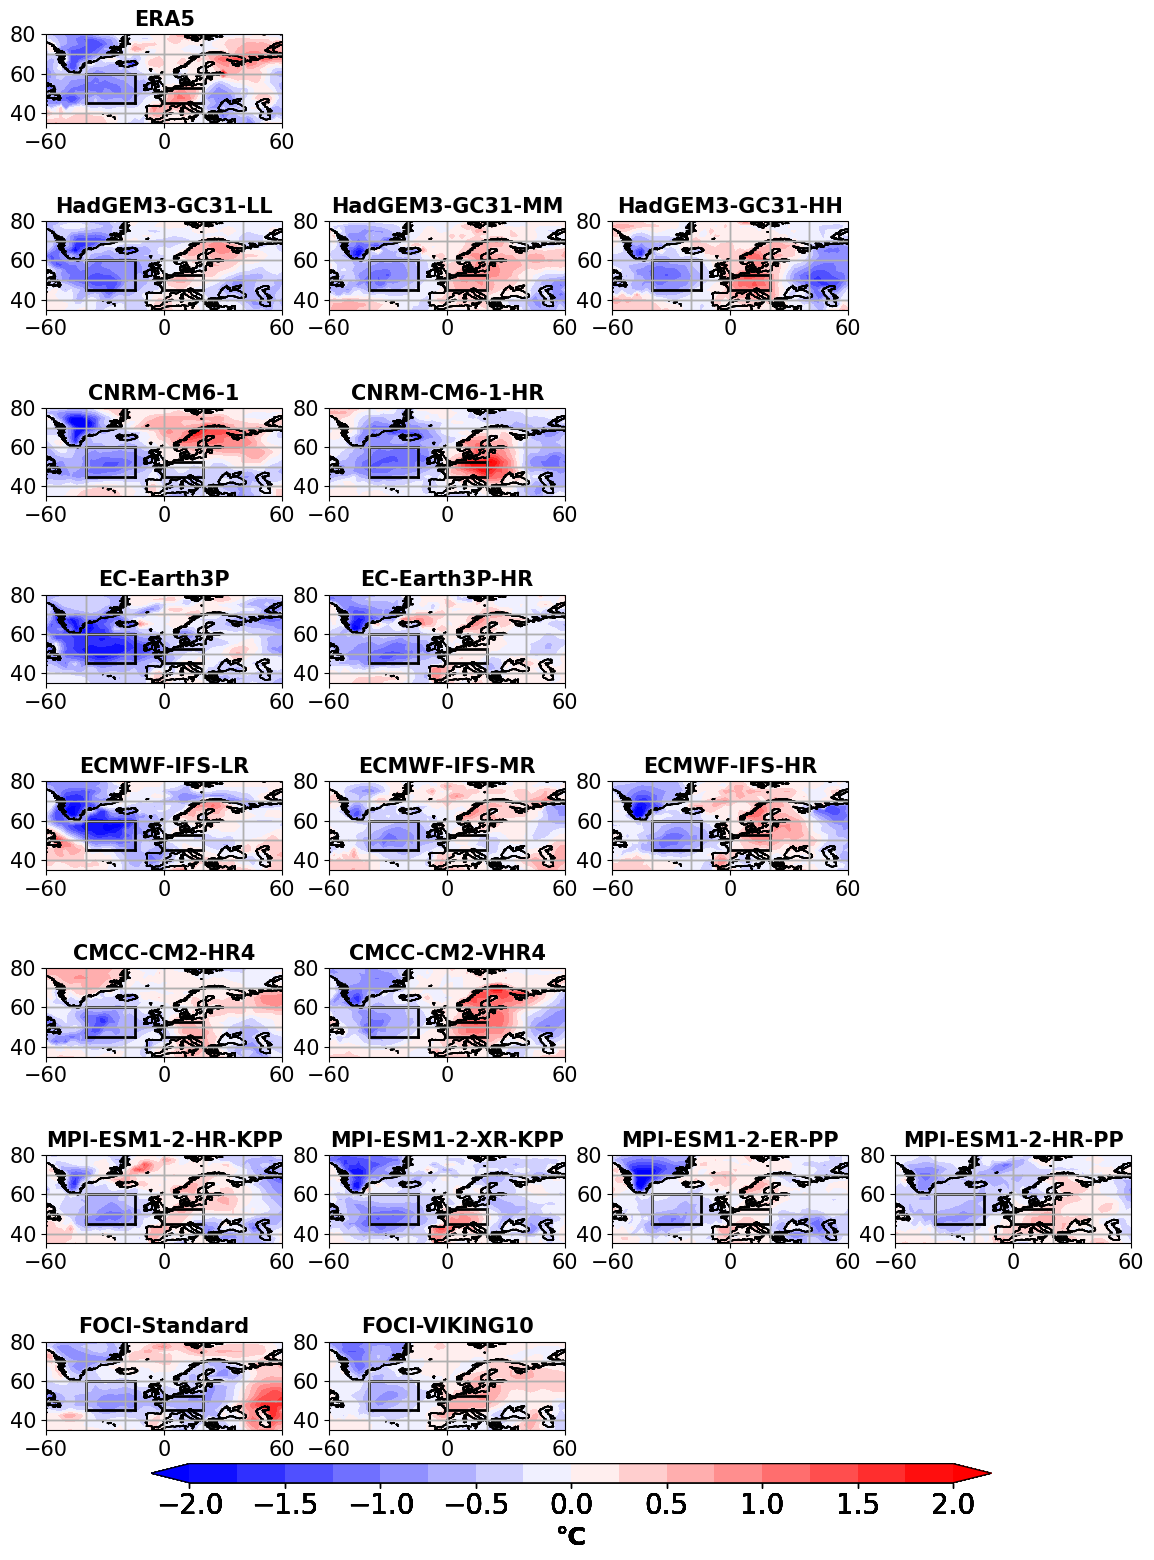

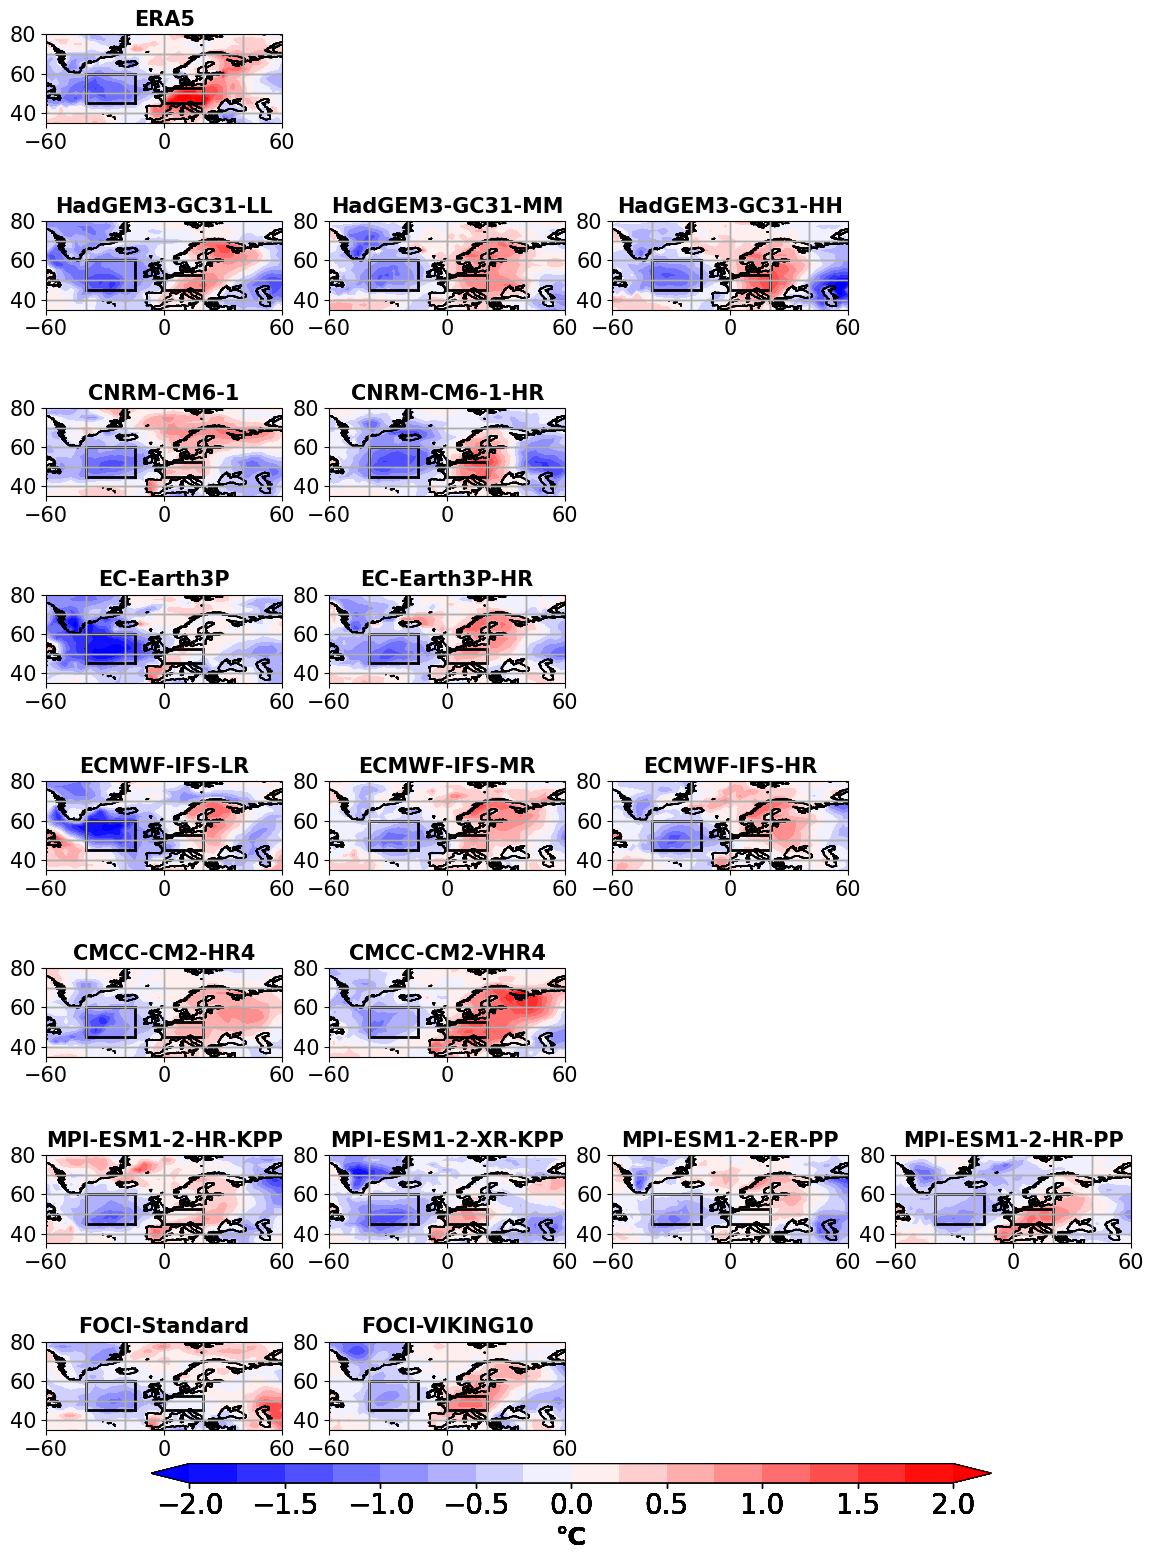

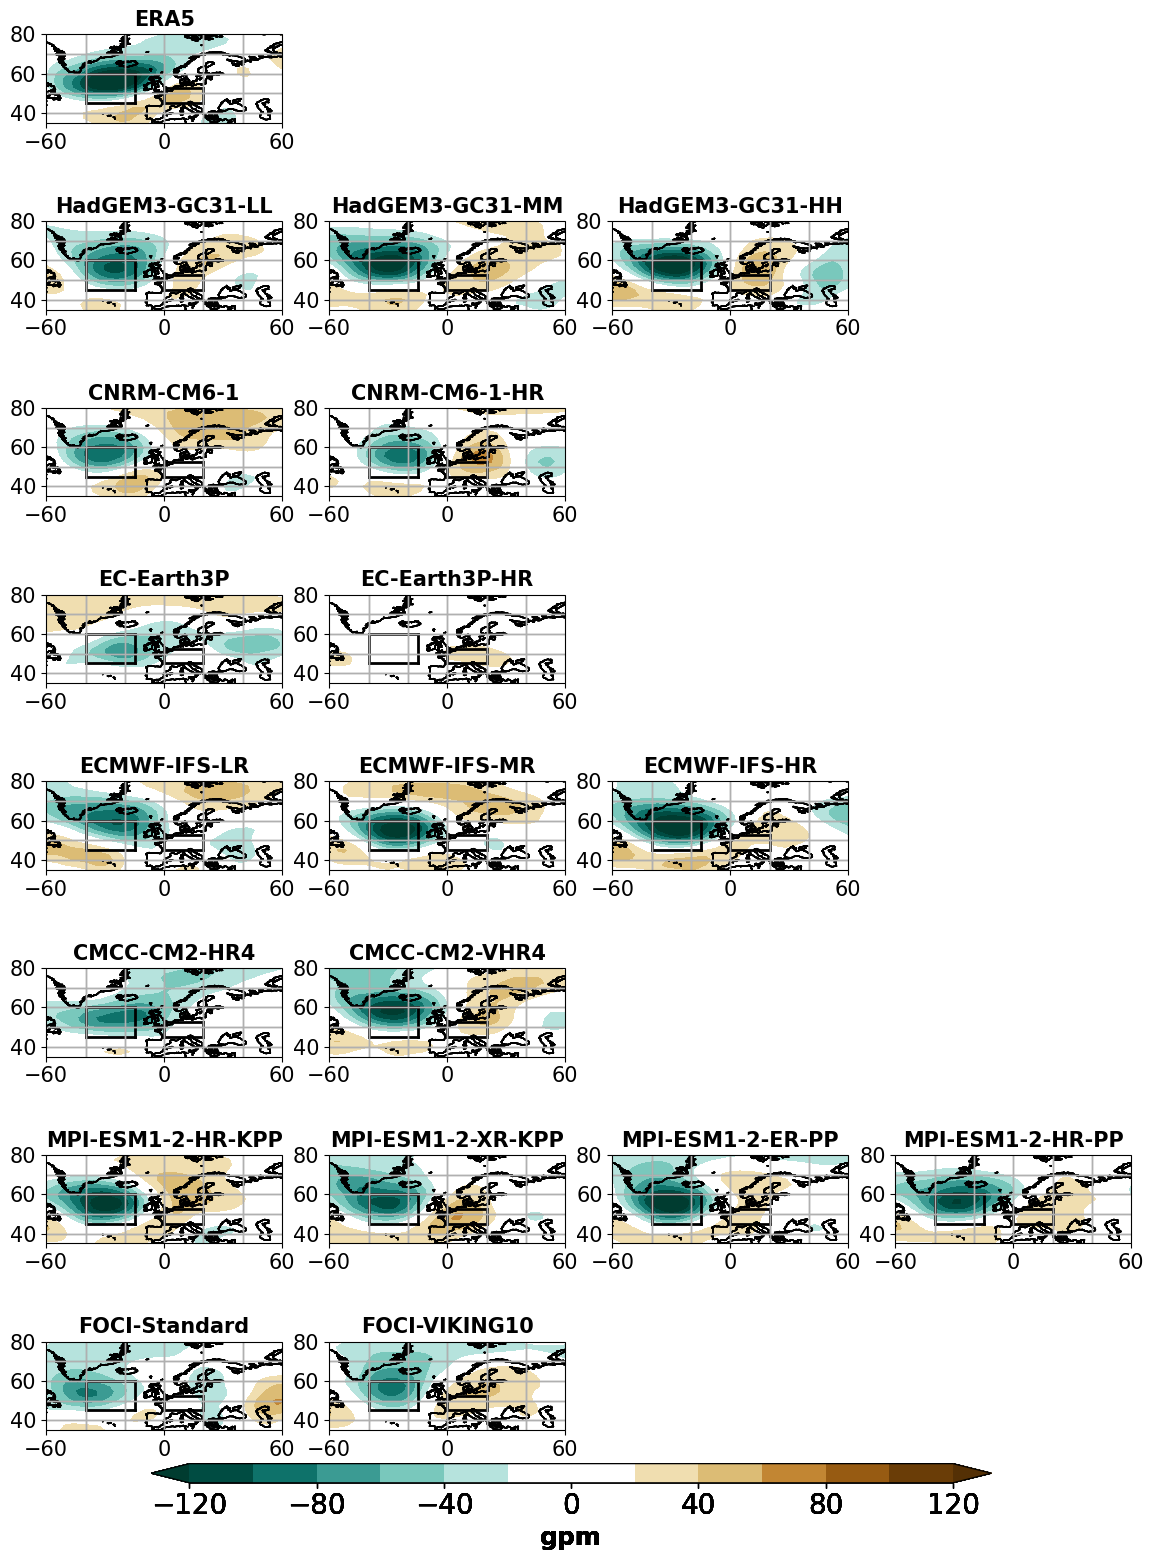

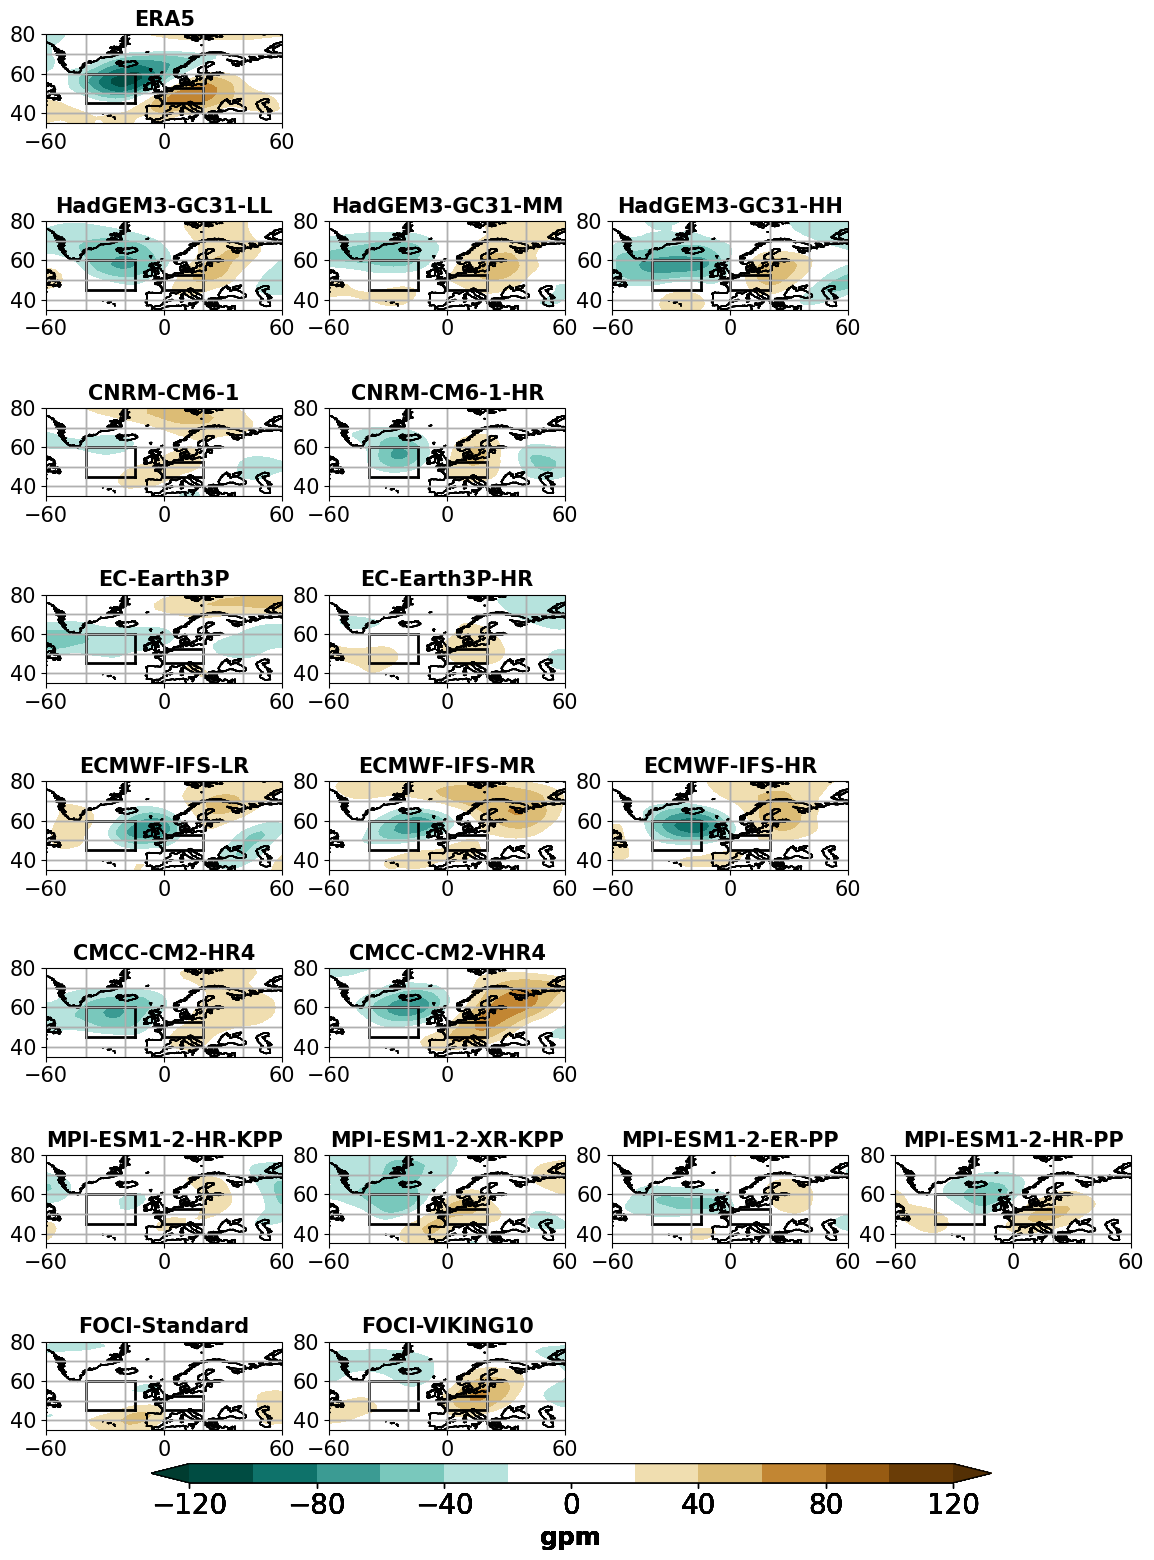

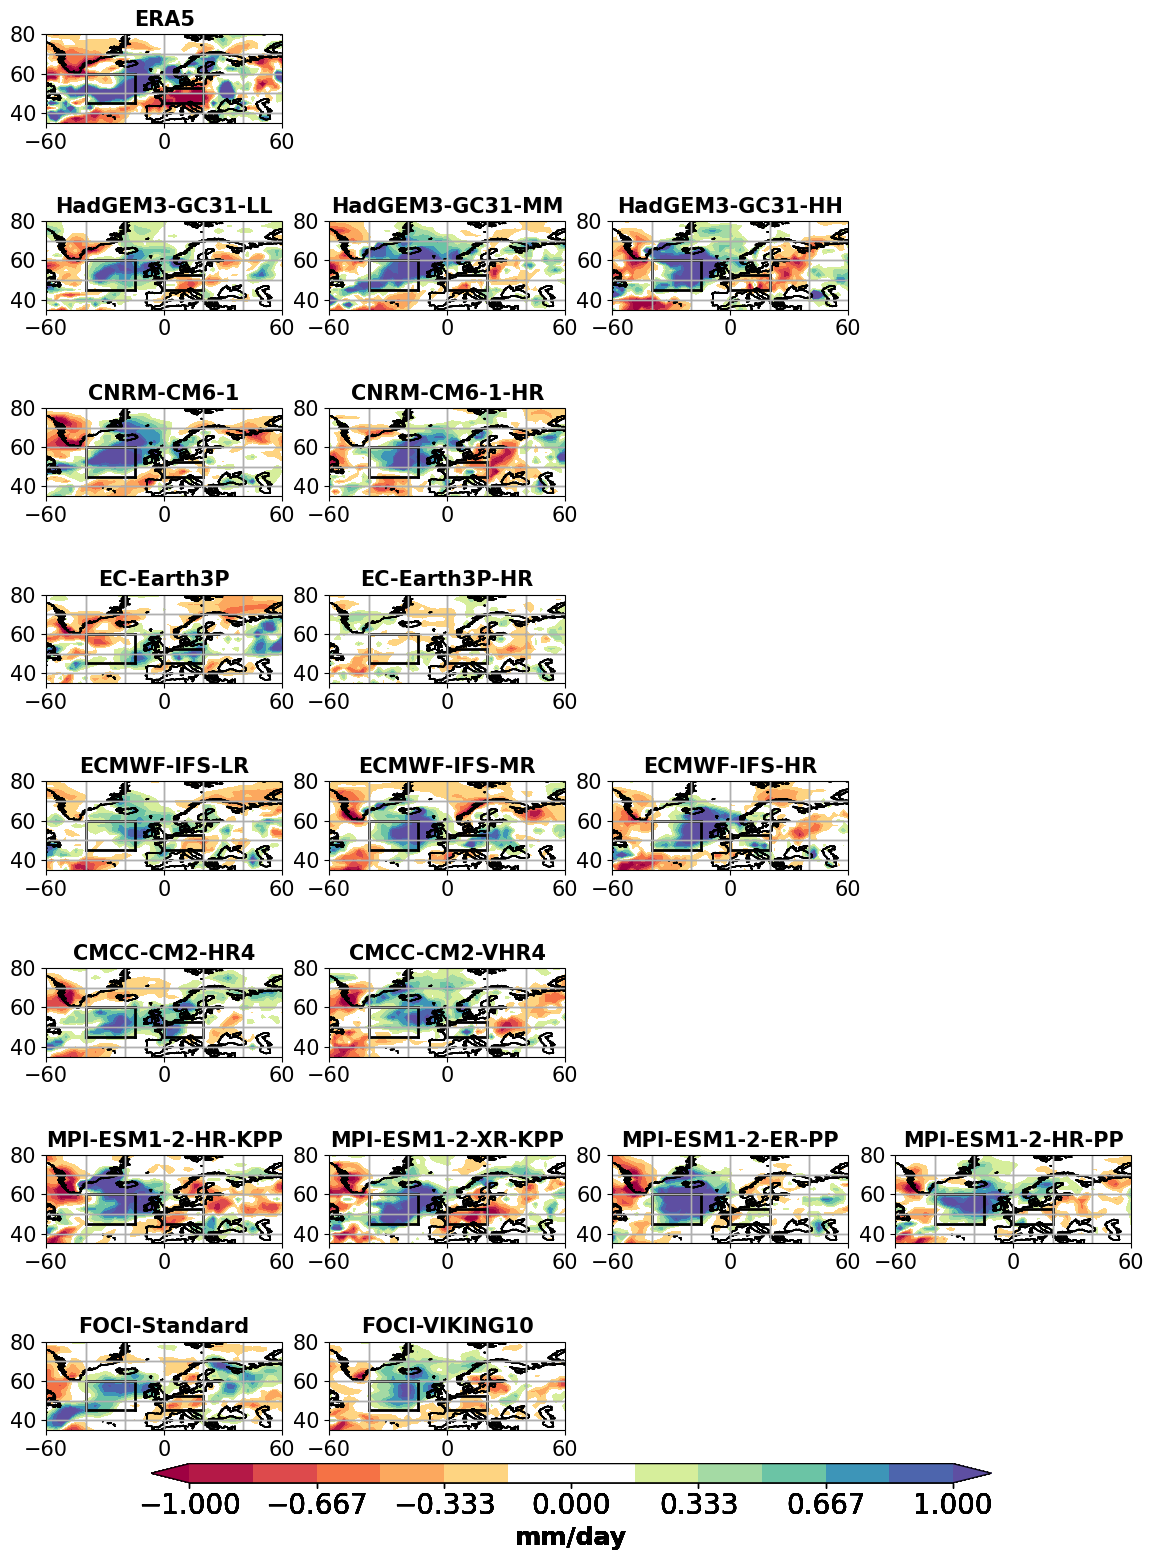

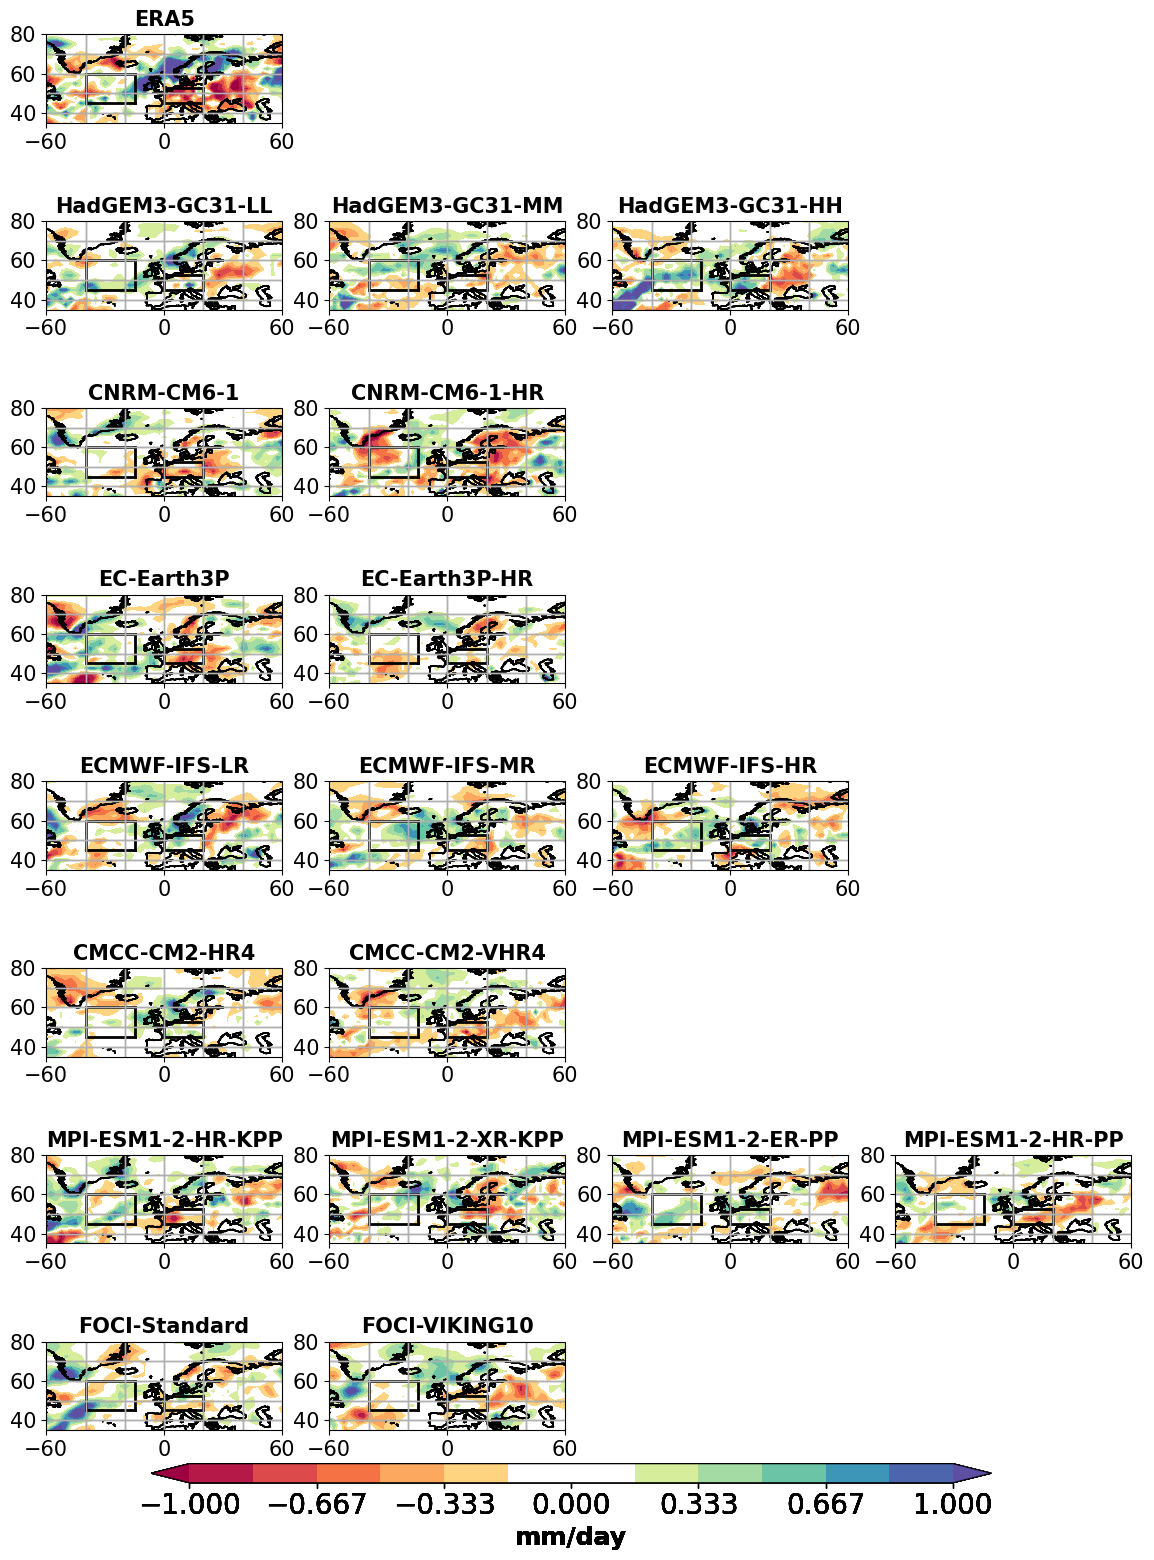

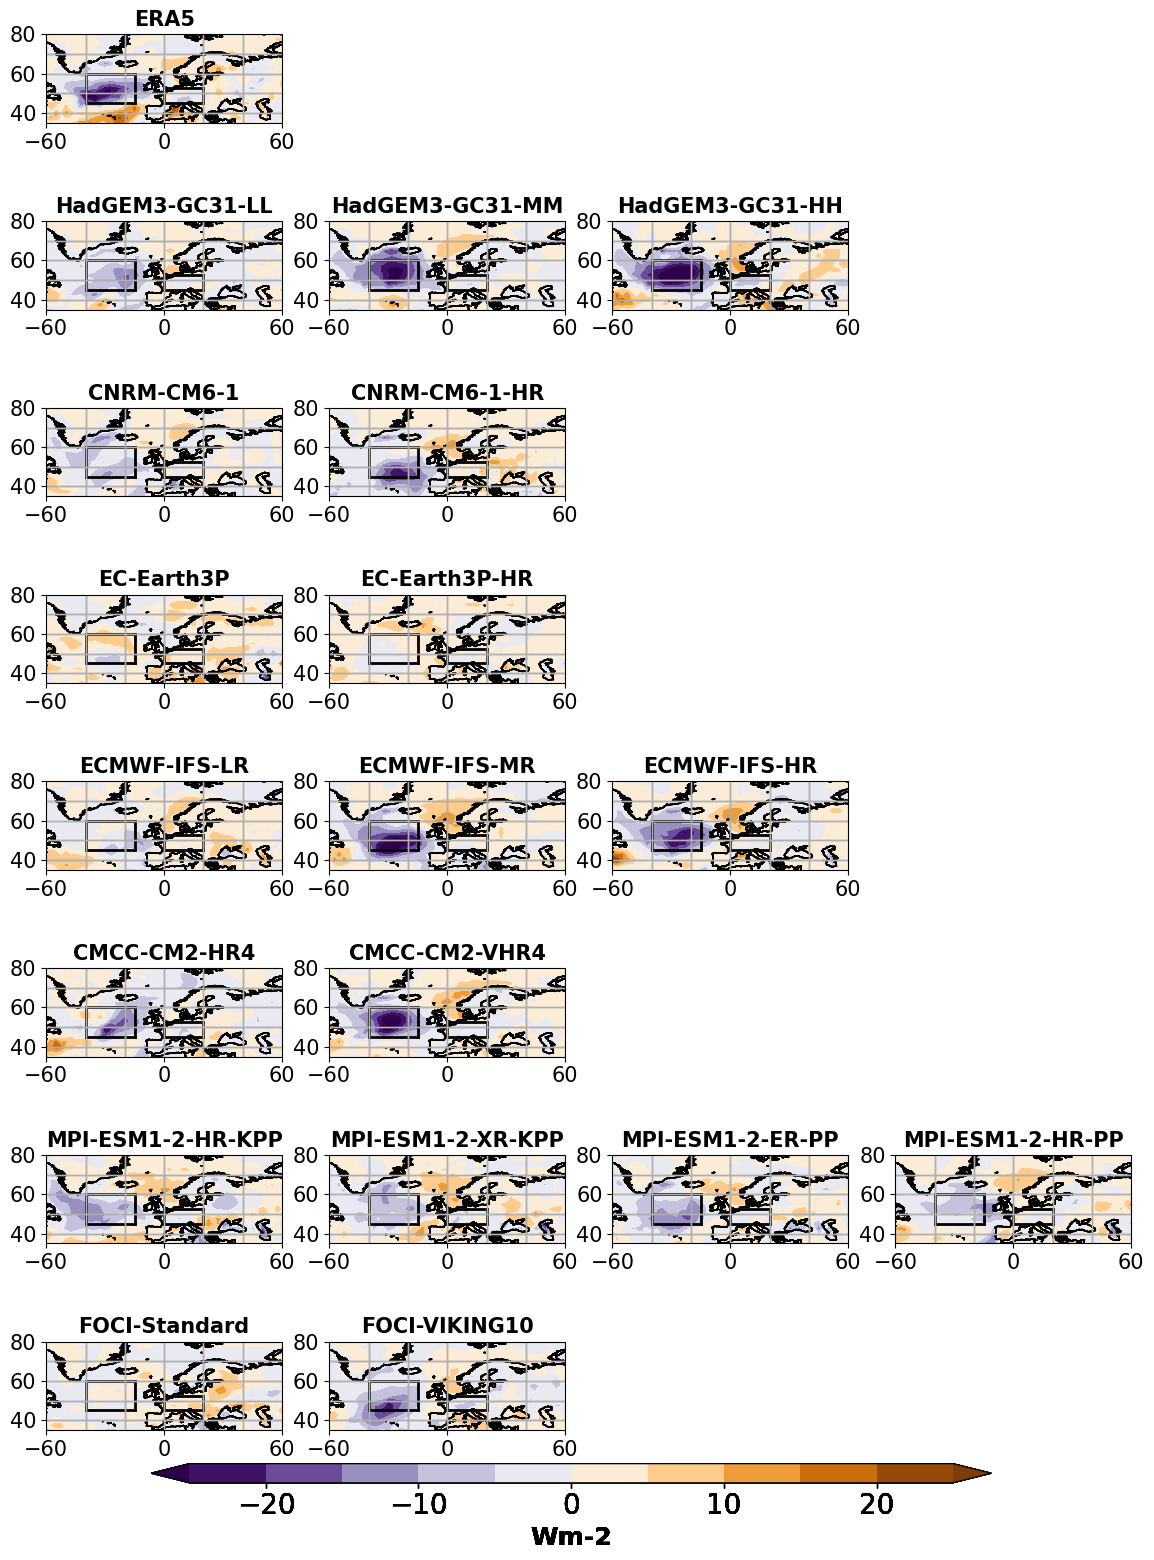

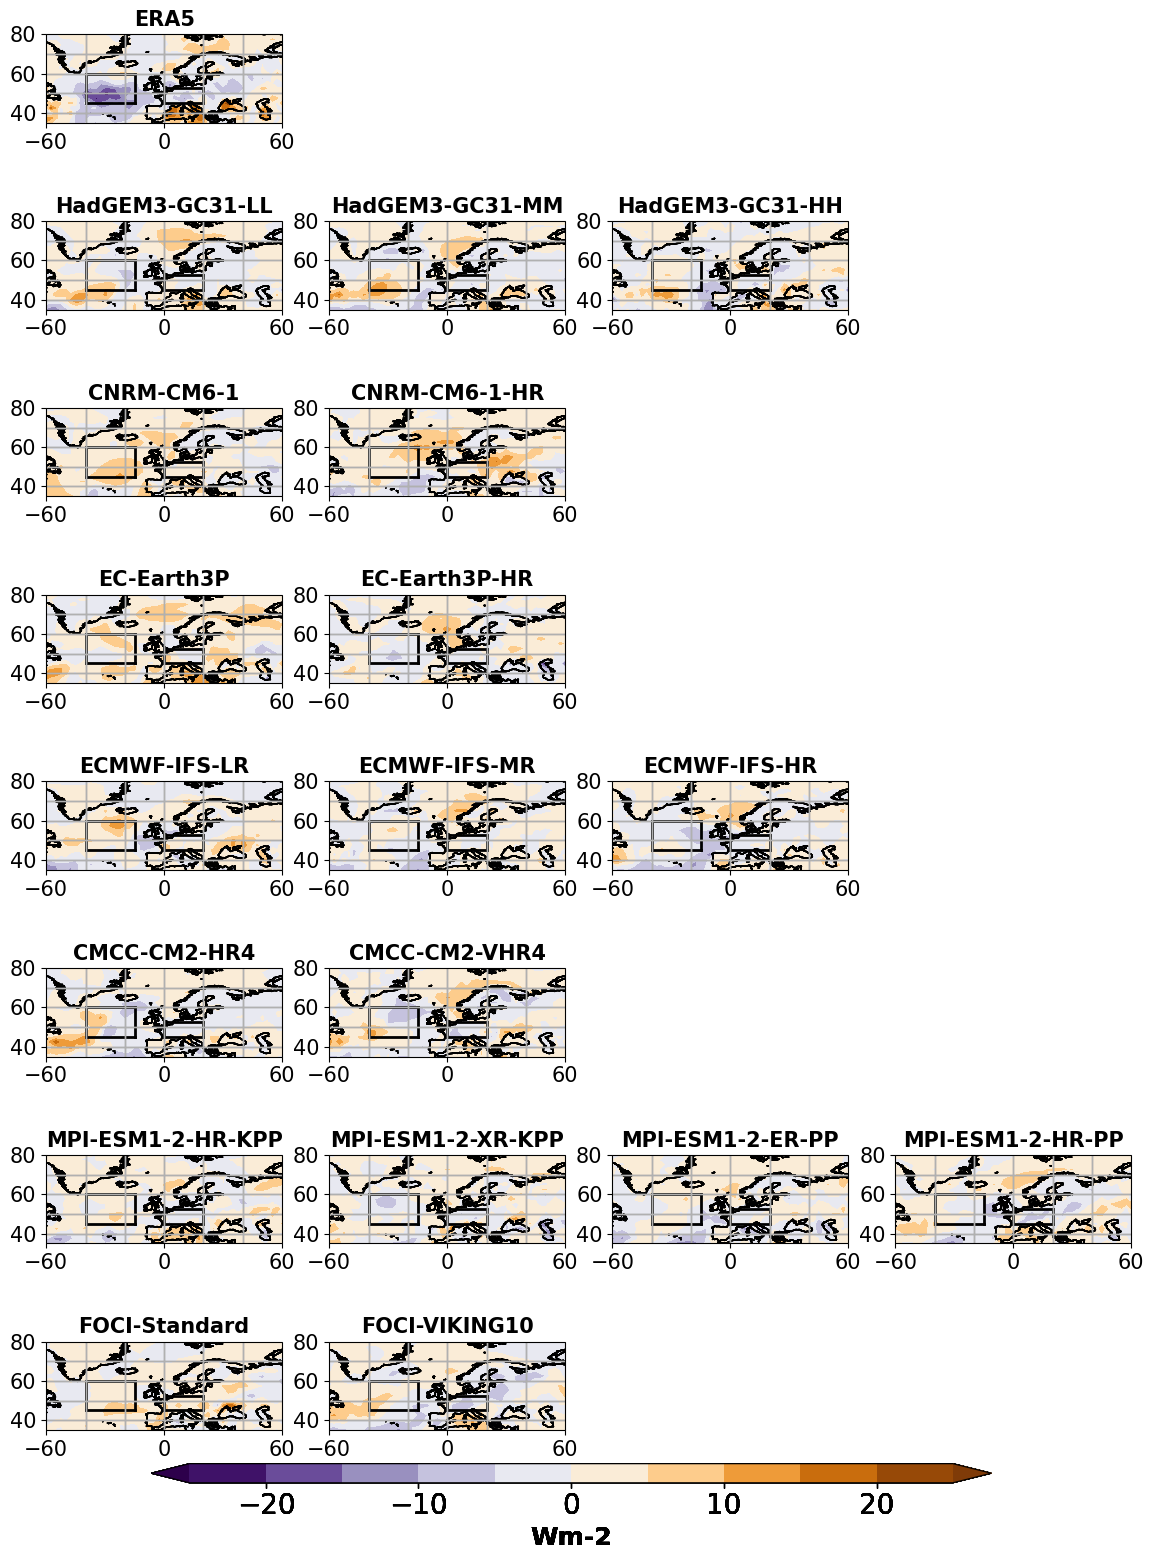

In [20]:
resolution_upd = [[''],
              ['-LL', '-MM', '-HH'],
              ['-1' , '-1-HR'],
              ['', '-HR'],
              ['-LR', '-MR','-HR'],
              ['-HR4','-VHR4'],
              ['-HR-KPP', '-XR-KPP','-ER-PP','-HR-PP'],
              ['-Standard' ,'-VIKING10']]
##### Connect SSt and T2M
#sst_t2m = ds_ERA5_SST.var34.where(ds_ERA5_SST.var34 >= -8.999999873090293e+33, ds_ERA5_T2M.var167)

# Set general font size
plt.rcParams['font.size'] = '15'
lon=np.linspace(0,360,145)

# Define SST and T2m boxes
x1, y1 = [-40, -15], [45, 45]
x2, y2 = [-40, -15], [60, 60]
x3, y3 = [-40, -40], [45, 60]
x4, y4 = [-15, -15], [45, 60]

x1_E, y1_E = [0,20], [45, 45]
x2_E, y2_E = [0, 20], [52.5, 52.5]
x3_E, y3_E = [0, 0], [45, 52.5]
x4_E, y4_E = [20, 20], [45, 52.5]

label=['°C','°C','gpm', 'mm/day','Wm-2']
prj = ccrs.PlateCarree()
X, Y = np.meshgrid(lon, HighRes_model_map[model_name[1]+'tos_-LL_map'][0].lat)

levels = [np.linspace(-2,2,17),np.linspace(-2,2,17), np.linspace(-120,120,13), np.linspace(-1,1,13), np.linspace(-25,25,11)]
cmap=['bwr','bwr',BrBG_cmap_with_white_cm,spectral_white_cm,PuOr_cmap]

lags=[0,5]
for v in [0,2,3,4]:
    for l in range(len(lags)):
        fig = plt.figure(figsize=(14,19))
        ####### Plot
        ax1 = plt.subplot2grid((8, 4),(0, 0), projection=prj)
        
        ax2 = plt.subplot2grid((8, 4),(1, 0), projection=prj)
        ax3 = plt.subplot2grid((8, 4),(1, 1), projection=prj)
        ax4 = plt.subplot2grid((8, 4),(1, 2), projection=prj)
    
        ax5 = plt.subplot2grid((8, 4),(2, 0), projection=prj)
        ax6 = plt.subplot2grid((8, 4),(2, 1), projection=prj)
        
        ax7 = plt.subplot2grid((8, 4),(3, 0), projection=prj)
        ax8 = plt.subplot2grid((8, 4),(3, 1), projection=prj) 
        
        ax9 = plt.subplot2grid((8, 4),(4, 0),  projection=prj)
        ax10 = plt.subplot2grid((8, 4),(4, 1), projection=prj)
        ax11 = plt.subplot2grid((8, 4),(4, 2), projection=prj) 
        
        ax12 = plt.subplot2grid((8, 4),(5, 0), projection=prj)
        ax13 = plt.subplot2grid((8, 4),(5, 1), projection=prj)
        
        ax14 = plt.subplot2grid((8, 4),(6, 0), projection=prj)
        ax15 = plt.subplot2grid((8, 4),(6, 1), projection=prj)    
        ax16 = plt.subplot2grid((8, 4),(6, 2), projection=prj)    
        ax17 = plt.subplot2grid((8, 4),(6, 3), projection=prj)    

        ax18 = plt.subplot2grid((8, 4),(7, 0), projection=prj)
        ax19 = plt.subplot2grid((8, 4),(7, 1), projection=prj)  
        
        axes=[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19]
        k=0
        for row in range(8):
            for col in range(4):
                if row ==0 and col==0: 
                    if v==0:
                        cont= axes[k].contourf(X,Y, np.c_[HighRes_model_map[model_name [row]+ variable[0]+ resolution[row][col]+'_map'][0].fillna(HighRes_model_map[model_name [row]+ variable[1]+ resolution[row][col]+'_map'][0]).sel(lead_lag=lags[l]).squeeze(), HighRes_model_map[model_name [row]+ variable[0]+ resolution[row][col]+'_map'][0].fillna(HighRes_model_map[model_name [row]+ variable[1]+ resolution[row][col]+'_map'][0]).sel(lead_lag=lags[l]).squeeze()[:,0]], cmap=cmap[v],levels=levels[v], transform=prj, extend='both')
                    if v>1:
                        cont= axes[k].contourf(X,Y, np.c_[HighRes_model_map[model_name [row]+ variable[v]+ resolution[row][col]+'_map'][0].sel(lead_lag=lags[l]).squeeze(), HighRes_model_map[model_name [row]+ variable[v]+ resolution[row][col]+'_map'][0].sel(lead_lag=lags[l]).squeeze()[:,0]], cmap=cmap[v],levels=levels[v], transform=prj, extend='both')
                    axes[k].set_title(model_name[row][:-1]+ resolution[row][col], size=15, fontweight='bold')
                    axes[k].plot(x1, y1, x2, y2,x3,y3,x4,y4,x1_E, y1_E, x2_E, y2_E,x3_E,y3_E,x4_E,y4_E, color='black', linestyle='-', linewidth=2)
                    k=k+1
                elif (row==1 or row==4) and col<3:
                    if v==0:
                        cont= axes[k].contourf(X,Y, np.c_[HighRes_model_map[model_name [row]+ variable[0]+ resolution[row][col]+'_map'][0].fillna(HighRes_model_map[model_name [row]+ variable[1]+ resolution[row][col]+'_map'][0]).sel(lead_lag=lags[l]).squeeze(), HighRes_model_map[model_name [row]+ variable[0]+ resolution[row][col]+'_map'][0].fillna(HighRes_model_map[model_name [row]+ variable[1]+ resolution[row][col]+'_map'][0]).sel(lead_lag=lags[l]).squeeze()[:,0]], cmap=cmap[v],levels=levels[v], transform=prj, extend='both')
                    if v>1:
                        cont= axes[k].contourf(X,Y, np.c_[HighRes_model_map[model_name [row]+ variable[v]+ resolution[row][col]+'_map'][0].sel(lead_lag=lags[l]).squeeze(), HighRes_model_map[model_name [row]+ variable[v]+ resolution[row][col]+'_map'][0].sel(lead_lag=lags[l]).squeeze()[:,0]], cmap=cmap[v],levels=levels[v], transform=prj, extend='both')

                    axes[k].set_title(model_name[row][:-1]+ resolution[row][col], size=15, fontweight='bold')
                    axes[k].plot(x1, y1, x2, y2,x3,y3,x4,y4,x1_E, y1_E, x2_E, y2_E,x3_E,y3_E,x4_E,y4_E, color='black', linestyle='-', linewidth=2)
                    k=k+1
                elif (row==2 or row==3 or row==5) and col<2:
                    if v==0:
                        cont= axes[k].contourf(X,Y, np.c_[HighRes_model_map[model_name [row]+ variable[0]+ resolution[row][col]+'_map'][0].fillna(HighRes_model_map[model_name [row]+ variable[1]+ resolution[row][col]+'_map'][0]).sel(lead_lag=lags[l]).squeeze(), HighRes_model_map[model_name [row]+ variable[0]+ resolution[row][col]+'_map'][0].fillna(HighRes_model_map[model_name [row]+ variable[1]+ resolution[row][col]+'_map'][0]).sel(lead_lag=lags[l]).squeeze()[:,0]], cmap=cmap[v],levels=levels[v], transform=prj, extend='both')
                    if v>1:
                        cont= axes[k].contourf(X,Y, np.c_[HighRes_model_map[model_name [row]+ variable[v]+ resolution[row][col]+'_map'][0].sel(lead_lag=lags[l]).squeeze(), HighRes_model_map[model_name [row]+ variable[v]+ resolution[row][col]+'_map'][0].sel(lead_lag=lags[l]).squeeze()[:,0]], cmap=cmap[v],levels=levels[v], transform=prj, extend='both')
                    axes[k].set_title(model_name[row][:-1]+ resolution[row][col], size=15, fontweight='bold')
                    axes[k].plot(x1, y1, x2, y2,x3,y3,x4,y4,x1_E, y1_E, x2_E, y2_E,x3_E,y3_E,x4_E,y4_E, color='black', linestyle='-', linewidth=2)
                    k=k+1
                    
                elif row==6:
                    if v==0:
                        cont= axes[k].contourf(X,Y, np.c_[HighRes_model_map[model_name [row]+ variable[0]+ resolution[row][col]+'_map'][0].fillna(HighRes_model_map[model_name [row]+ variable[1]+ resolution[row][col]+'_map'][0]).sel(lead_lag=lags[l]).squeeze(), HighRes_model_map[model_name [row]+ variable[0]+ resolution[row][col]+'_map'][0].fillna(HighRes_model_map[model_name [row]+ variable[1]+ resolution[row][col]+'_map'][0]).sel(lead_lag=lags[l]).squeeze()[:,0]], cmap=cmap[v],levels=levels[v], transform=prj, extend='both')
                    if v>1:
                        if row == 6 and v==4 and (col==2 or col==3):
                            cont= axes[k].contourf(X,Y, np.c_[HighRes_model_map[model_name [row]+ variable[v]+ resolution[row][col]+'_map'][0].sel(lead_lag=lags[l]).squeeze(), HighRes_model_map[model_name [row]+ variable[v]+ resolution[row][col]+'_map'][0].sel(lead_lag=lags[l]).squeeze()[:,0]], cmap=cmap[v],levels=levels[v], transform=prj, extend='both')
                        else:
                            cont= axes[k].contourf(X,Y, np.c_[HighRes_model_map[model_name [row]+ variable[v]+ resolution[row][col]+'_map'][0].sel(lead_lag=lags[l]).squeeze(), HighRes_model_map[model_name [row]+ variable[v]+ resolution[row][col]+'_map'][0].sel(lead_lag=lags[l]).squeeze()[:,0]], cmap=cmap[v],levels=levels[v], transform=prj, extend='both')

                    axes[k].set_title(model_name[row][:-1]+ resolution_upd[row][col], size=15, fontweight='bold')
                    axes[k].plot(x1, y1, x2, y2,x3,y3,x4,y4,x1_E, y1_E, x2_E, y2_E,x3_E,y3_E,x4_E,y4_E, color='black', linestyle='-', linewidth=2)
                    k=k+1
                    
                elif row==7 and col<2:
                    if v==0:
                        HighRes_model_map[model_name [row]+ variable[0]+ resolution[row][col]+'_map_lsm_corrected'] = xr.where(HighRes_model_map[model_name [0]+ variable[0]+ resolution[0][0]+'_map'][0].sel(lead_lag=0).squeeze().isnull(),HighRes_model_map[model_name [0]+ variable[0]+ resolution[0][0]+'_map'][0].sel(lead_lag=0).squeeze(),HighRes_model_map[model_name [row]+ variable[0]+ resolution[row][col]+'_map'][0])
                        
                        cont= axes[k].contourf(X,Y, np.c_[HighRes_model_map[model_name [row]+ variable[0]+ resolution[row][col]+'_map_lsm_corrected'].fillna(HighRes_model_map[model_name [row]+ variable[1]+ resolution[row][col]+'_map'][0]).sel(lead_lag=lags[l]).squeeze(), HighRes_model_map[model_name [row]+ variable[0]+ resolution[row][col]+'_map_lsm_corrected'].fillna(HighRes_model_map[model_name [row]+ variable[1]+ resolution[row][col]+'_map'][0]).sel(lead_lag=lags[l]).squeeze()[:,0]], cmap=cmap[v],levels=levels[v], transform=prj, extend='both')
                    if v>1:
                        cont= axes[k].contourf(X,Y, np.c_[HighRes_model_map[model_name [row]+ variable[v]+ resolution[row][col]+'_map'][0].sel(lead_lag=lags[l]).squeeze(), HighRes_model_map[model_name [row]+ variable[v]+ resolution[row][col]+'_map'][0].sel(lead_lag=lags[l]).squeeze()[:,0]], cmap=cmap[v],levels=levels[v], transform=prj, extend='both')

                    axes[k].set_title(model_name[row][:-1]+ resolution[row][col], size=15, fontweight='bold')
                    axes[k].plot(x1, y1, x2, y2,x3,y3,x4,y4,x1_E, y1_E, x2_E, y2_E,x3_E,y3_E,x4_E,y4_E, color='black', linestyle='-', linewidth=2)
                    k=k+1

                
            for ax in axes:
                ax.coastlines('50m')
                ax.gridlines()
                ax.set_extent([-60, 60, 35, 80], prj)
                ax.set_xticks([ -60 , 0, 60],crs=prj)
                ax.set_yticks([40, 60, 80],crs=prj)
    
    
            cb_ax = fig.add_axes([0.2, 0.1, 0.6, 0.01])
            cb = fig.colorbar(cont, cax=cb_ax, orientation='horizontal')
            cb.ax.tick_params(labelsize=20)
            cb.set_label(label=label[v], size='large', weight='bold')   

## Plot Lines of all models and multi-model mean 

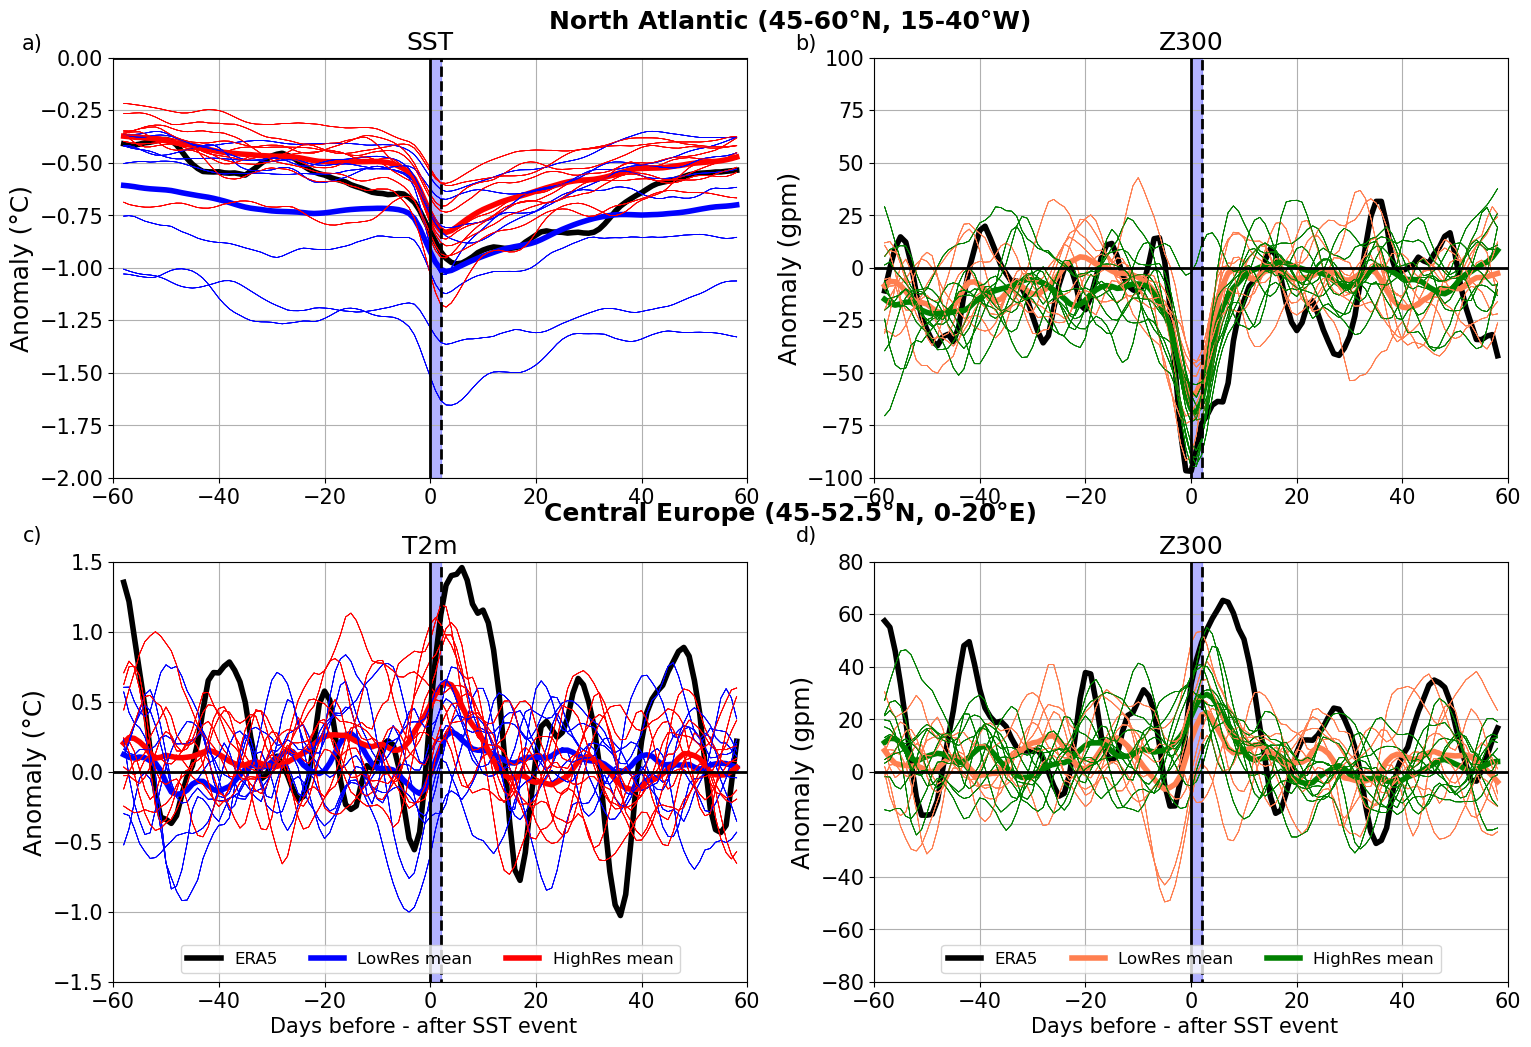

In [37]:
#### SST und T2M
color=[['black','blue','red'],
      ['black', 'coral', 'green'],
      ['black', 'firebrick', 'seagreen'],
      ['black', 'indigo', 'peru']]

reg= ['_Atl', '_Euro']
style= [           ['-'], # ERA5
        [':', '--', '-'], # HadGEM
        [':',       '-'], # CNRM
        [':',       '-'], # EC-Earth
        [':', '--', '-'], # ECMWF-IFS
        [':',       '-'], # CMCC
        [':',       '-']] # MPI-ESM

low_res_type = [[1,0], # HadGEM
                [2,0], # CNRM
                [3,0], # EC-Earth
                [4,0], # ECMWF   
                [6,0], # MPI-ESM # Comment for Fig. S4
                [6,1], # MPI-ESM # Comment for Fig. S4
                [6,3], # MPI-ESM 
                [7,0]] # FOCI

high_res_type = [[1,1], # HadGEM # Comment for Fig. S4
                 [1,2], # HadGEM
                 [2,1], # CNRM
                 [3,1], # EC-Earth
                 [4,1], # ECMWF 
                 [4,2], # ECMWF  # Comment for Fig. S4
                 [5,0], # CMCC   # Comment for Fig. S4
                 [5,1], # CMCC   # Comment for Fig. S4
                 [6,2], # MPI-ESM
                 [7,1]] # FOCI

## Select low and high res and caluclate mean 
LR_Atl ={}
LR_Euro = {}
HR_Atl = {}
HR_Euro = {}
for v in range(len(variable)):
    LR_Atl [variable[v]] = xr.concat([HighRes_model_Atl_line[model_name [mod]+ variable[v]+ resolution[mod][res]+'_Atl_line'][0] for mod,res in low_res_type], dim='ensemble')
    LR_Euro[variable[v]] = xr.concat([HighRes_model_Euro_line[model_name [mod]+ variable[v]+ resolution[mod][res]+'Euro_line'][0] for mod,res in low_res_type], dim='ensemble')
    HR_Atl [variable[v]] = xr.concat([HighRes_model_Atl_line[model_name [mod]+ variable[v]+ resolution[mod][res]+'_Atl_line'][0] for mod,res in high_res_type], dim='ensemble')
    HR_Euro[variable[v]] = xr.concat([HighRes_model_Euro_line[model_name [mod]+ variable[v]+ resolution[mod][res]+'Euro_line'][0] for mod,res in high_res_type], dim='ensemble')

lag_rm=np.linspace(-58,58,117)
line_ds = [[LR_Atl [variable[0]], LR_Euro [variable[1]], HR_Atl [variable[0]], HR_Euro[variable[1]]], 
           [LR_Atl [variable[2]], LR_Euro [variable[2]], HR_Atl [variable[2]], HR_Euro[variable[2]]],
           [LR_Atl [variable[3]], LR_Euro [variable[3]], HR_Atl [variable[3]], HR_Euro[variable[3]]],
           [LR_Atl [variable[4]], LR_Euro [variable[4]], HR_Atl [variable[4]], HR_Euro[variable[4]]]]
titles =['SST', 'Z300', 'T2m','Z300']

label=['°C','°C','gpm','gpm']

fig = plt.figure(figsize=(18,12))
axs=[]
for i in range(1,5):
    axs.append(fig.add_subplot(2,2,i))
for v in range(2):
    if v==0:
        axs[0].plot(lag_rm, HighRes_model_Atl_line[model_name [0]+ variable[0]+ resolution[0][0]+'_Atl_line'][0], color =color[v][0], label='ERA5', ls=style[0][0], lw=4)
        axs[2].plot(lag_rm, HighRes_model_Euro_line[model_name [0]+ variable[1]+ resolution[0][0]+'Euro_line'][0], color =color[v][0], label='ERA5', ls=style[0][0], lw=4)

    if v>0:
        axs[1].plot(lag_rm, HighRes_model_Atl_line[model_name [0]+ variable[v+1]+ resolution[0][0]+'_Atl_line'][0], color =color[v][0], label='ERA5', ls=style[0][0], lw=4)
        axs[3].plot(lag_rm, HighRes_model_Euro_line[model_name [0]+ variable[v+1]+ resolution[0][0]+'Euro_line'][0], color =color[v][0], label='ERA5', ls=style[0][0], lw=4)
    if v==0:
        axs[0].set_ylim([-2,0])
        axs[2].set_ylim([-1.5,1.5])
    elif v==1:
        axs[1].set_ylim([-100,100])
        axs[3].set_ylim([-80,80]) 

axs[0].set_title(titles[0], fontsize=18)
axs[1].set_title(titles[1], fontsize=18)
axs[2].set_title(titles[2], fontsize=18)
axs[3].set_title(titles[3], fontsize=18)

axs[0].plot(lag_rm, line_ds[0][0].mean('ensemble'), lw=4, color= color[0][1])
axs[0].plot(lag_rm, line_ds[0][2].mean('ensemble'), lw=4, color= color[0][2])
axs[2].plot(lag_rm, line_ds[0][1].mean('ensemble'), lw=4, color= color[0][1], label='LowRes mean')
axs[2].plot(lag_rm, line_ds[0][3].mean('ensemble'), lw=4, color= color[0][2], label='HighRes mean')
    
axs[1].plot(lag_rm, line_ds[1][0].mean('ensemble'), lw=4, color= color[1][1])
axs[1].plot(lag_rm, line_ds[1][2].mean('ensemble'), lw=4, color= color[1][2])
axs[3].plot(lag_rm, line_ds[1][1].mean('ensemble'), lw=4, color= color[1][1], label='LowRes mean')
axs[3].plot(lag_rm, line_ds[1][3].mean('ensemble'), lw=4, color= color[1][2], label='HighRes mean')
for var in range(len(variable)):
    for ens in range(len(low_res_type)):
        axs[0].plot(lag_rm, line_ds[0][0][ens,:], color =color[0][1], lw=0.5)
        axs[2].plot(lag_rm, line_ds[0][1][ens,:], color =color[0][1], lw=0.5)
        axs[1].plot(lag_rm, line_ds[1][0][ens,:], color =color[1][1], lw=0.5)
        axs[3].plot(lag_rm, line_ds[1][1][ens,:], color =color[1][1], lw=0.5)           
    for ens in range(len(high_res_type)):
        axs[0].plot(lag_rm, line_ds[0][2][ens,:], color =color[0][2], lw=0.5)
        axs[2].plot(lag_rm, line_ds[0][3][ens,:], color =color[0][2], lw=0.5)
        axs[1].plot(lag_rm, line_ds[1][2][ens,:], color =color[1][2], lw=0.5)
        axs[3].plot(lag_rm, line_ds[1][3][ens,:], color =color[1][2], lw=0.5)
plt.figtext(0.5013,0.92,"North Atlantic (45-60°N, 15-40°W)", ha="center", va="top", fontsize=18, weight='bold')
plt.figtext(0.5013,0.51,"Central Europe (45-52.5°N, 0-20°E)", ha="center", va="top", fontsize=18, weight='bold')
    
                
for ax in axs:
    ax.plot([-60, 60], [0, 0], color='black', lw=2)
    ax.axvspan(0, 2, alpha=0.3, color='blue')
    ax.plot([2,2],[-130,130], color='black', ls='--', lw=2)
    ax.plot([0,0], [-130, 130], color='black', lw=2)
    ax.set_xlim([-60,60])
    ax.grid()
axs[0].set_ylabel('Anomaly (°C)', fontsize=18)
axs[2].set_ylabel('Anomaly (°C)', fontsize=18)
axs[1].set_ylabel('Anomaly (gpm)', fontsize=18)
axs[3].set_ylabel('Anomaly (gpm)', fontsize=18)

handles, labels = axs[2].get_legend_handles_labels()
axs[2].legend(handles[0:13], labels[0:13], fontsize=12, loc=8, ncol=6)
handles, labels = axs[3].get_legend_handles_labels()
axs[3].legend(handles[0:13], labels[0:13], fontsize=12, loc=8, ncol=6)
        
axs[2].set_xlabel('Days before - after SST event  ', fontsize=15)
axs[3].set_xlabel('Days before - after SST event  ', fontsize=15)
   
plt.figtext(0.08,0.90,"a)", ha="center", va="top")
plt.figtext(0.08,0.49,"c)", ha="center", va="top")
plt.figtext(0.51,0.90,"b)", ha="center", va="top")
plt.figtext(0.51,0.49,"d)", ha="center", va="top")

plt.savefig('figs/figS3.pdf', bbox_inches='tight', dpi=200)

## Plot Model mean maps

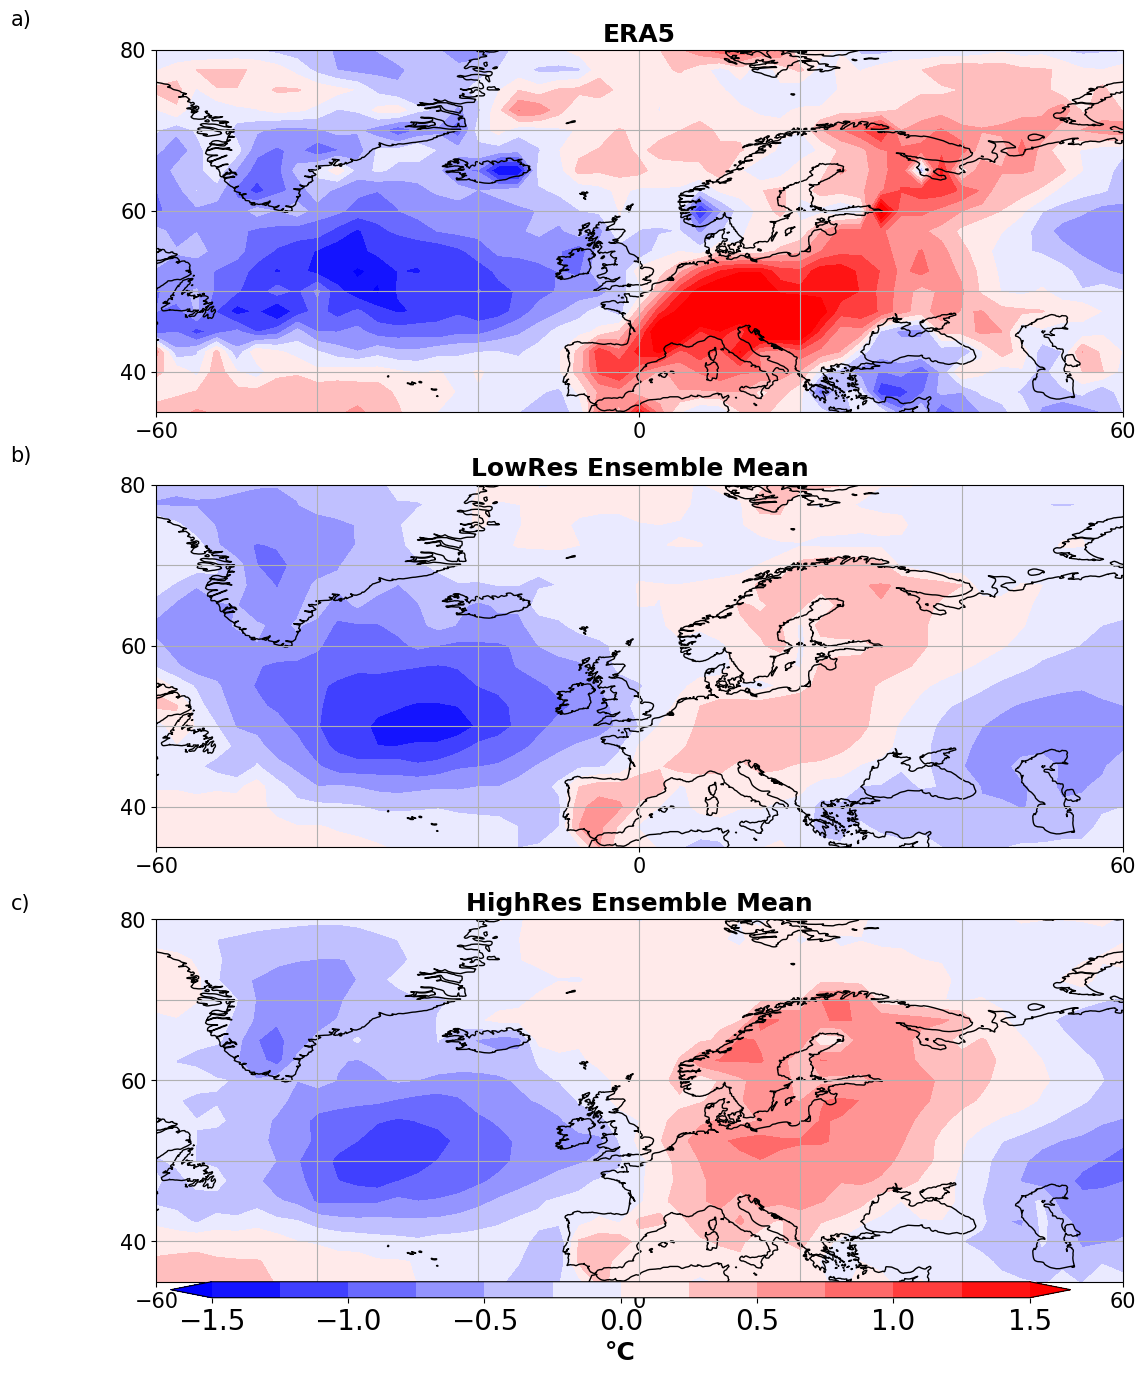

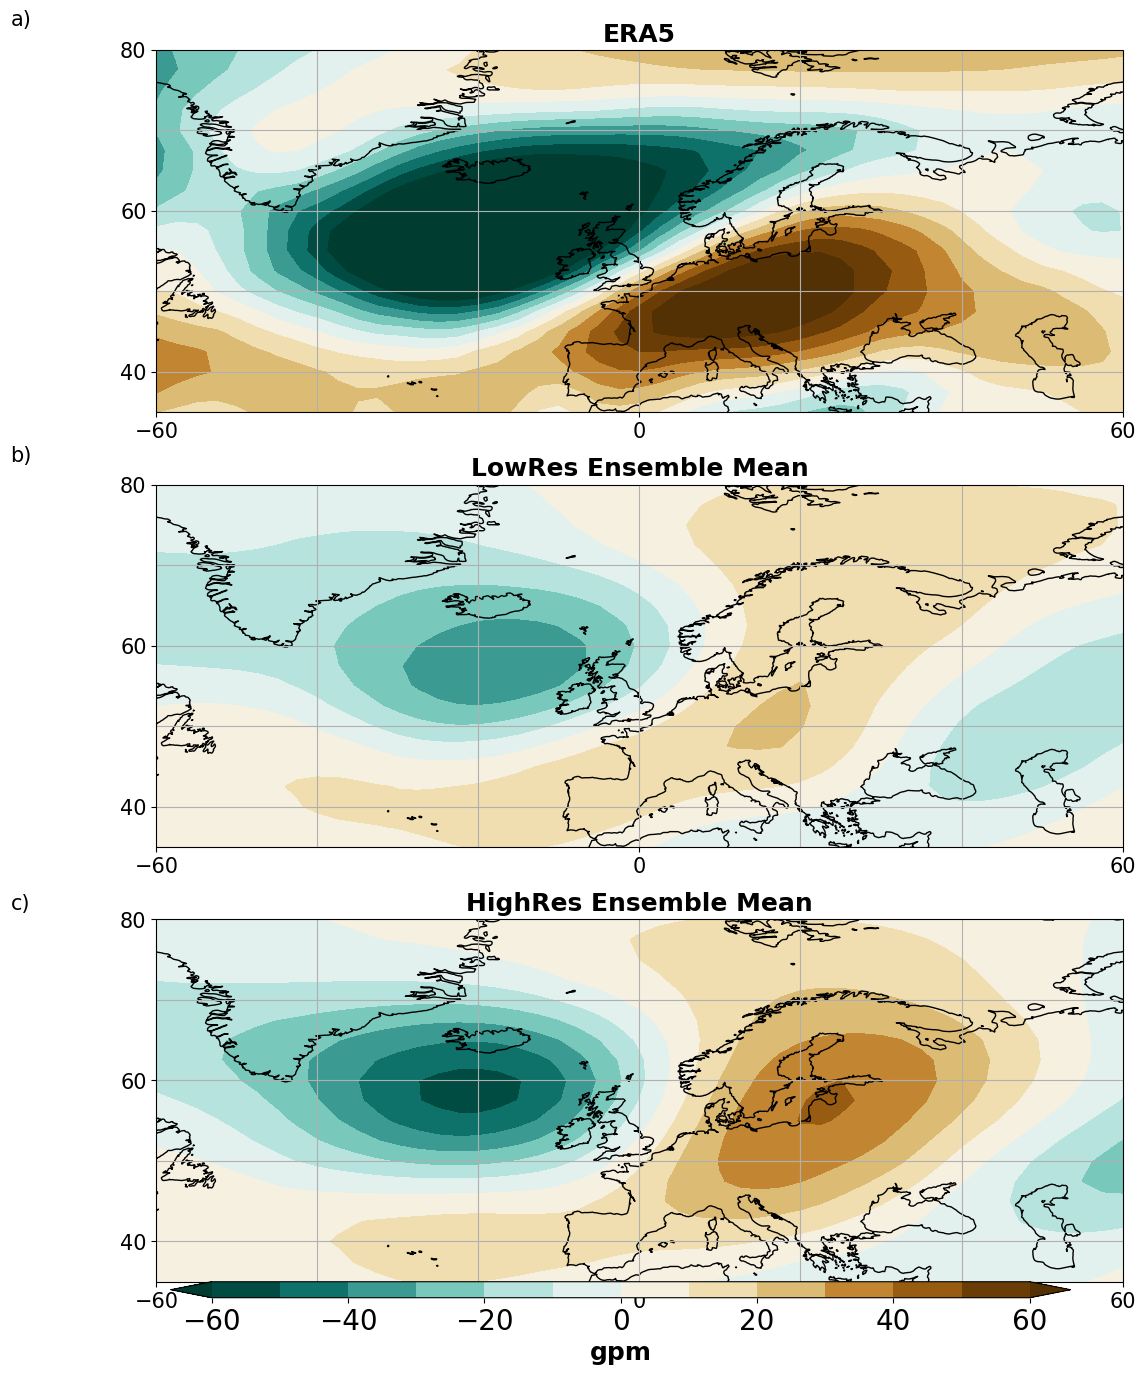

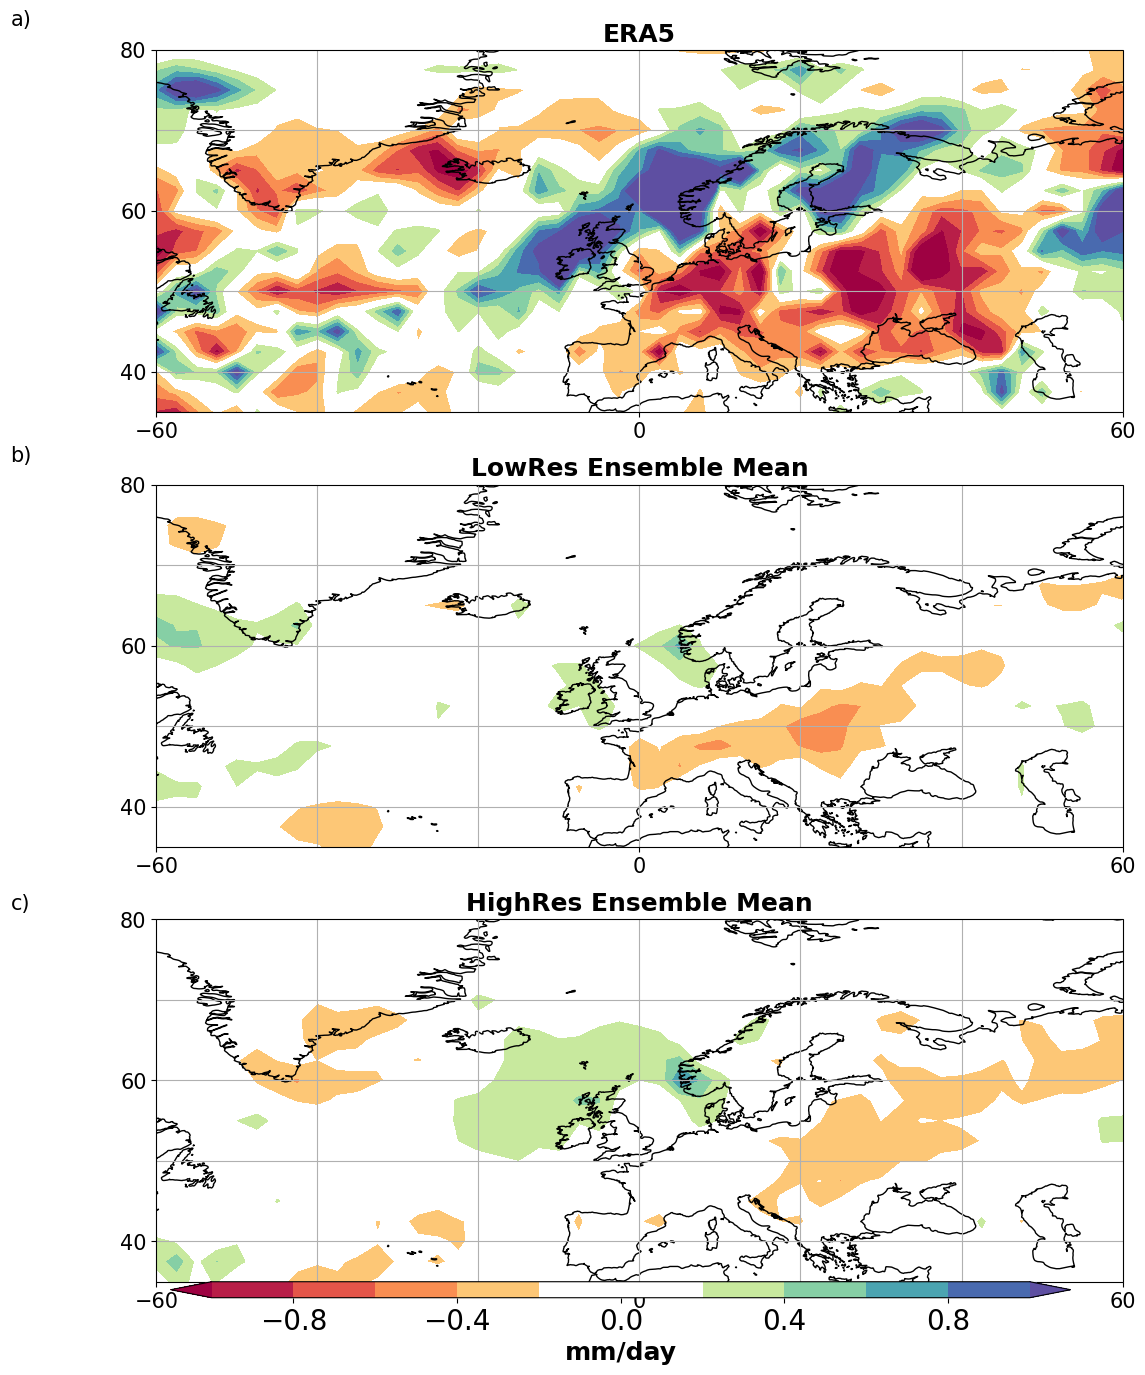

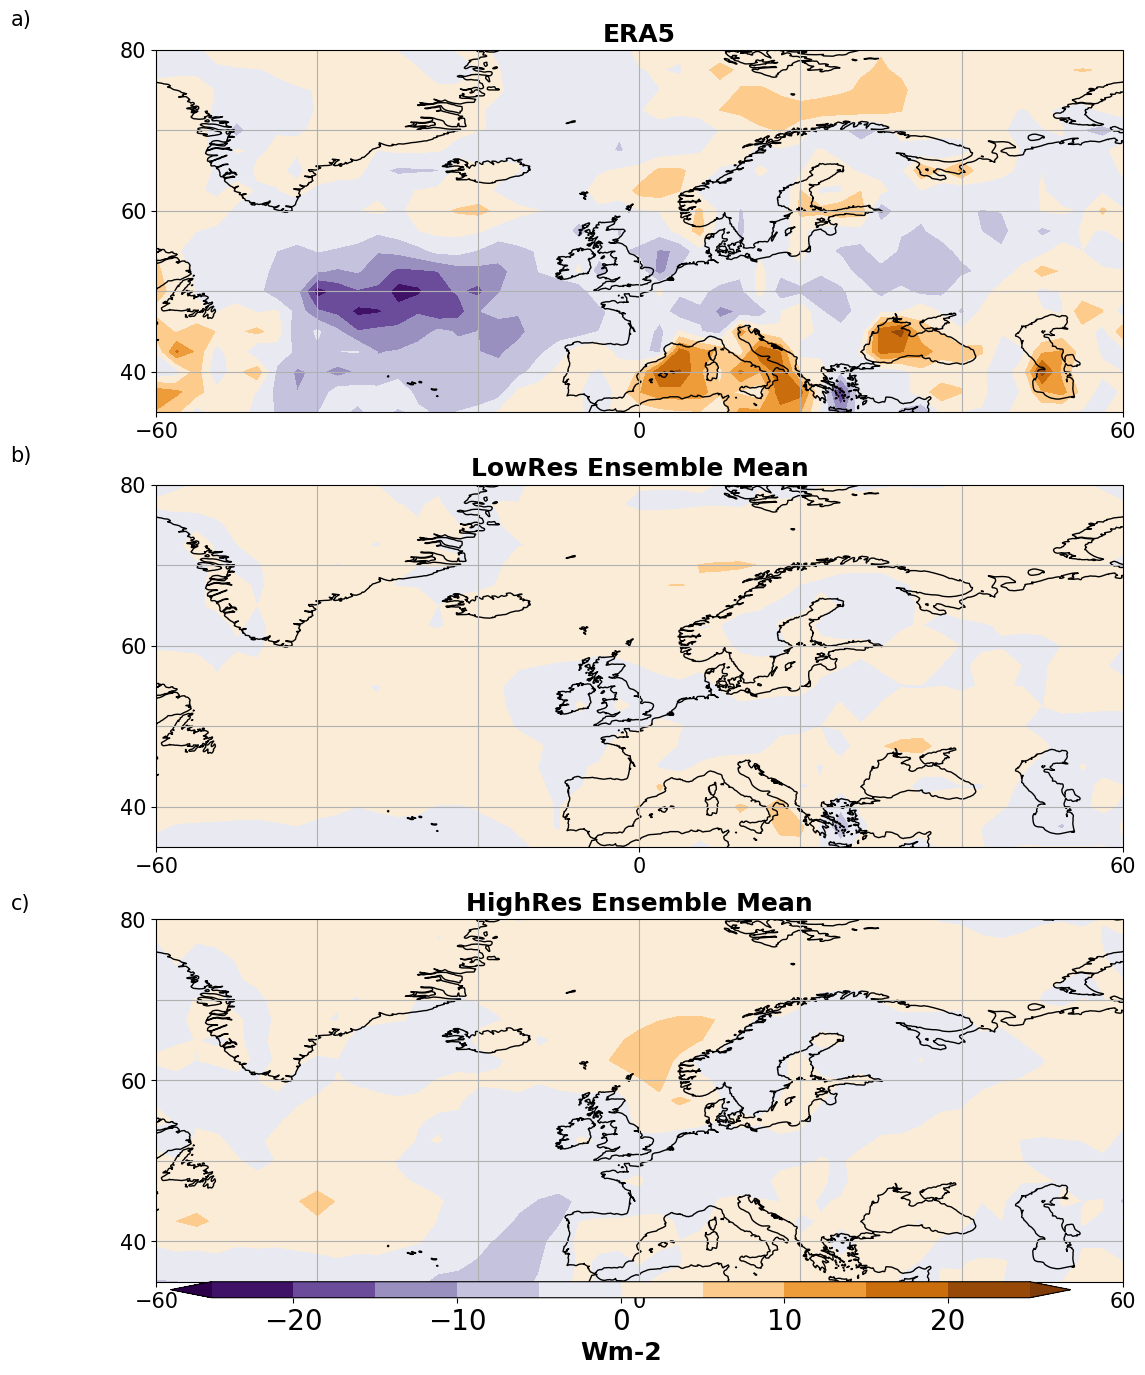

In [36]:
LR_SST_T2m_map = xr.concat([HighRes_model_map[model_name[mod]+ variable[0]+ resolution[mod][res]+'_map'][0].fillna(HighRes_model_map[model_name[mod]+ variable[1]+ resolution[mod][res]+'_map'][0]) for mod,res in low_res_type],  dim='ensemble')
HR_SST_T2m_map = xr.concat([HighRes_model_map[model_name[mod]+ variable[0]+ resolution[mod][res]+'_map'][0].fillna(HighRes_model_map[model_name[mod]+ variable[1]+ resolution[mod][res]+'_map'][0]) for mod,res in high_res_type], dim='ensemble')
#### Z300
LR_Z300_map = xr.concat([HighRes_model_map[model_name [mod]+ variable[2]+ resolution[mod][res]+'_map'][0] for mod,res in low_res_type], dim='ensemble')
HR_Z300_map = xr.concat([HighRes_model_map[model_name [mod]+ variable[2]+ resolution[mod][res]+'_map'][0] for mod,res in high_res_type], dim='ensemble')
#### Precip
LR_pr_map = xr.concat([HighRes_model_map[model_name [mod]+ variable[3]+ resolution[mod][res]+'_map'][0] for mod,res in low_res_type], dim='ensemble')
HR_pr_map = xr.concat([HighRes_model_map[model_name [mod]+ variable[3]+ resolution[mod][res]+'_map'][0] for mod,res in high_res_type], dim='ensemble')
#### HFLS
LR_hfls_map = xr.concat([HighRes_model_map[model_name [mod]+ variable[4]+ resolution[mod][res]+'_map'][0] for mod,res in low_res_type], dim='ensemble')
HR_hfls_map = xr.concat([HighRes_model_map[model_name [mod]+ variable[4]+ resolution[mod][res]+'_map'][0] for mod,res in high_res_type], dim='ensemble')

#### SST & T2m bootstrap
LR_SST_T2m_map_025 = xr.concat([bootstrap_mean_quant_025_map_SST_T2m_lag5[model_name [mod]+ variable[0]+ resolution[mod][res]] for mod,res in low_res_type], dim='ensemble').mean('ensemble')
HR_SST_T2m_map_025 = xr.concat([bootstrap_mean_quant_025_map_SST_T2m_lag5[model_name [mod]+ variable[0]+ resolution[mod][res]] for mod,res in high_res_type], dim='ensemble').mean('ensemble')
LR_SST_T2m_map_975 = xr.concat([bootstrap_mean_quant_975_map_SST_T2m_lag5[model_name [mod]+ variable[0]+ resolution[mod][res]] for mod,res in low_res_type], dim='ensemble').mean('ensemble')
HR_SST_T2m_map_975 = xr.concat([bootstrap_mean_quant_975_map_SST_T2m_lag5[model_name [mod]+ variable[0]+ resolution[mod][res]] for mod,res in high_res_type], dim='ensemble').mean('ensemble')
 
#### Z300 bootstrap
LR_Z300_map_025 = xr.concat([bootstrap_mean_quant_025_map_Z300_lag5[model_name [mod]+ variable[2]+ resolution[mod][res]] for mod,res in low_res_type], dim='ensemble').mean('ensemble')
HR_Z300_map_025 = xr.concat([bootstrap_mean_quant_025_map_Z300_lag5[model_name [mod]+ variable[2]+ resolution[mod][res]] for mod,res in high_res_type], dim='ensemble').mean('ensemble')
LR_Z300_map_975 = xr.concat([bootstrap_mean_quant_975_map_Z300_lag5[model_name [mod]+ variable[2]+ resolution[mod][res]] for mod,res in low_res_type], dim='ensemble').mean('ensemble')
HR_Z300_map_975 = xr.concat([bootstrap_mean_quant_975_map_Z300_lag5[model_name [mod]+ variable[2]+ resolution[mod][res]] for mod,res in high_res_type], dim='ensemble').mean('ensemble')
 
#### HFLS bootstrap
LR_hfls_map_025 = xr.concat([bootstrap_mean_quant_025_map_SLHF_lag0[model_name [mod]+ variable[4]+ resolution[mod][res]] for mod,res in low_res_type], dim='ensemble').mean('ensemble')
HR_hfls_map_025 = xr.concat([bootstrap_mean_quant_025_map_SLHF_lag0[model_name [mod]+ variable[4]+ resolution[mod][res]] for mod,res in high_res_type], dim='ensemble').mean('ensemble')
LR_hfls_map_975 = xr.concat([bootstrap_mean_quant_975_map_SLHF_lag0[model_name [mod]+ variable[4]+ resolution[mod][res]] for mod,res in low_res_type], dim='ensemble').mean('ensemble')
HR_hfls_map_975 = xr.concat([bootstrap_mean_quant_975_map_SLHF_lag0[model_name [mod]+ variable[4]+ resolution[mod][res]] for mod,res in high_res_type], dim='ensemble').mean('ensemble')


map_ds= [[LR_SST_T2m_map, HR_SST_T2m_map],
         [LR_Z300_map, HR_Z300_map],
         [LR_pr_map, HR_pr_map],
         [LR_hfls_map, HR_hfls_map], 
         ]

label=['°C','gpm', 'mm/day','Wm-2']#,'Wm-2']

levels = [np.linspace(-1.5,1.5,13), np.linspace(-60,60,13), np.linspace(-1,1,11), np.linspace(-25,25,11)]

cmap=['bwr', BrBG_cmap, spectral_white_cm, PuOr_cmap]#,PuOr_cmap]

for v in range(4):
    
    fig = plt.figure(figsize=(15,16))
    axs=[]
    for i in range(1,4):
            axs.append(fig.add_subplot(3,1,i, projection=prj))
    if v==0:        
        contf= axs[0].contourf(X,Y, np.c_[HighRes_model_map[model_name[0]+ variable[0]+ resolution[0][0]+'_map'][0].fillna(HighRes_model_map[model_name[0]+ variable[1]+ resolution[0][0]+'_map'][0]).sel(lead_lag=5),HighRes_model_map[model_name[0]+ variable[0]+ resolution[0][0]+'_map'][0].fillna(HighRes_model_map[model_name[0]+ variable[1]+ resolution[0][0]+'_map'][0]).sel(lead_lag=5)[:,0]], cmap=cmap[v], levels=levels[v], extend='both')
    if v>0:
        contf= axs[0].contourf(X,Y, np.c_[HighRes_model_map[model_name[0]+ variable[v+1]+ resolution[0][0]+'_map'][0].sel(lead_lag=5),HighRes_model_map[model_name[0]+ variable[v+1]+ resolution[0][0]+'_map'][0].sel(lead_lag=5)[:,0]], cmap=cmap[v], levels=levels[v], extend='both')

    contf= axs[1].contourf(X,Y, np.c_[map_ds[v][0].mean('ensemble').sel(lead_lag=5),map_ds[v][0].mean('ensemble').sel(lead_lag=5)[:,0]], cmap=cmap[v], levels=levels[v], extend='both')
    contf= axs[2].contourf(X,Y, np.c_[map_ds[v][1].mean('ensemble').sel(lead_lag=5),map_ds[v][1].mean('ensemble').sel(lead_lag=5)[:,0]], cmap=cmap[v], levels=levels[v], extend='both')
    axs[0].set_title('ERA5', fontweight='bold')
    axs[1].set_title('LowRes Ensemble Mean', fontweight='bold')
    axs[2].set_title('HighRes Ensemble Mean', fontweight='bold')
                
    for ax in axs:
        ax.coastlines('50m')
        ax.gridlines()
        ax.set_extent([-60, 60, 35, 80], prj)
        ax.set_xticks([ -60 , 0, 60],crs=prj)
        ax.set_yticks([40, 60, 80],crs=prj)
    

    plt.figtext(0.1,0.905,"a)", ha="center", va="top")
    plt.figtext(0.1,0.6325,"b)", ha="center", va="top")
    plt.figtext(0.1,0.3525,"c)", ha="center", va="top")

    cb_ax = fig.add_axes([0.2, 0.1, 0.6, 0.01])
    cb = fig.colorbar(contf, cax=cb_ax, orientation='horizontal')
    cb.ax.tick_params(labelsize=20)
    cb.set_label(label=label[v], size='large', weight='bold')


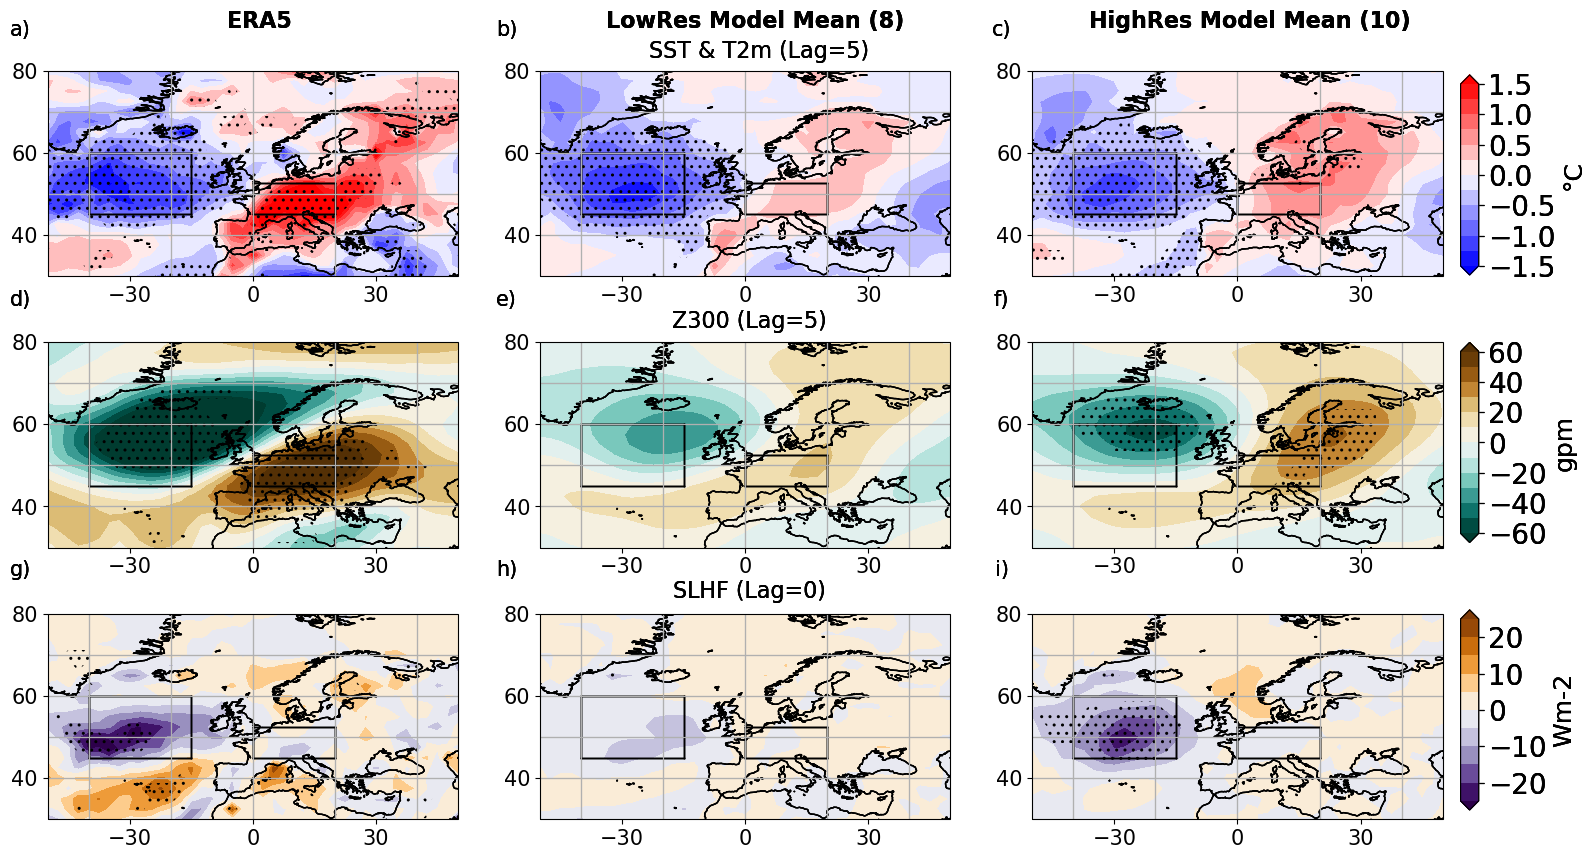

In [38]:
label=['°C','gpm','Wm-2']
levels = [np.linspace(-1.5,1.5,13), np.linspace(-60,60,13), np.linspace(-25,25,11)]
cmap=['bwr', BrBG_cmap, PuOr_cmap]
    
fig = plt.figure(figsize=(18,10), rasterized=True)
axs=[]
for i in range(1,10):
        axs.append(fig.add_subplot(3,3,i, projection=prj))
for v in range(3):
    for mod in range(3):
        if v==0:        
            contf= axs[0].contourf(X,Y, np.c_[HighRes_model_map[model_name[0]+ variable[0]+ resolution[0][0]+'_map'][0].fillna(HighRes_model_map[model_name[0]+ variable[1]+ resolution[0][0]+'_map'][0]).sel(lead_lag=5),HighRes_model_map[model_name[0]+ variable[0]+ resolution[0][0]+'_map'][0].fillna(HighRes_model_map[model_name[0]+ variable[1]+ resolution[0][0]+'_map'][0]).sel(lead_lag=5)[:,0]], cmap=cmap[v], levels=levels[v], extend='both')
            contf= axs[1].contourf(X,Y, np.c_[map_ds[0][0].mean('ensemble').sel(lead_lag=5),map_ds[0][0].mean('ensemble').sel(lead_lag=5)[:,0]], cmap=cmap[v], levels=levels[v], extend='both')
            contf1= axs[2].contourf(X,Y, np.c_[map_ds[0][1].mean('ensemble').sel(lead_lag=5),map_ds[0][1].mean('ensemble').sel(lead_lag=5)[:,0]], cmap=cmap[v], levels=levels[v], extend='both')

            axs[0].contourf(X,Y,(np.c_[bootstrap_mean_quant_025_map_SST_T2m_lag5 [model_name[0]+variable[0]+resolution[0][0]].squeeze(), bootstrap_mean_quant_025_map_SST_T2m_lag5 [model_name[0]+variable[0]+resolution[0][0]].squeeze()[:,0]]) > np.c_[HighRes_model_map[model_name[0]+ variable[0]+ resolution[0][0]+'_map'][0].sel(lead_lag=5).fillna(HighRes_model_map[model_name[0]+ variable[1]+ resolution[0][0]+'_map'][0]).sel(lead_lag=5),HighRes_model_map[model_name[0]+ variable[0]+ resolution[0][0]+'_map'][0].sel(lead_lag=5).fillna(HighRes_model_map[model_name[0]+ variable[1]+ resolution[0][0]+'_map'][0]).sel(lead_lag=5)[:,0]], 1, hatches=['','..'], alpha=0)
            axs[1].contourf(X,Y,(np.c_[LR_SST_T2m_map_025, LR_SST_T2m_map_025[:,0]]) > np.c_[map_ds[0][0].mean('ensemble').sel(lead_lag=5),map_ds[0][0].mean('ensemble').sel(lead_lag=5)[:,0]], 1, hatches=['','..'], alpha=0)
            axs[2].contourf(X,Y,(np.c_[HR_SST_T2m_map_025, HR_SST_T2m_map_025[:,0]]) > np.c_[map_ds[0][1].mean('ensemble').sel(lead_lag=5),map_ds[0][1].mean('ensemble').sel(lead_lag=5)[:,0]], 1, hatches=['','..'], alpha=0)

            axs[0].contourf(X,Y,(np.c_[bootstrap_mean_quant_975_map_SST_T2m_lag5 [model_name[0]+variable[0]+resolution[0][0]].squeeze(), bootstrap_mean_quant_975_map_SST_T2m_lag5 [model_name[0]+variable[0]+resolution[0][0]].squeeze()[:,0]]) < np.c_[HighRes_model_map[model_name[0]+ variable[0]+ resolution[0][0]+'_map'][0].sel(lead_lag=5).fillna(HighRes_model_map[model_name[0]+ variable[1]+ resolution[0][0]+'_map'][0]).sel(lead_lag=5),HighRes_model_map[model_name[0]+ variable[0]+ resolution[0][0]+'_map'][0].sel(lead_lag=5).fillna(HighRes_model_map[model_name[0]+ variable[1]+ resolution[0][0]+'_map'][0]).sel(lead_lag=5)[:,0]], 1, hatches=['','..'], alpha=0)
            axs[1].contourf(X,Y,(np.c_[LR_SST_T2m_map_975, LR_SST_T2m_map_975[:,0]]) < np.c_[map_ds[0][0].mean('ensemble').sel(lead_lag=5),map_ds[0][0].mean('ensemble').sel(lead_lag=5)[:,0]], 1, hatches=['','..'], alpha=0)
            axs[2].contourf(X,Y,(np.c_[HR_SST_T2m_map_975, HR_SST_T2m_map_975[:,0]]) < np.c_[map_ds[0][1].mean('ensemble').sel(lead_lag=5),map_ds[0][1].mean('ensemble').sel(lead_lag=5)[:,0]], 1, hatches=['','..'], alpha=0)
            
            cb_ax = fig.add_axes([0.91, 0.665, 0.01, 0.2])
            cb = fig.colorbar(contf1, cax=cb_ax, orientation='vertical')
            cb.ax.tick_params(labelsize=20)
            cb.set_label(label='°C', size='large')
    
        if v==1:
            contf= axs[3].contourf(X,Y, np.c_[HighRes_model_map[model_name[0]+ variable[2]+ resolution[0][0]+'_map'][0].sel(lead_lag=5),HighRes_model_map[model_name[0]+ variable[2]+ resolution[0][0]+'_map'][0].sel(lead_lag=5)[:,0]], cmap=cmap[v], levels=levels[v], extend='both')
            contf= axs[4].contourf(X,Y, np.c_[map_ds[1][0].mean('ensemble').sel(lead_lag=5),map_ds[1][0].mean('ensemble').sel(lead_lag=5)[:,0]], cmap=cmap[v], levels=levels[v], extend='both')
            contf2= axs[5].contourf(X,Y, np.c_[map_ds[1][1].mean('ensemble').sel(lead_lag=5),map_ds[1][1].mean('ensemble').sel(lead_lag=5)[:,0]], cmap=cmap[v], levels=levels[v], extend='both')

            axs[3].contourf(X,Y,(np.c_[bootstrap_mean_quant_025_map_Z300_lag5 [model_name[0]+variable[2]+resolution[0][0]].squeeze(), bootstrap_mean_quant_025_map_Z300_lag5 [model_name[0]+variable[2]+resolution[0][0]].squeeze()[:,0]])/9.81 > np.c_[HighRes_model_map[model_name[0]+ variable[2]+ resolution[0][0]+'_map'][0].sel(lead_lag=5),HighRes_model_map[model_name[0]+ variable[2]+ resolution[0][0]+'_map'][0].sel(lead_lag=5)[:,0]], 1, hatches=['','..'], alpha=0)
            axs[4].contourf(X,Y,(np.c_[LR_Z300_map_025, LR_Z300_map_025[:,0]]) > np.c_[map_ds[1][0].mean('ensemble').sel(lead_lag=5),map_ds[1][0].mean('ensemble').sel(lead_lag=5)[:,0]], 1, hatches=['','..'], alpha=0)
            axs[5].contourf(X,Y,(np.c_[HR_Z300_map_025, HR_Z300_map_025[:,0]]) > np.c_[map_ds[1][1].mean('ensemble').sel(lead_lag=5),map_ds[1][1].mean('ensemble').sel(lead_lag=5)[:,0]], 1, hatches=['','..'], alpha=0)

            axs[3].contourf(X,Y,(np.c_[bootstrap_mean_quant_975_map_Z300_lag5 [model_name[0]+variable[2]+resolution[0][0]].squeeze(), bootstrap_mean_quant_975_map_Z300_lag5 [model_name[0]+variable[2]+resolution[0][0]].squeeze()[:,0]])/9.81 < np.c_[HighRes_model_map[model_name[0]+ variable[2]+ resolution[0][0]+'_map'][0].sel(lead_lag=5),HighRes_model_map[model_name[0]+ variable[2]+ resolution[0][0]+'_map'][0].sel(lead_lag=5)[:,0]], 1, hatches=['','..'], alpha=0)
            axs[4].contourf(X,Y,(np.c_[LR_Z300_map_975, LR_Z300_map_975[:,0]]) < np.c_[map_ds[1][0].mean('ensemble').sel(lead_lag=5),map_ds[1][0].mean('ensemble').sel(lead_lag=5)[:,0]], 1, hatches=['','..'], alpha=0)
            axs[5].contourf(X,Y,(np.c_[HR_Z300_map_975, HR_Z300_map_975[:,0]]) < np.c_[map_ds[1][1].mean('ensemble').sel(lead_lag=5),map_ds[1][1].mean('ensemble').sel(lead_lag=5)[:,0]], 1, hatches=['','..'], alpha=0)

            cb_ax = fig.add_axes([0.91, 0.3975, 0.01, 0.2])
            cb = fig.colorbar(contf2, cax=cb_ax, orientation='vertical')
            cb.ax.tick_params(labelsize=20)
            cb.set_label(label='gpm', size='large')
            
        if v==2:
            contf= axs[6].contourf(X,Y, np.c_[HighRes_model_map[model_name[0]+ variable[4]+ resolution[0][0]+'_map'][0].sel(lead_lag=0),HighRes_model_map[model_name[0]+ variable[4]+ resolution[0][0]+'_map'][0].sel(lead_lag=0)[:,0]], cmap=cmap[v], levels=levels[v], extend='both')
            contf= axs[7].contourf(X,Y, np.c_[map_ds[3][0].mean('ensemble').sel(lead_lag=0),map_ds[3][0].mean('ensemble').sel(lead_lag=0)[:,0]], cmap=cmap[v], levels=levels[v], extend='both')
            contf3= axs[8].contourf(X,Y, np.c_[map_ds[3][1].mean('ensemble').sel(lead_lag=0),map_ds[3][1].mean('ensemble').sel(lead_lag=0)[:,0]], cmap=cmap[v], levels=levels[v], extend='both')

            
            axs[6].contourf(X,Y,(np.c_[bootstrap_mean_quant_025_map_SLHF_lag0  [model_name[0]+variable[4]+resolution[0][0]].squeeze(), bootstrap_mean_quant_025_map_SLHF_lag0  [model_name[0]+variable[4]+resolution[0][0]].squeeze()[:,0]]) > np.c_[HighRes_model_map[model_name[0]+ variable[4]+ resolution[0][0]+'_map'][0].sel(lead_lag=0),HighRes_model_map[model_name[0]+ variable[4]+ resolution[0][0]+'_map'][0].sel(lead_lag=0)[:,0]], 1, hatches=['','..'], alpha=0)
            axs[7].contourf(X,Y,(np.c_[LR_hfls_map_025, LR_hfls_map_025[:,0]]) > np.c_[map_ds[3][0].mean('ensemble').sel(lead_lag=0),map_ds[3][0].mean('ensemble').sel(lead_lag=0)[:,0]], 1, hatches=['','..'], alpha=0)
            axs[8].contourf(X,Y,(np.c_[HR_hfls_map_025, HR_hfls_map_025[:,0]]) > np.c_[map_ds[3][1].mean('ensemble').sel(lead_lag=0),map_ds[3][1].mean('ensemble').sel(lead_lag=0)[:,0]], 1, hatches=['','..'], alpha=0)

            axs[6].contourf(X,Y,(np.c_[bootstrap_mean_quant_975_map_SLHF_lag0  [model_name[0]+variable[4]+resolution[0][0]].squeeze(), bootstrap_mean_quant_975_map_SLHF_lag0  [model_name[0]+variable[4]+resolution[0][0]].squeeze()[:,0]]) < np.c_[HighRes_model_map[model_name[0]+ variable[4]+ resolution[0][0]+'_map'][0].sel(lead_lag=0),HighRes_model_map[model_name[0]+ variable[4]+ resolution[0][0]+'_map'][0].sel(lead_lag=0)[:,0]], 1, hatches=['','..'], alpha=0)
            axs[7].contourf(X,Y,(np.c_[LR_hfls_map_975, LR_hfls_map_975[:,0]]) < np.c_[map_ds[3][0].mean('ensemble').sel(lead_lag=0),map_ds[3][0].mean('ensemble').sel(lead_lag=0)[:,0]], 1, hatches=['','..'], alpha=0)
            axs[8].contourf(X,Y,(np.c_[HR_hfls_map_975, HR_hfls_map_975[:,0]]) < np.c_[map_ds[3][1].mean('ensemble').sel(lead_lag=0),map_ds[3][1].mean('ensemble').sel(lead_lag=0)[:,0]], 1, hatches=['','..'], alpha=0)
            

            cb_ax = fig.add_axes([0.91, 0.13, 0.01, 0.2])
            cb = fig.colorbar(contf3, cax=cb_ax, orientation='vertical')
            cb.ax.tick_params(labelsize=20)
            cb.set_label(label='Wm-2', size='large')

    plt.figtext(0.245,0.93,"ERA5 ", ha="center", va="top", fontsize=16, weight='bold')
   # plt.figtext(0.52,0.93,"LowRes Model Mean (6) ", ha="center", va="top", fontsize=16, weight='bold')
   #plt.figtext(0.795,0.93,"HighRes Model Mean (6) ", ha="center", va="top", fontsize=16, weight='bold')
    plt.figtext(0.52,0.93,"LowRes Model Mean (8) ", ha="center", va="top", fontsize=16, weight='bold')
    plt.figtext(0.795,0.93,"HighRes Model Mean (10) ", ha="center", va="top", fontsize=16, weight='bold')
    
    plt.figtext(0.52,0.90,"SST & T2m (Lag=5)", ha="center", va="top", fontsize=16)
    plt.figtext(0.515,0.63,"Z300 (Lag=5)", ha="center", va="top", fontsize=16)
    plt.figtext(0.515,0.36,"SLHF (Lag=0)", ha="center", va="top", fontsize=16)

                
    for ax in axs:
        ax.plot(x1, y1, x2, y2,x3,y3,x4,y4,x1_E, y1_E, x2_E, y2_E,x3_E,y3_E,x4_E,y4_E, color='black', linestyle='-', linewidth=1)
        ax.coastlines('50m')
        ax.gridlines()
        ax.set_extent([-50, 50, 30, 80], prj)
        ax.set_xticks([ -30, 0,30],crs=prj)
        ax.set_yticks([40, 60, 80],crs=prj)
    

    plt.figtext(0.11,0.92,"a)", ha="center", va="top")
    plt.figtext(0.38,0.92,"b)", ha="center", va="top")
    plt.figtext(0.655,0.92,"c)", ha="center", va="top")
    plt.figtext(0.11,0.65,"d)", ha="center", va="top")
    plt.figtext(0.38,0.65,"e)", ha="center", va="top")
    plt.figtext(0.655,0.65,"f)", ha="center", va="top")
    plt.figtext(0.11,0.38,"g)", ha="center", va="top")
    plt.figtext(0.38,0.38,"h)", ha="center", va="top")
    plt.figtext(0.655,0.38,"i)", ha="center", va="top")
    
    plt.savefig('figs/fig3.pdf', bbox_inches='tight', dpi=200)

## Scatter plots 

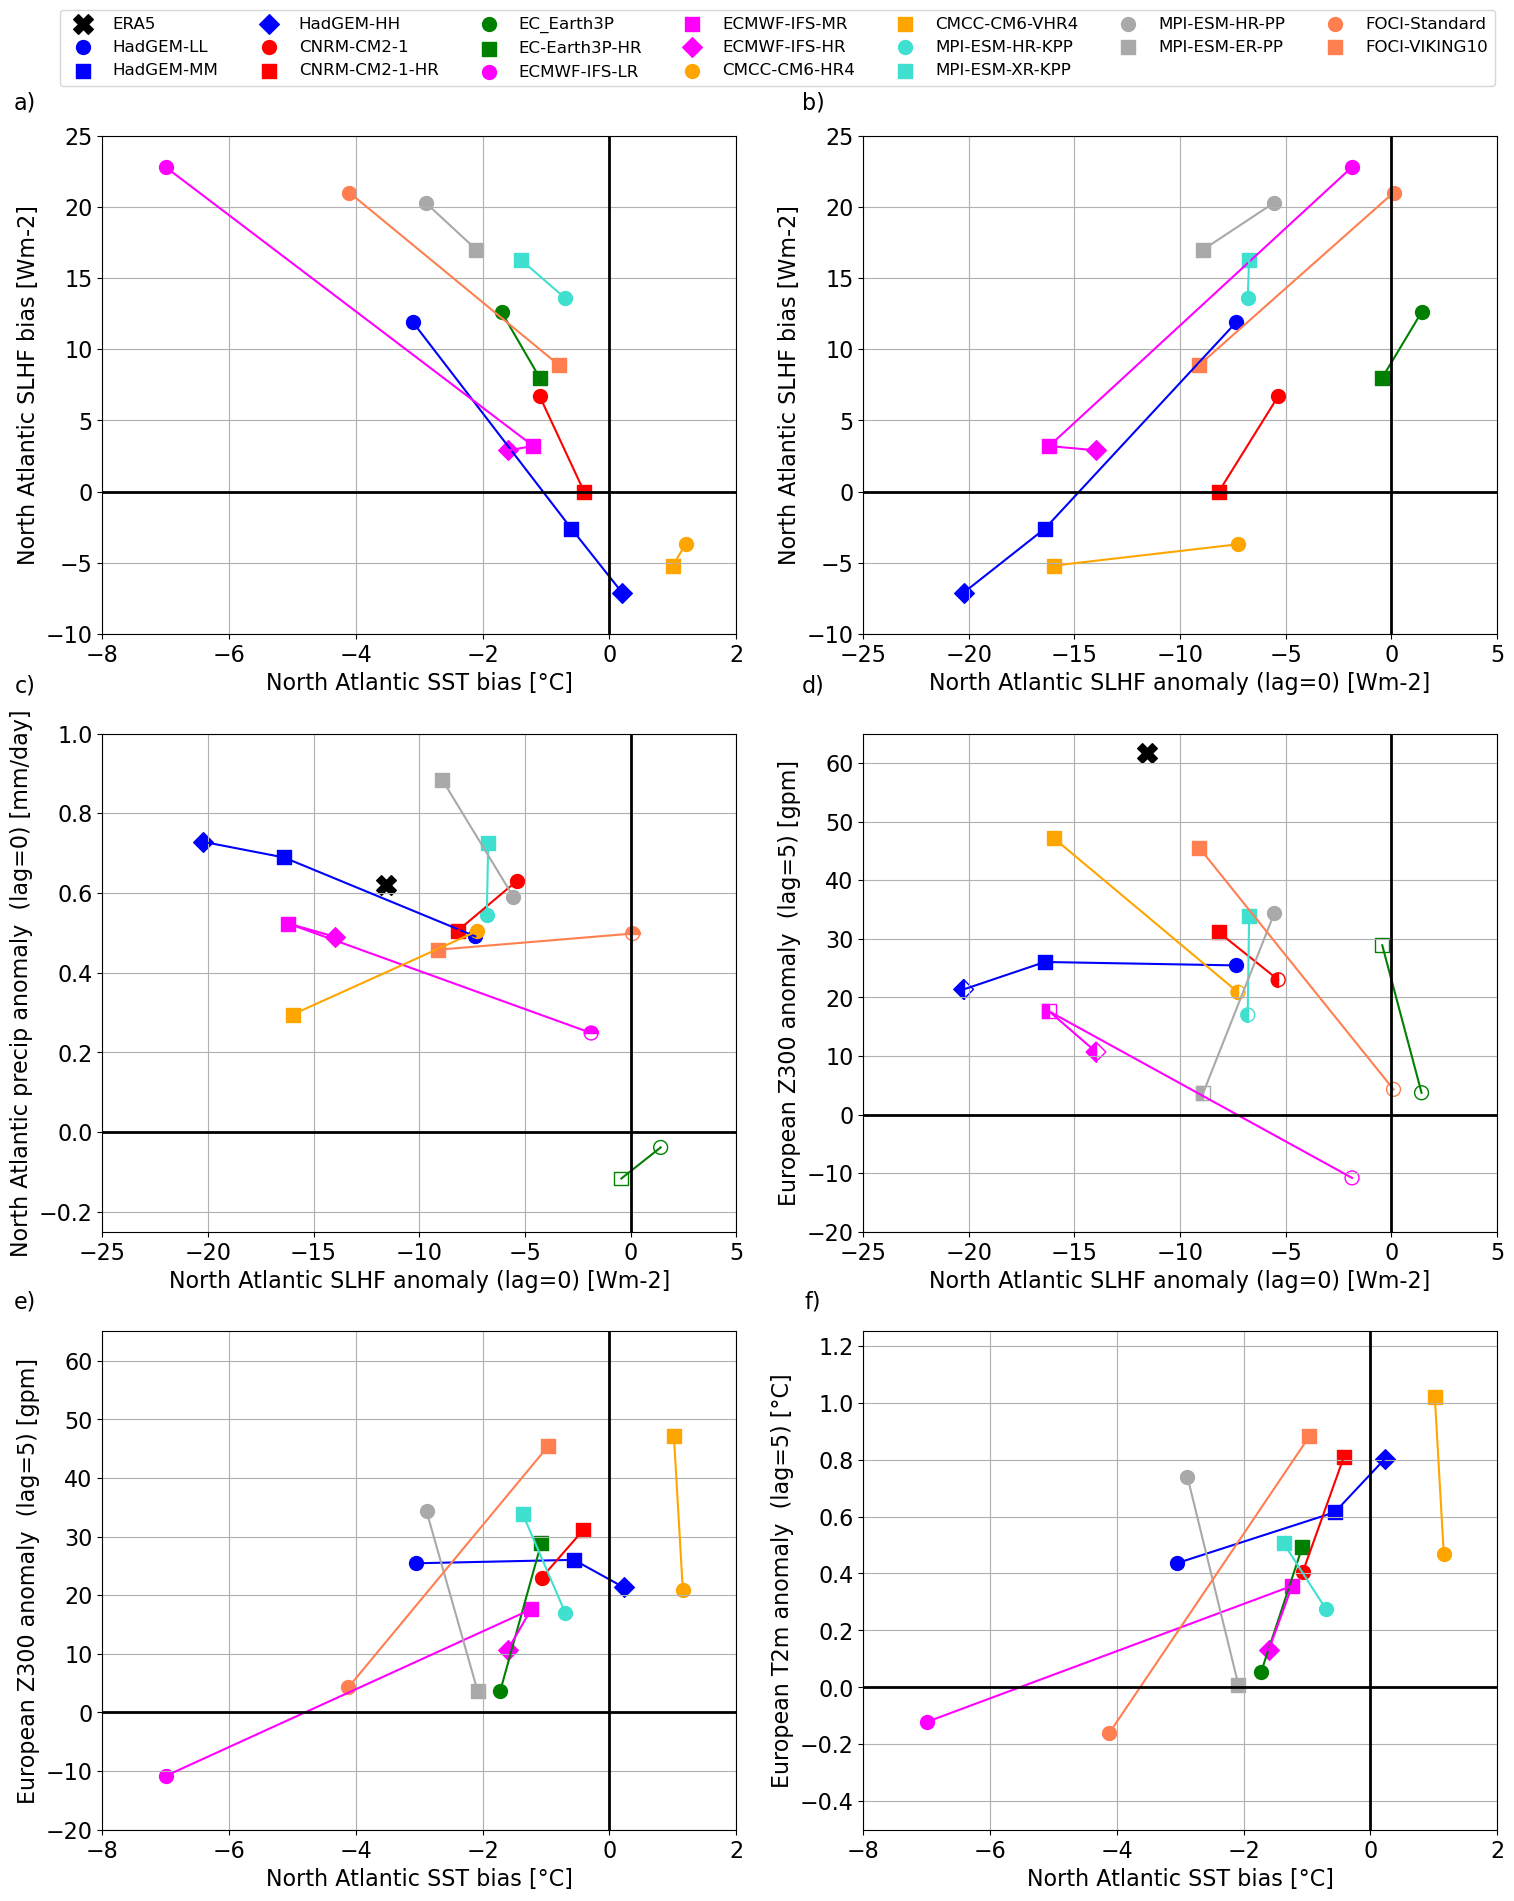

In [19]:
plt.rcParams['font.size'] = '16'

low_res_type = [[1,0], # HadGEM
                [2,0], # CNRM
                [3,0], # EC-Earth
                [4,0], # ECMWF   
                [6,0], # MPI-ESM
                [6,1], # MPI-ESM 
                [6,3], # MPI-ESM 
                [7,0]] # FOCI

high_res_type = [[1,1], # HadGEM
                 [1,2], # HadGEM
                 [2,1], # CNRM
                 [3,1], # EC-Earth
                 [4,1], # ECMWF 
                 [4,2], # ECMWF   
                 [5,0], # CMCC
                 [5,1], # CMCC 
                 [6,2], # MPI-ESM 
                 [7,1]] # FOCI
LR_Atl={}
LR_Euro={}
HR_Atl={}
HR_Euro={}
for v in range(len(variable)):
    LR_Atl [variable[v]] = xr.concat([HighRes_model_Atl_line[model_name [mod]+ variable[v]+ resolution[mod][res]+'_Atl_line'][0] for mod,res in low_res_type], dim='ensemble')
    LR_Euro[variable[v]] = xr.concat([HighRes_model_Euro_line[model_name [mod]+ variable[v]+ resolution[mod][res]+'Euro_line'][0] for mod,res in low_res_type], dim='ensemble')
    HR_Atl [variable[v]] = xr.concat([HighRes_model_Atl_line[model_name [mod]+ variable[v]+ resolution[mod][res]+'_Atl_line'][0] for mod,res in high_res_type], dim='ensemble')
    HR_Euro[variable[v]] = xr.concat([HighRes_model_Euro_line[model_name [mod]+ variable[v]+ resolution[mod][res]+'Euro_line'][0] for mod,res in high_res_type], dim='ensemble')
#print(LR_Atl [variable[3]].sel(lead_lag=0))
LR_region= ['nan','nan',LR_Atl,LR_Euro, LR_Euro, LR_Euro]
HR_region= ['nan','nan',HR_Atl,HR_Euro, HR_Euro, HR_Euro]

fig = plt.figure(figsize=(18,22))
axs=[]
for i in range(1,7):
        axs.append(fig.add_subplot(3,2,i))
# Plot dots for variable 1: hfls over Atlantic at lag 0 against variable 2: zg over Europe at lag=5
var1_lag=0
var2_lag=['nan','nan',0,5,5,5]
#print(Line2D.lineStyles)

var2=['nan','nan',3,2,2,1]
for k in range(6):

    if k==5:  
        axs[k].scatter(-3.05567,  LR_region[k] [variable[var2[k]]][0].sel(lead_lag=var2_lag[k]), s=100,color='blue', marker='o',label='HadGEM-LL')
        axs[k].scatter(-0.56087, HR_region[k] [variable[var2[k]]][0].sel(lead_lag=var2_lag[k]), s=100, color='blue', marker='s',label='HadGEM-MM')
        axs[k].scatter(0.2238, HR_region[k] [variable[var2[k]]][1].sel(lead_lag=var2_lag[k]), s=100, color='blue', marker='D',label='HadGEM-HH')
        
        axs[k].scatter(-1.068, LR_region[k] [variable[var2[k]]][1].sel(lead_lag=var2_lag[k]), s=100, color='red', marker='o',label='CNRM-CM2-1')
        axs[k].scatter(-0.4164, HR_region[k] [variable[var2[k]]][2].sel(lead_lag=var2_lag[k]), s=100, color='red', marker='s',label='CNRM-CM2-1-HR')
        
        axs[k].scatter(-1.720666, LR_region[k] [variable[var2[k]]][2].sel(lead_lag=var2_lag[k]), s=100, color='green', marker='o',label='EC_Earth3P')
        axs[k].scatter(-1.0752807, HR_region[k] [variable[var2[k]]][3].sel(lead_lag=var2_lag[k]), s=100, color='green', marker='s',label='EC-Earth3P-HR')
        
        axs[k].scatter(-6.99227, LR_region[k] [variable[var2[k]]][3].sel(lead_lag=var2_lag[k]), s=100, color='magenta', marker='o',label='ECMWF-IFS-LR')
        axs[k].scatter(-1.234, HR_region[k] [variable[var2[k]]][4].sel(lead_lag=var2_lag[k]), s=100, color='magenta', marker='s',label='ECMWF-IFS-MR')
        axs[k].scatter(-1.6034, HR_region[k] [variable[var2[k]]][5].sel(lead_lag=var2_lag[k]), s=100, color='magenta', marker='D',label='ECMWF-IFS-HR')
        
        axs[k].scatter(1.15754, HR_region[k] [variable[var2[k]]][6].sel(lead_lag=var2_lag[k]), s=100, color='orange', marker='o',label='CMCC-CM6-HR4')
        axs[k].scatter(1.0166, HR_region[k] [variable[var2[k]]][7].sel(lead_lag=var2_lag[k]), s=100, color='orange', marker='s',label='CMCC-CM6-VHR4')
        
        axs[k].scatter(-0.697, LR_region[k] [variable[var2[k]]][4].sel(lead_lag=var2_lag[k]), s=100, color='turquoise', marker='o',label='MPI-ESM-HR-KPP')
        axs[k].scatter(-1.368, LR_region[k] [variable[var2[k]]][5].sel(lead_lag=var2_lag[k]), s=100, color='turquoise', marker='s',label='MPI-ESM-XR-KPP')
        
        axs[k].scatter(-2.884, LR_region[k] [variable[var2[k]]][6].sel(lead_lag=var2_lag[k]), s=100, color='darkgrey', marker='o',label='MPI-ESM-XR-PP')
        axs[k].scatter(-2.080, HR_region[k] [variable[var2[k]]][8].sel(lead_lag=var2_lag[k]), s=100, color='darkgrey', marker='s',label='MPI-ESM-ER-PP')

        axs[k].scatter(-4.116, LR_region[k] [variable[var2[k]]][7].sel(lead_lag=var2_lag[k]), s=100, color='coral', marker='o',label='FOCI-Standard')
        axs[k].scatter(-0.962, HR_region[k] [variable[var2[k]]][9].sel(lead_lag=var2_lag[k]), s=100, color='coral', marker='s',label='FOCI-VIKING10')
        
        #### Plot connections
        axs[k].plot([-3.05567,-0.56087], [LR_region[k] [variable[var2[k]]][0].sel(lead_lag=var2_lag[k]), HR_region[k] [variable[var2[k]]][0].sel(lead_lag=var2_lag[k])], color='blue') # HadGEM
        axs[k].plot([-0.56087, 0.2238], [HR_region[k] [variable[var2[k]]][0].sel(lead_lag=var2_lag[k]),  HR_region[k] [variable[var2[k]]][1].sel(lead_lag=var2_lag[k])], color='blue') # HadGEM
        
        axs[k].plot([-1.068, -0.4164], [LR_region[k] [variable[var2[k]]][1].sel(lead_lag=var2_lag[k]), HR_region[k] [variable[var2[k]]][2].sel(lead_lag=var2_lag[k])], color='red') # CNRM
        
        axs[k].plot([-1.720666, -1.0752807], [LR_region[k] [variable[var2[k]]][2].sel(lead_lag=var2_lag[k]), HR_region[k] [variable[var2[k]]][3].sel(lead_lag=var2_lag[k]) ], color='green') # EC-Earth
        
        axs[k].plot([-6.99227,-1.234], [LR_region[k] [variable[var2[k]]][3].sel(lead_lag=var2_lag[k]), HR_region[k] [variable[var2[k]]][4].sel(lead_lag=var2_lag[k]) ], color='magenta') # ECMWF
        axs[k].plot([-1.234, -1.6034], [HR_region[k] [variable[var2[k]]][4].sel(lead_lag=var2_lag[k]), HR_region[k] [variable[var2[k]]][5].sel(lead_lag=var2_lag[k])], color='magenta') # ECMWF
        
        axs[k].plot([1.15754, 1.0166], [HR_region[k] [variable[var2[k]]][6].sel(lead_lag=var2_lag[k]), HR_region[k] [variable[var2[k]]][7].sel(lead_lag=var2_lag[k]) ], color='orange') # CMCC
        
        axs[k].plot([-0.697, -1.368], [LR_region[k] [variable[var2[k]]][4].sel(lead_lag=var2_lag[k]), LR_region[k] [variable[var2[k]]][5].sel(lead_lag=var2_lag[k])], color='turquoise') # MPI-ESM

        axs[k].plot([-2.884, -2.080], [LR_region[k] [variable[var2[k]]][6].sel(lead_lag=var2_lag[k]), HR_region[k] [variable[var2[k]]][8].sel(lead_lag=var2_lag[k])], color='darkgrey') # MPI-ESM
        
        axs[k].plot([-4.116, -0.962], [LR_region[k] [variable[var2[k]]][7].sel(lead_lag=var2_lag[k]), HR_region[k] [variable[var2[k]]][9].sel(lead_lag=var2_lag[k])], color='coral') # FOCI
    
    if k==4:  
        axs[k].scatter(-3.05567,  LR_region[k] [variable[var2[k]]][0].sel(lead_lag=var2_lag[k]), s=100,color='blue', marker='o',label='HadGEM-LL')
        axs[k].scatter(-0.56087, HR_region[k] [variable[var2[k]]][0].sel(lead_lag=var2_lag[k]), s=100, color='blue', marker='s',label='HadGEM-MM')
        axs[k].scatter(0.2238, HR_region[k] [variable[var2[k]]][1].sel(lead_lag=var2_lag[k]), s=100, color='blue', marker='D',label='HadGEM-HH')
        
        axs[k].scatter(-1.068, LR_region[k] [variable[var2[k]]][1].sel(lead_lag=var2_lag[k]), s=100, color='red', marker='o',label='CNRM-CM2-1')
        axs[k].scatter(-0.4164, HR_region[k] [variable[var2[k]]][2].sel(lead_lag=var2_lag[k]), s=100, color='red', marker='s',label='CNRM-CM2-1-HR')
        
        axs[k].scatter(-1.720666, LR_region[k] [variable[var2[k]]][2].sel(lead_lag=var2_lag[k]), s=100, color='green', marker='o',label='EC_Earth3P')
        axs[k].scatter(-1.0752807, HR_region[k] [variable[var2[k]]][3].sel(lead_lag=var2_lag[k]), s=100, color='green', marker='s',label='EC-Earth3P-HR')
        
        axs[k].scatter(-6.99227, LR_region[k] [variable[var2[k]]][3].sel(lead_lag=var2_lag[k]), s=100, color='magenta', marker='o',label='ECMWF-IFS-LR')
        axs[k].scatter(-1.234, HR_region[k] [variable[var2[k]]][4].sel(lead_lag=var2_lag[k]), s=100, color='magenta', marker='s',label='ECMWF-IFS-MR')
        axs[k].scatter(-1.6034, HR_region[k] [variable[var2[k]]][5].sel(lead_lag=var2_lag[k]), s=100, color='magenta', marker='D',label='ECMWF-IFS-HR')
        
        axs[k].scatter(1.15754, HR_region[k] [variable[var2[k]]][6].sel(lead_lag=var2_lag[k]), s=100, color='orange', marker='o',label='CMCC-CM6-HR4')
        axs[k].scatter(1.0166, HR_region[k] [variable[var2[k]]][7].sel(lead_lag=var2_lag[k]), s=100, color='orange', marker='s',label='CMCC-CM6-VHR4')
        
        axs[k].scatter(-0.697, LR_region[k] [variable[var2[k]]][4].sel(lead_lag=var2_lag[k]), s=100, color='turquoise', marker='o',label='MPI-ESM-HR-KPP')
        axs[k].scatter(-1.368, LR_region[k] [variable[var2[k]]][5].sel(lead_lag=var2_lag[k]), s=100, color='turquoise', marker='s',label='MPI-ESM-XR-KPP')

        axs[k].scatter(-2.884, LR_region[k] [variable[var2[k]]][6].sel(lead_lag=var2_lag[k]), s=100, color='darkgrey', marker='o',label='MPI-ESM-HR-PP')
        axs[k].scatter(-2.080, HR_region[k] [variable[var2[k]]][8].sel(lead_lag=var2_lag[k]), s=100, color='darkgrey', marker='s',label='MPI-ESM-ER-PP')

        axs[k].scatter(-4.116, LR_region[k] [variable[var2[k]]][7].sel(lead_lag=var2_lag[k]), s=100, color='coral', marker='o',label='FOCI-Standard')
        axs[k].scatter(-0.962, HR_region[k] [variable[var2[k]]][9].sel(lead_lag=var2_lag[k]), s=100, color='coral', marker='s',label='FOCI-VIKING10')
        
        #### Plot connections
        axs[k].plot([-3.05567,-0.56087], [LR_region[k] [variable[var2[k]]][0].sel(lead_lag=var2_lag[k]), HR_region[k] [variable[var2[k]]][0].sel(lead_lag=var2_lag[k])], color='blue') # HadGEM
        axs[k].plot([-0.56087, 0.2238], [HR_region[k] [variable[var2[k]]][0].sel(lead_lag=var2_lag[k]),  HR_region[k] [variable[var2[k]]][1].sel(lead_lag=var2_lag[k])], color='blue') # HadGEM
        
        axs[k].plot([-1.068, -0.4164], [LR_region[k] [variable[var2[k]]][1].sel(lead_lag=var2_lag[k]), HR_region[k] [variable[var2[k]]][2].sel(lead_lag=var2_lag[k])], color='red') # CNRM
        
        axs[k].plot([-1.720666, -1.0752807], [LR_region[k] [variable[var2[k]]][2].sel(lead_lag=var2_lag[k]), HR_region[k] [variable[var2[k]]][3].sel(lead_lag=var2_lag[k]) ], color='green') # EC-Earth
        
        axs[k].plot([-6.99227,-1.234], [LR_region[k] [variable[var2[k]]][3].sel(lead_lag=var2_lag[k]), HR_region[k] [variable[var2[k]]][4].sel(lead_lag=var2_lag[k]) ], color='magenta') # ECMWF
        axs[k].plot([-1.234, -1.6034], [HR_region[k] [variable[var2[k]]][4].sel(lead_lag=var2_lag[k]), HR_region[k] [variable[var2[k]]][5].sel(lead_lag=var2_lag[k])], color='magenta') # ECMWF
        
        axs[k].plot([1.15754, 1.0166], [HR_region[k] [variable[var2[k]]][6].sel(lead_lag=var2_lag[k]), HR_region[k] [variable[var2[k]]][7].sel(lead_lag=var2_lag[k]) ], color='orange') # CMCC
        
        axs[k].plot([-0.697, -1.368], [LR_region[k] [variable[var2[k]]][4].sel(lead_lag=var2_lag[k]), LR_region[k] [variable[var2[k]]][5].sel(lead_lag=var2_lag[k])], color='turquoise') # MPI-ESM
        
        axs[k].plot([-2.884, -2.080], [LR_region[k] [variable[var2[k]]][6].sel(lead_lag=var2_lag[k]), HR_region[k] [variable[var2[k]]][8].sel(lead_lag=var2_lag[k])], color='darkgrey') # MPI-ESM
        
        axs[k].plot([-4.116, -0.962], [LR_region[k] [variable[var2[k]]][7].sel(lead_lag=var2_lag[k]), HR_region[k] [variable[var2[k]]][9].sel(lead_lag=var2_lag[k])], color='coral') # FOCI
        
    
    if k==3:
        axs[k].scatter(HighRes_model_Atl_line[model_name [0]+ variable[4]+ resolution[0][0]+'_Atl_line'][0].sel(lead_lag=var1_lag), HighRes_model_Euro_line[model_name [0]+ variable[var2[k]]+ resolution[0][0]+'Euro_line'][0].sel(lead_lag=var2_lag[k]), s=200, color='black', marker='X',label='ERA5')   #  , color =color[v][0], label='ERA5', ls=style[0][0], lw=4)

        axs[k].scatter(LR_Atl [variable[4]][0].sel(lead_lag=var1_lag), LR_region[k] [variable[var2[k]]][0].sel(lead_lag=var2_lag[k]), s=100,color='blue', marker='o', label='HadGEM-LL')  
        axs[k].scatter(HR_Atl [variable[4]][0].sel(lead_lag=var1_lag), HR_region[k] [variable[var2[k]]][0].sel(lead_lag=var2_lag[k]), s=100, color='blue', marker='s',label='HadGEM-MM')
        axs[k].scatter(HR_Atl [variable[4]][1].sel(lead_lag=var1_lag), HR_region[k] [variable[var2[k]]][1].sel(lead_lag=var2_lag[k]), s=100, color='blue',marker=MarkerStyle('D', fillstyle='left'), label='HadGEM-HH')
        axs[k].scatter(HR_Atl [variable[4]][1].sel(lead_lag=var1_lag), HR_region[k] [variable[var2[k]]][1].sel(lead_lag=var2_lag[k]), s=100, color='blue', marker='D', facecolors='none', label='HadGEM-HH')

        axs[k].scatter(LR_Atl [variable[4]][1].sel(lead_lag=var1_lag), LR_region[k] [variable[var2[k]]][1].sel(lead_lag=var2_lag[k]), s=100, color='red', marker=MarkerStyle('o', fillstyle='left'),label='CNRM-CM2-1')
        axs[k].scatter(LR_Atl [variable[4]][1].sel(lead_lag=var1_lag), LR_region[k] [variable[var2[k]]][1].sel(lead_lag=var2_lag[k]), s=100, color='red', marker='o', facecolors='none',label='CNRM-CM2-1')
        axs[k].scatter(HR_Atl [variable[4]][2].sel(lead_lag=var1_lag), HR_region[k] [variable[var2[k]]][2].sel(lead_lag=var2_lag[k]), s=100, color='red', marker='s',label='CNRM-CM2-1-HR')
        
        axs[k].scatter(LR_Atl [variable[4]][2].sel(lead_lag=var1_lag), LR_region[k] [variable[var2[k]]][2].sel(lead_lag=var2_lag[k]), s=100, color='green', marker='o', facecolors='none',label='EC_Earth3P')
        axs[k].scatter(HR_Atl [variable[4]][3].sel(lead_lag=var1_lag), HR_region[k] [variable[var2[k]]][3].sel(lead_lag=var2_lag[k]), s=100, color='green', marker='s', facecolors='none',label='EC-Earth3P-HR')
        
        axs[k].scatter(LR_Atl [variable[4]][3].sel(lead_lag=var1_lag), LR_region[k] [variable[var2[k]]][3].sel(lead_lag=var2_lag[k]), s=100, color='magenta', marker='o', facecolors='none',label='ECMWF-IFS-LR')
        axs[k].scatter(HR_Atl [variable[4]][4].sel(lead_lag=var1_lag), HR_region[k] [variable[var2[k]]][4].sel(lead_lag=var2_lag[k]), s=100, color='magenta', marker='s', facecolors='none',label='ECMWF-IFS-MR')
        axs[k].scatter(HR_Atl [variable[4]][4].sel(lead_lag=var1_lag), HR_region[k] [variable[var2[k]]][4].sel(lead_lag=var2_lag[k]), s=100, color='magenta', marker=MarkerStyle('s', fillstyle='left'),label='ECMWF-IFS-MR')
        axs[k].scatter(HR_Atl [variable[4]][5].sel(lead_lag=var1_lag), HR_region[k] [variable[var2[k]]][5].sel(lead_lag=var2_lag[k]), s=100, color='magenta', marker='D', facecolors='none',label='ECMWF-IFS-HR')
        axs[k].scatter(HR_Atl [variable[4]][5].sel(lead_lag=var1_lag), HR_region[k] [variable[var2[k]]][5].sel(lead_lag=var2_lag[k]), s=100, color='magenta', marker=MarkerStyle('D', fillstyle='left'),label='ECMWF-IFS-HR')

        axs[k].scatter(HR_Atl [variable[4]][6].sel(lead_lag=var1_lag), HR_region[k] [variable[var2[k]]][6].sel(lead_lag=var2_lag[k]), s=100, color='orange', marker='o', facecolors='none', label='CMCC-CM6-HR4')
        axs[k].scatter(HR_Atl [variable[4]][6].sel(lead_lag=var1_lag), HR_region[k] [variable[var2[k]]][6].sel(lead_lag=var2_lag[k]), s=100, color='orange', marker=MarkerStyle('o', fillstyle='left'),label='CMCC-CM6-HR4')
        axs[k].scatter(HR_Atl [variable[4]][7].sel(lead_lag=var1_lag), HR_region[k] [variable[var2[k]]][7].sel(lead_lag=var2_lag[k]), s=100, color='orange', marker='s',label='CMCC-CM6-VHR4')
        
        axs[k].scatter(LR_Atl [variable[4]][4].sel(lead_lag=var1_lag), LR_region[k] [variable[var2[k]]][4].sel(lead_lag=var2_lag[k]), s=100, color='turquoise', marker='o',  facecolors='none',label='MPI-ESM-HR-KPP')
        axs[k].scatter(LR_Atl [variable[4]][4].sel(lead_lag=var1_lag), LR_region[k] [variable[var2[k]]][4].sel(lead_lag=var2_lag[k]), s=100, color='turquoise', marker=MarkerStyle('o', fillstyle='left'),label='MPI-ESM-HR-KPP')
        axs[k].scatter(LR_Atl [variable[4]][5].sel(lead_lag=var1_lag), LR_region[k] [variable[var2[k]]][5].sel(lead_lag=var2_lag[k]), s=100, color='turquoise', marker='s',label='MPI-ESM-XR-KPP')

        axs[k].scatter(LR_Atl [variable[4]][6].sel(lead_lag=var1_lag), LR_region[k] [variable[var2[k]]][6].sel(lead_lag=var2_lag[k]), s=100, color='darkgrey', marker='o',label='MPI-ESM-HR-PP')
        axs[k].scatter(HR_Atl [variable[4]][8].sel(lead_lag=var1_lag), HR_region[k] [variable[var2[k]]][8].sel(lead_lag=var2_lag[k]), s=100, color='darkgrey', marker='s',  facecolors='none',label='MPI-ESM-ER-PP')
        axs[k].scatter(HR_Atl [variable[4]][8].sel(lead_lag=var1_lag), HR_region[k] [variable[var2[k]]][8].sel(lead_lag=var2_lag[k]), s=100, color='darkgrey', marker=MarkerStyle('s', fillstyle='left'),label='MPI-ESM-ER-PP')
        
        axs[k].scatter(LR_Atl [variable[4]][7].sel(lead_lag=var1_lag), LR_region[k] [variable[var2[k]]][7].sel(lead_lag=var2_lag[k]), s=100, color='coral', marker='o', facecolors='none', label='FOCI-Standard')
        axs[k].scatter(HR_Atl [variable[4]][9].sel(lead_lag=var1_lag), HR_region[k] [variable[var2[k]]][9].sel(lead_lag=var2_lag[k]), s=100, color='coral', marker='s',label='FOCI-VIKING10')
        
        #### Plot connections
        axs[k].plot([LR_Atl [variable[4]][0].sel(lead_lag=var1_lag), HR_Atl [variable[4]][0].sel(lead_lag=var1_lag)], [LR_region[k] [variable[var2[k]]][0].sel(lead_lag=var2_lag[k]),HR_region[k] [variable[var2[k]]][0].sel(lead_lag=var2_lag[k]) ], color='blue') # HadGEM
        axs[k].plot([HR_Atl [variable[4]][0].sel(lead_lag=var1_lag), HR_Atl [variable[4]][1].sel(lead_lag=var1_lag)], [HR_region[k] [variable[var2[k]]][0].sel(lead_lag=var2_lag[k]),HR_region[k] [variable[var2[k]]][1].sel(lead_lag=var2_lag[k]) ], color='blue') # HadGEM
        
        axs[k].plot([LR_Atl [variable[4]][1].sel(lead_lag=var1_lag), HR_Atl [variable[4]][2].sel(lead_lag=var1_lag)], [LR_region[k] [variable[var2[k]]][1].sel(lead_lag=var2_lag[k]),HR_region[k] [variable[var2[k]]][2].sel(lead_lag=var2_lag[k]) ], color='red') # CNRM
        
        axs[k].plot([LR_Atl [variable[4]][2].sel(lead_lag=var1_lag), HR_Atl [variable[4]][3].sel(lead_lag=var1_lag)], [LR_region[k] [variable[var2[k]]][2].sel(lead_lag=var2_lag[k]),HR_region[k] [variable[var2[k]]][3].sel(lead_lag=var2_lag[k]) ], color='green') # EC-Earth
        
        axs[k].plot([LR_Atl [variable[4]][3].sel(lead_lag=var1_lag), HR_Atl [variable[4]][4].sel(lead_lag=var1_lag)], [LR_region[k] [variable[var2[k]]][3].sel(lead_lag=var2_lag[k]),HR_region[k] [variable[var2[k]]][4].sel(lead_lag=var2_lag[k]) ], color='magenta') # ECMWF
        axs[k].plot([HR_Atl [variable[4]][4].sel(lead_lag=var1_lag), HR_Atl [variable[4]][5].sel(lead_lag=var1_lag)], [HR_region[k] [variable[var2[k]]][4].sel(lead_lag=var2_lag[k]),HR_region[k] [variable[var2[k]]][5].sel(lead_lag=var2_lag[k]) ], color='magenta') # ECMWF
        
        axs[k].plot([HR_Atl [variable[4]][6].sel(lead_lag=var1_lag), HR_Atl [variable[4]][7].sel(lead_lag=var1_lag)], [HR_region[k] [variable[var2[k]]][6].sel(lead_lag=var2_lag[k]),HR_region[k] [variable[var2[k]]][7].sel(lead_lag=var2_lag[k]) ], color='orange') # CMCC
        
        axs[k].plot([LR_Atl [variable[4]][4].sel(lead_lag=var1_lag), LR_Atl [variable[4]][5].sel(lead_lag=var1_lag)], [LR_region[k] [variable[var2[k]]][4].sel(lead_lag=var2_lag[k]),LR_region[k] [variable[var2[k]]][5].sel(lead_lag=var2_lag[k]) ], color='turquoise') # MPI-ESM

        axs[k].plot([LR_Atl [variable[4]][6].sel(lead_lag=var1_lag), HR_Atl [variable[4]][8].sel(lead_lag=var1_lag)], [LR_region[k] [variable[var2[k]]][6].sel(lead_lag=var2_lag[k]),HR_region[k] [variable[var2[k]]][8].sel(lead_lag=var2_lag[k]) ], color='darkgrey') # MPI-ESM
        
        axs[k].plot([LR_Atl [variable[4]][7].sel(lead_lag=var1_lag), HR_Atl [variable[4]][9].sel(lead_lag=var1_lag)], [LR_region[k] [variable[var2[k]]][7].sel(lead_lag=var2_lag[k]),HR_region[k] [variable[var2[k]]][9].sel(lead_lag=var2_lag[k]) ], color='coral') # FOCI
        
        ### Bootstrap method
        #axs[k].plot([HighRes_model_Atl_line[model_name [0]+ variable[4]+ resolution[0][0]+'_Atl_line'][0].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_025[model_name [0]+ variable[4]+ resolution[0][0]].sel(lead_lag=0)],
        #             [HighRes_model_Euro_line[model_name [0]+ variable[2]+ resolution[0][0]+'Euro_line'][0].sel(lead_lag=5),
        #            bootstrap_mean_quant_Euro_975[model_name [0]+ variable[2]+ resolution[0][0]].sel(lead_lag=5)], color='black', ls='--')
        
        #axs[k].plot([LR_Atl [variable[4]][0].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_975[model_name [1]+ variable[4]+ resolution[1][0]].sel(lead_lag=0)],
        #             [LR_Euro [variable[2]][0].sel(lead_lag=5),
        #           bootstrap_mean_quant_Euro_975[model_name [1]+ variable[2]+ resolution[1][0]].sel(lead_lag=5)], color='blue', ls='--')

        #axs[k].plot([HR_Atl [variable[4]][0].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_975[model_name [1]+ variable[4]+ resolution[1][1]].sel(lead_lag=0)],
        #             [HR_Euro [variable[2]][0].sel(lead_lag=5),
        #            bootstrap_mean_quant_Euro_975[model_name [1]+ variable[2]+ resolution[1][1]].sel(lead_lag=5)], color='blue', ls='--')

        #axs[k].plot([HR_Atl [variable[4]][1].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_975[model_name [1]+ variable[4]+ resolution[1][2]].sel(lead_lag=0)],
        #             [HR_Euro [variable[2]][1].sel(lead_lag=5),
        #            bootstrap_mean_quant_Euro_975[model_name [1]+ variable[2]+ resolution[1][2]].sel(lead_lag=5)], color='blue', ls='--')
        
        #axs[k].plot([LR_Atl [variable[4]][1].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_975[model_name [2]+ variable[4]+ resolution[2][0]].sel(lead_lag=0)],
        #             [LR_Euro [variable[2]][1].sel(lead_lag=5),
        #            bootstrap_mean_quant_Euro_975[model_name [2]+ variable[2]+ resolution[2][0]].sel(lead_lag=5)], color='red', ls='--')

        #axs[k].plot([HR_Atl [variable[4]][2].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_975[model_name [2]+ variable[4]+ resolution[2][1]].sel(lead_lag=0)],
        #             [HR_Euro [variable[2]][2].sel(lead_lag=5),
        #            bootstrap_mean_quant_Euro_975[model_name [2]+ variable[2]+ resolution[2][1]].sel(lead_lag=5)], color='red', ls='--')

        #axs[k].plot([LR_Atl [variable[4]][2].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_975[model_name [3]+ variable[4]+ resolution[3][0]].sel(lead_lag=0)],
        #             [LR_Euro [variable[2]][2].sel(lead_lag=5),
        #            bootstrap_mean_quant_Euro_975[model_name [3]+ variable[2]+ resolution[3][0]].sel(lead_lag=5)], color='green', ls='--')

        #axs[k].plot([HR_Atl [variable[4]][3].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_975[model_name [3]+ variable[4]+ resolution[3][1]].sel(lead_lag=0)],
        #             [HR_Euro [variable[2]][3].sel(lead_lag=5),
        #            bootstrap_mean_quant_Euro_975[model_name [3]+ variable[2]+ resolution[3][1]].sel(lead_lag=5)], color='green', ls='--')

        #axs[k].plot([LR_Atl [variable[4]][3].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_975[model_name [4]+ variable[4]+ resolution[4][0]].sel(lead_lag=0)],
        #             [LR_Euro [variable[2]][3].sel(lead_lag=5),
        #            bootstrap_mean_quant_Euro_975[model_name [4]+ variable[2]+ resolution[4][0]].sel(lead_lag=5)], color='magenta', ls='--')

        #axs[k].plot([HR_Atl [variable[4]][4].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_975[model_name [4]+ variable[4]+ resolution[4][1]].sel(lead_lag=0)],
        #             [HR_Euro [variable[2]][4].sel(lead_lag=5),
        #            bootstrap_mean_quant_Euro_975[model_name [4]+ variable[2]+ resolution[4][1]].sel(lead_lag=5)], color='magenta', ls='--')

        #axs[k].plot([HR_Atl [variable[4]][5].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_975[model_name [4]+ variable[4]+ resolution[4][2]].sel(lead_lag=0)],
        #             [HR_Euro [variable[2]][5].sel(lead_lag=5),
        #            bootstrap_mean_quant_Euro_975[model_name [4]+ variable[2]+ resolution[4][2]].sel(lead_lag=5)], color='magenta', ls='--')

        #axs[k].plot([HR_Atl [variable[4]][6].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_975[model_name [5]+ variable[4]+ resolution[5][0]].sel(lead_lag=0)],
        #             [HR_Euro [variable[2]][6].sel(lead_lag=5),
        #            bootstrap_mean_quant_Euro_975[model_name [5]+ variable[2]+ resolution[5][0]].sel(lead_lag=5)], color='orange', ls='--')
        #axs[k].plot([HR_Atl [variable[4]][7].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_975[model_name [5]+ variable[4]+ resolution[5][1]].sel(lead_lag=0)],
        #             [HR_Euro [variable[2]][7].sel(lead_lag=5),
        #            bootstrap_mean_quant_Euro_975[model_name [5]+ variable[2]+ resolution[5][1]].sel(lead_lag=5)], color='orange', ls='--')
 
        #axs[k].plot([LR_Atl [variable[4]][4].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_975[model_name [6]+ variable[4]+ resolution[6][0]].sel(lead_lag=0)],
        #            [LR_Euro [variable[2]][4].sel(lead_lag=5),
        #            bootstrap_mean_quant_Euro_975[model_name [6]+ variable[2]+ resolution[6][0]].sel(lead_lag=5)], color='turquoise', ls='--')

        #axs[k].plot([LR_Atl [variable[4]][5].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_975[model_name [6]+ variable[4]+ resolution[6][1]].sel(lead_lag=0)],
        #             [LR_Euro [variable[2]][5].sel(lead_lag=5),
        #            bootstrap_mean_quant_Euro_975[model_name [6]+ variable[2]+ resolution[6][1]].sel(lead_lag=5)], color='turquoise', ls='--')

        #axs[k].plot([LR_Atl [variable[4]][6].sel(lead_lag=0), 
        #             bootstrap_mean_quant_MPI_Atl_975[model_name [6]+ variable[4]+ resolution[6][3]].sel(lead_lag=0)],
        #             [LR_Euro [variable[2]][6].sel(lead_lag=5),
        #            bootstrap_mean_quant_MPI_Euro_975[model_name [6]+ variable[2]+ resolution[6][3]].sel(lead_lag=5)], color='turquoise', ls='--')

        #axs[k].plot([HR_Atl [variable[4]][8].sel(lead_lag=0), 
        #             bootstrap_mean_quant_MPI_Atl_975[model_name [6]+ variable[4]+ resolution[6][2]].sel(lead_lag=0)],
        #             [HR_Euro [variable[2]][8].sel(lead_lag=5),
        #            bootstrap_mean_quant_MPI_Euro_975[model_name [6]+ variable[2]+ resolution[6][2]].sel(lead_lag=5)], color='turquoise', ls='--')

        #axs[k].plot([LR_Atl [variable[4]][6].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_025[model_name [7]+ variable[4]+ resolution[7][0]].sel(lead_lag=0)],
        #             [LR_Euro [variable[2]][6].sel(lead_lag=5),
        #            bootstrap_mean_quant_Euro_975[model_name [7]+ variable[2]+ resolution[7][0]].sel(lead_lag=5)], color='coral', ls='--')

        #axs[k].plot([HR_Atl [variable[4]][8].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_025[model_name [7]+ variable[4]+ resolution[7][1]].sel(lead_lag=0)],
        #             [HR_Euro [variable[2]][8].sel(lead_lag=5),
        #            bootstrap_mean_quant_Euro_975[model_name [7]+ variable[2]+ resolution[7][1]].sel(lead_lag=5)], color='coral', ls='--')
        
       # print(bootstrap_mean_quant_Euro_975[model_name [6]+ variable[2]+ resolution[6][1]].sel(lead_lag=5))
        #HighRes_model_Euro_line[model_name [0]+ variable[var2[k]]+ resolution[0][0]+'Euro_line'][0].sel(lead_lag=var2_lag[k]), s=100, color='black', marker='X',label='ERA5')   #  , color =color[v][0], label='ERA5', ls=style[0][0], lw=4)

        #bootstrap_mean_quant_Euro_975[model_name [0]+ variable[2]+ resolution[0][0]].sel(lead_lag=5)
        
    if k==2:
        axs[k].scatter(HighRes_model_Atl_line[model_name [0]+ variable[4]+ resolution[0][0]+'_Atl_line'][0].sel(lead_lag=var1_lag), HighRes_model_Atl_line[model_name [0]+ variable[var2[k]]+ resolution[0][0]+'_Atl_line'][0].sel(lead_lag=var2_lag[k]), s=200, color='black', marker='X',label='ERA5')   #  , color =color[v][0], label='ERA5', ls=style[0][0], lw=4)

        axs[k].scatter(LR_Atl [variable[4]][0].sel(lead_lag=var1_lag), LR_region[k] [variable[var2[k]]][0].sel(lead_lag=var2_lag[k]), s=100,color='blue', marker='o',label='HadGEM-LL')  
        axs[k].scatter(HR_Atl [variable[4]][0].sel(lead_lag=var1_lag), HR_region[k] [variable[var2[k]]][0].sel(lead_lag=var2_lag[k]), s=100, color='blue', marker='s',label='HadGEM-MM')
        axs[k].scatter(HR_Atl [variable[4]][1].sel(lead_lag=var1_lag), HR_region[k] [variable[var2[k]]][1].sel(lead_lag=var2_lag[k]), s=100, color='blue', marker='D',label='HadGEM-HH')
        
        axs[k].scatter(LR_Atl [variable[4]][1].sel(lead_lag=var1_lag), LR_region[k] [variable[var2[k]]][1].sel(lead_lag=var2_lag[k]), s=100, color='red', marker='o',label='CNRM-CM2-1')
        axs[k].scatter(HR_Atl [variable[4]][2].sel(lead_lag=var1_lag), HR_region[k] [variable[var2[k]]][2].sel(lead_lag=var2_lag[k]), s=100, color='red', marker='s',label='CNRM-CM2-1-HR')
        
        axs[k].scatter(LR_Atl [variable[4]][2].sel(lead_lag=var1_lag), LR_region[k] [variable[var2[k]]][2].sel(lead_lag=var2_lag[k]), s=100, color='green', marker='o', facecolors='none',label='EC_Earth3P')
        axs[k].scatter(HR_Atl [variable[4]][3].sel(lead_lag=var1_lag), HR_region[k] [variable[var2[k]]][3].sel(lead_lag=var2_lag[k]), s=100, color='green', marker='s', facecolors='none',label='EC-Earth3P-HR')
        
        axs[k].scatter(LR_Atl [variable[4]][3].sel(lead_lag=var1_lag), LR_region[k] [variable[var2[k]]][3].sel(lead_lag=var2_lag[k]), s=100, color='magenta', marker='o', facecolors='none',label='ECMWF-IFS-LR')
        axs[k].scatter(LR_Atl [variable[4]][3].sel(lead_lag=var1_lag), LR_region[k] [variable[var2[k]]][3].sel(lead_lag=var2_lag[k]), s=100, color='magenta', marker=MarkerStyle('o', fillstyle='top'),label='ECMWF-IFS-LR')
        axs[k].scatter(HR_Atl [variable[4]][4].sel(lead_lag=var1_lag), HR_region[k] [variable[var2[k]]][4].sel(lead_lag=var2_lag[k]), s=100, color='magenta', marker='s',label='ECMWF-IFS-MR')
        axs[k].scatter(HR_Atl [variable[4]][5].sel(lead_lag=var1_lag), HR_region[k] [variable[var2[k]]][5].sel(lead_lag=var2_lag[k]), s=100, color='magenta', marker='D',label='ECMWF-IFS-HR')
        
        axs[k].scatter(HR_Atl [variable[4]][6].sel(lead_lag=var1_lag), HR_region[k] [variable[var2[k]]][6].sel(lead_lag=var2_lag[k]), s=100, color='orange', marker='o',label='CMCC-CM6-HR4')
        axs[k].scatter(HR_Atl [variable[4]][7].sel(lead_lag=var1_lag), HR_region[k] [variable[var2[k]]][7].sel(lead_lag=var2_lag[k]), s=100, color='orange', marker='s',label='CMCC-CM6-VHR4')
        
        axs[k].scatter(LR_Atl [variable[4]][4].sel(lead_lag=var1_lag), LR_region[k] [variable[var2[k]]][4].sel(lead_lag=var2_lag[k]), s=100, color='turquoise', marker='o',label='MPI-ESM-HR-KPP')
        axs[k].scatter(LR_Atl [variable[4]][5].sel(lead_lag=var1_lag), LR_region[k] [variable[var2[k]]][5].sel(lead_lag=var2_lag[k]), s=100, color='turquoise', marker='s',label='MPI-ESM-XR-KPP')
       
        axs[k].scatter(LR_Atl [variable[4]][6].sel(lead_lag=var1_lag), LR_region[k] [variable[var2[k]]][6].sel(lead_lag=var2_lag[k]), s=100, color='darkgrey', marker='o',label='MPI-ESM-HR-PP')
        axs[k].scatter(HR_Atl [variable[4]][8].sel(lead_lag=var1_lag), HR_region[k] [variable[var2[k]]][8].sel(lead_lag=var2_lag[k]), s=100, color='darkgrey', marker='s',label='MPI-ESM-ER-PP')
        
        axs[k].scatter(LR_Atl [variable[4]][7].sel(lead_lag=var1_lag), LR_region[k] [variable[var2[k]]][7].sel(lead_lag=var2_lag[k]), s=100, color='coral', marker='o', facecolors='none',label='FOCI-Standard')
        axs[k].scatter(LR_Atl [variable[4]][7].sel(lead_lag=var1_lag), LR_region[k] [variable[var2[k]]][7].sel(lead_lag=var2_lag[k]), s=100, color='coral', marker=MarkerStyle('o', fillstyle='top'),label='FOCI-Standard')
        axs[k].scatter(HR_Atl [variable[4]][9].sel(lead_lag=var1_lag), HR_region[k] [variable[var2[k]]][9].sel(lead_lag=var2_lag[k]), s=100, color='coral', marker='s',label='FOCI-VIKING10')
        
        #### Plot connections
        axs[k].plot([LR_Atl [variable[4]][0].sel(lead_lag=var1_lag), HR_Atl [variable[4]][0].sel(lead_lag=var1_lag)], [LR_region[k] [variable[var2[k]]][0].sel(lead_lag=var2_lag[k]),HR_region[k] [variable[var2[k]]][0].sel(lead_lag=var2_lag[k]) ], color='blue') # HadGEM
        axs[k].plot([HR_Atl [variable[4]][0].sel(lead_lag=var1_lag), HR_Atl [variable[4]][1].sel(lead_lag=var1_lag)], [HR_region[k] [variable[var2[k]]][0].sel(lead_lag=var2_lag[k]),HR_region[k] [variable[var2[k]]][1].sel(lead_lag=var2_lag[k]) ], color='blue') # HadGEM
        
        axs[k].plot([LR_Atl [variable[4]][1].sel(lead_lag=var1_lag), HR_Atl [variable[4]][2].sel(lead_lag=var1_lag)], [LR_region[k] [variable[var2[k]]][1].sel(lead_lag=var2_lag[k]),HR_region[k] [variable[var2[k]]][2].sel(lead_lag=var2_lag[k]) ], color='red') # CNRM
        
        axs[k].plot([LR_Atl [variable[4]][2].sel(lead_lag=var1_lag), HR_Atl [variable[4]][3].sel(lead_lag=var1_lag)], [LR_region[k] [variable[var2[k]]][2].sel(lead_lag=var2_lag[k]),HR_region[k] [variable[var2[k]]][3].sel(lead_lag=var2_lag[k]) ], color='green') # EC-Earth
        
        axs[k].plot([LR_Atl [variable[4]][3].sel(lead_lag=var1_lag), HR_Atl [variable[4]][4].sel(lead_lag=var1_lag)], [LR_region[k] [variable[var2[k]]][3].sel(lead_lag=var2_lag[k]),HR_region[k] [variable[var2[k]]][4].sel(lead_lag=var2_lag[k]) ], color='magenta') # ECMWF
        axs[k].plot([HR_Atl [variable[4]][4].sel(lead_lag=var1_lag), HR_Atl [variable[4]][5].sel(lead_lag=var1_lag)], [HR_region[k] [variable[var2[k]]][4].sel(lead_lag=var2_lag[k]),HR_region[k] [variable[var2[k]]][5].sel(lead_lag=var2_lag[k]) ], color='magenta') # ECMWF
        
        axs[k].plot([HR_Atl [variable[4]][6].sel(lead_lag=var1_lag), HR_Atl [variable[4]][7].sel(lead_lag=var1_lag)], [HR_region[k] [variable[var2[k]]][6].sel(lead_lag=var2_lag[k]),HR_region[k] [variable[var2[k]]][7].sel(lead_lag=var2_lag[k]) ], color='orange') # CMCC
        
        axs[k].plot([LR_Atl [variable[4]][4].sel(lead_lag=var1_lag), LR_Atl [variable[4]][5].sel(lead_lag=var1_lag)], [LR_region[k] [variable[var2[k]]][4].sel(lead_lag=var2_lag[k]),LR_region[k] [variable[var2[k]]][5].sel(lead_lag=var2_lag[k]) ], color='turquoise') # MPI-ESM

        axs[k].plot([LR_Atl [variable[4]][6].sel(lead_lag=var1_lag), HR_Atl [variable[4]][8].sel(lead_lag=var1_lag)], [LR_region[k] [variable[var2[k]]][6].sel(lead_lag=var2_lag[k]),HR_region[k] [variable[var2[k]]][8].sel(lead_lag=var2_lag[k]) ], color='darkgrey') # MPI-ESM
        
        axs[k].plot([LR_Atl [variable[4]][7].sel(lead_lag=var1_lag), HR_Atl [variable[4]][9].sel(lead_lag=var1_lag)], [LR_region[k] [variable[var2[k]]][7].sel(lead_lag=var2_lag[k]),HR_region[k] [variable[var2[k]]][9].sel(lead_lag=var2_lag[k]) ], color='coral') # FOCI

        ### Bootstrap method
        #axs[k].plot([HighRes_model_Atl_line[model_name [0]+ variable[4]+ resolution[0][0]+'_Atl_line'][0].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_025[model_name [0]+ variable[4]+ resolution[0][0]].sel(lead_lag=0)],
        #             [HighRes_model_Atl_line[model_name [0]+ variable[3]+ resolution[0][0]+'_Atl_line'][0].sel(lead_lag=0),
        #            bootstrap_mean_quant_Atl_975[model_name [0]+ variable[3]+ resolution[0][0]].sel(lead_lag=0)], color='black', ls='--')
        #axs[k].plot([LR_Atl [variable[4]][0].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_975[model_name [1]+ variable[4]+ resolution[1][0]].sel(lead_lag=0)],
        #             [LR_Atl [variable[3]][0].sel(lead_lag=0),
        #           bootstrap_mean_quant_Atl_975[model_name [1]+ variable[3]+ resolution[1][0]].sel(lead_lag=0)], color='blue', ls='--')
#
        #axs[k].plot([HR_Atl [variable[4]][0].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_975[model_name [1]+ variable[4]+ resolution[1][1]].sel(lead_lag=0)],
        #             [HR_Atl [variable[3]][0].sel(lead_lag=0),
        #            bootstrap_mean_quant_Atl_975[model_name [1]+ variable[3]+ resolution[1][1]].sel(lead_lag=0)], color='blue', ls='--')
#
        #axs[k].plot([HR_Atl [variable[4]][1].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_975[model_name [1]+ variable[4]+ resolution[1][2]].sel(lead_lag=0)],
        #             [HR_Atl [variable[3]][1].sel(lead_lag=0),
        #            bootstrap_mean_quant_Atl_975[model_name [1]+ variable[3]+ resolution[1][2]].sel(lead_lag=0)], color='blue', ls='--')
        #
        #axs[k].plot([LR_Atl [variable[4]][1].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_975[model_name [2]+ variable[4]+ resolution[2][0]].sel(lead_lag=0)],
        #             [LR_Atl [variable[3]][1].sel(lead_lag=0),
        #             bootstrap_mean_quant_Atl_975[model_name [2]+ variable[3]+ resolution[2][0]].sel(lead_lag=0)], color='red', ls='--')
#
        #axs[k].plot([HR_Atl [variable[4]][2].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_975[model_name [2]+ variable[4]+ resolution[2][1]].sel(lead_lag=0)],
        #             [HR_Atl [variable[3]][2].sel(lead_lag=0),
        #            bootstrap_mean_quant_Atl_975[model_name [2]+ variable[3]+ resolution[2][1]].sel(lead_lag=0)], color='red', ls='--')

        #axs[k].plot([LR_Atl [variable[4]][2].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_975[model_name [3]+ variable[4]+ resolution[3][0]].sel(lead_lag=0)],
        #             [LR_Atl [variable[3]][2].sel(lead_lag=0),
        #            bootstrap_mean_quant_Atl_975[model_name [3]+ variable[3]+ resolution[3][0]].sel(lead_lag=0)], color='green', ls='--')

        #axs[k].plot([HR_Atl [variable[4]][3].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_975[model_name [3]+ variable[4]+ resolution[3][1]].sel(lead_lag=0)],
        #             [HR_Atl [variable[3]][3].sel(lead_lag=0),
        #            bootstrap_mean_quant_Atl_975[model_name [3]+ variable[3]+ resolution[3][1]].sel(lead_lag=0)], color='green', ls='--')

        #axs[k].plot([LR_Atl [variable[4]][3].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_975[model_name [4]+ variable[4]+ resolution[4][0]].sel(lead_lag=0)],
        #             [LR_Atl [variable[3]][3].sel(lead_lag=0),
        #            bootstrap_mean_quant_Atl_975[model_name [4]+ variable[3]+ resolution[4][0]].sel(lead_lag=0)], color='magenta', ls='--')

        #axs[k].plot([HR_Atl [variable[4]][4].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_975[model_name [4]+ variable[4]+ resolution[4][1]].sel(lead_lag=0)],
        #             [HR_Atl [variable[3]][4].sel(lead_lag=0),
        #            bootstrap_mean_quant_Atl_975[model_name [4]+ variable[3]+ resolution[4][1]].sel(lead_lag=0)], color='magenta', ls='--')
#
        #axs[k].plot([HR_Atl [variable[4]][5].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_975[model_name [4]+ variable[4]+ resolution[4][2]].sel(lead_lag=0)],
        #            [HR_Atl [variable[3]][5].sel(lead_lag=0),
        #            bootstrap_mean_quant_Atl_975[model_name [4]+ variable[3]+ resolution[4][2]].sel(lead_lag=0)], color='magenta', ls='--')

        #axs[k].plot([HR_Atl [variable[4]][6].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_975[model_name [5]+ variable[4]+ resolution[5][0]].sel(lead_lag=0)],
        #             [HR_Atl [variable[3]][6].sel(lead_lag=0),
        #            bootstrap_mean_quant_Atl_975[model_name [5]+ variable[3]+ resolution[5][0]].sel(lead_lag=0)], color='orange', ls='--')
        #axs[k].plot([HR_Atl [variable[4]][7].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_975[model_name [5]+ variable[4]+ resolution[5][1]].sel(lead_lag=0)],
        #             [HR_Atl [variable[3]][7].sel(lead_lag=0),
        #            bootstrap_mean_quant_Atl_975[model_name [5]+ variable[3]+ resolution[5][1]].sel(lead_lag=0)], color='orange', ls='--')
 #
        #axs[k].plot([LR_Atl [variable[4]][4].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_975[model_name [6]+ variable[4]+ resolution[6][0]].sel(lead_lag=0)],
        #            [LR_Atl [variable[3]][4].sel(lead_lag=0),
        #            bootstrap_mean_quant_Atl_975[model_name [6]+ variable[3]+ resolution[6][0]].sel(lead_lag=0)], color='turquoise', ls='--')
#
        #axs[k].plot([LR_Atl [variable[4]][5].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_975[model_name [6]+ variable[4]+ resolution[6][1]].sel(lead_lag=0)],
        #             [LR_Atl [variable[3]][5].sel(lead_lag=0),
        #            bootstrap_mean_quant_Atl_975[model_name [6]+ variable[3]+ resolution[6][1]].sel(lead_lag=0)], color='turquoise', ls='--')
        #axs[k].plot([LR_Atl [variable[4]][6].sel(lead_lag=0), 
        #             bootstrap_mean_quant_MPI_Atl_975[model_name [6]+ variable[4]+ resolution[6][3]].sel(lead_lag=0)],
        #             [LR_Atl [variable[3]][6].sel(lead_lag=0),
        #            bootstrap_mean_quant_MPI_Atl_975[model_name [6]+ variable[3]+ resolution[6][3]].sel(lead_lag=0)], color='turquoise', ls='--')

        #axs[k].plot([HR_Atl [variable[4]][8].sel(lead_lag=0), 
        #             bootstrap_mean_quant_MPI_Atl_975[model_name [6]+ variable[4]+ resolution[6][2]].sel(lead_lag=0)],
        #             [HR_Atl [variable[3]][8].sel(lead_lag=0),
        #            bootstrap_mean_quant_MPI_Atl_975[model_name [6]+ variable[3]+ resolution[6][2]].sel(lead_lag=0)], color='turquoise', ls='--')

        #axs[k].plot([LR_Atl [variable[4]][6].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_025[model_name [7]+ variable[4]+ resolution[7][0]].sel(lead_lag=0)],
        #             [LR_Atl[variable[3]][6].sel(lead_lag=0),
        #            bootstrap_mean_quant_Atl_975[model_name [7]+ variable[3]+ resolution[7][0]].sel(lead_lag=0)], color='coral', ls='--')

        #axs[k].plot([HR_Atl [variable[4]][8].sel(lead_lag=0), 
        #             bootstrap_mean_quant_Atl_025[model_name [7]+ variable[4]+ resolution[7][1]].sel(lead_lag=0)],
        #             [HR_Atl [variable[3]][8].sel(lead_lag=0),
        #            bootstrap_mean_quant_Atl_975[model_name [7]+ variable[3]+ resolution[7][1]].sel(lead_lag=0)], color='coral', ls='--')

    if k==1:
        #axs[k].scatter(HighRes_model_Atl_line[model_name [0]+ variable[4]+ resolution[0][0]+'_Atl_line'][0].sel(lead_lag=var1_lag), , s=100, color='black', marker='X',label='ERA5')   #  , color =color[v][0], label='ERA5', ls=style[0][0], lw=4)
        
        axs[k].scatter(LR_Atl [variable[4]][0].sel(lead_lag=var1_lag), 11.9, s=100,color='blue', marker='o',label='HadGEM-LL')
        axs[k].scatter(HR_Atl [variable[4]][0].sel(lead_lag=var1_lag), -2.6, s=100, color='blue', marker='s',label='HadGEM-MM')
        axs[k].scatter(HR_Atl [variable[4]][1].sel(lead_lag=var1_lag), -7.1, s=100, color='blue', marker='D',label='HadGEM-HH')
        
        axs[k].scatter(LR_Atl [variable[4]][1].sel(lead_lag=var1_lag), 6.7, s=100, color='red', marker='o',label='CNRM-CM2-1')
        axs[k].scatter(HR_Atl [variable[4]][2].sel(lead_lag=var1_lag), 0.0, s=100, color='red', marker='s',label='CNRM-CM2-1-HR')
        
        axs[k].scatter(LR_Atl [variable[4]][2].sel(lead_lag=var1_lag), 12.6, s=100, color='green', marker='o',label='EC_Earth3P')
        axs[k].scatter(HR_Atl [variable[4]][3].sel(lead_lag=var1_lag), 8.0, s=100, color='green', marker='s',label='EC-Earth3P-HR')
        
        axs[k].scatter(LR_Atl [variable[4]][3].sel(lead_lag=var1_lag), 22.8, s=100, color='magenta', marker='o',label='ECMWF-IFS-LR')
        axs[k].scatter(HR_Atl [variable[4]][4].sel(lead_lag=var1_lag), 3.2, s=100, color='magenta', marker='s',label='ECMWF-IFS-MR')
        axs[k].scatter(HR_Atl [variable[4]][5].sel(lead_lag=var1_lag), 2.9, s=100, color='magenta', marker='D',label='ECMWF-IFS-HR')
        
        axs[k].scatter(HR_Atl [variable[4]][6].sel(lead_lag=var1_lag), -3.7, s=100, color='orange', marker='o',label='CMCC-CM6-HR4')
        axs[k].scatter(HR_Atl [variable[4]][7].sel(lead_lag=var1_lag), -5.2, s=100, color='orange', marker='s',label='CMCC-CM6-VHR4')
        
        axs[k].scatter(LR_Atl [variable[4]][4].sel(lead_lag=var1_lag), 13.6, s=100, color='turquoise', marker='o',label='MPI-ESM-HR-KPP')
        axs[k].scatter(LR_Atl [variable[4]][5].sel(lead_lag=var1_lag), 16.3, s=100, color='turquoise', marker='s',label='MPI-ESM-XR-KPP')
        
        axs[k].scatter(LR_Atl [variable[4]][6].sel(lead_lag=var1_lag), 20.3, s=100, color='darkgrey', marker='o',label='MPI-ESM-HR-PP')
        axs[k].scatter(HR_Atl [variable[4]][8].sel(lead_lag=var1_lag), 17.0, s=100, color='darkgrey', marker='s',label='MPI-ESM-ER-PP')

        
        axs[k].scatter(LR_Atl [variable[4]][7].sel(lead_lag=var1_lag), 21.0, s=100, color='coral', marker='o',label='FOCI-Standard')
        axs[k].scatter(HR_Atl [variable[4]][9].sel(lead_lag=var1_lag), 8.9, s=100, color='coral', marker='s',label='FOCI-VIKING10')
        
        #### Plot connections
        axs[k].plot([LR_Atl [variable[4]][0].sel(lead_lag=var1_lag), HR_Atl [variable[4]][0].sel(lead_lag=var1_lag)], [11.9, -2.6], color='blue') # HadGEM
        axs[k].plot([HR_Atl [variable[4]][0].sel(lead_lag=var1_lag), HR_Atl [variable[4]][1].sel(lead_lag=var1_lag)], [-2.6,-7.1], color='blue') # HadGEM
        
        axs[k].plot([LR_Atl [variable[4]][1].sel(lead_lag=var1_lag), HR_Atl [variable[4]][2].sel(lead_lag=var1_lag)], [6.7, 0.0], color='red') # CNRM
        
        axs[k].plot([LR_Atl [variable[4]][2].sel(lead_lag=var1_lag), HR_Atl [variable[4]][3].sel(lead_lag=var1_lag)], [12.6, 8.0], color='green') # EC-Earth
        
        axs[k].plot([LR_Atl [variable[4]][3].sel(lead_lag=var1_lag), HR_Atl [variable[4]][4].sel(lead_lag=var1_lag)], [22.8, 3.2], color='magenta') # ECMWF
        axs[k].plot([HR_Atl [variable[4]][4].sel(lead_lag=var1_lag), HR_Atl [variable[4]][5].sel(lead_lag=var1_lag)], [3.2, 2.9], color='magenta') # ECMWF
        
        axs[k].plot([HR_Atl [variable[4]][6].sel(lead_lag=var1_lag), HR_Atl [variable[4]][7].sel(lead_lag=var1_lag)], [-3.7, -5.2], color='orange') # CMCC
        
        axs[k].plot([LR_Atl [variable[4]][4].sel(lead_lag=var1_lag), LR_Atl [variable[4]][5].sel(lead_lag=var1_lag)], [13.6, 16.3], color='turquoise') # MPI-ESM
        
        axs[k].plot([LR_Atl [variable[4]][6].sel(lead_lag=var1_lag), HR_Atl [variable[4]][8].sel(lead_lag=var1_lag)], [20.3, 17.0], color='darkgrey') # MPI-ESM

        axs[k].plot([LR_Atl [variable[4]][7].sel(lead_lag=var1_lag), HR_Atl [variable[4]][9].sel(lead_lag=var1_lag)], [21.0, 8.9], color='coral') # FOCI

    if k==0:  
        axs[k].scatter(100,100, s=200, color='black', marker='X',label='ERA5')   #  , color =color[v][0], label='ERA5', ls=style[0][0], lw=4)

        axs[k].scatter(-3.1, 11.9, s=100,color='blue', marker='o',label='HadGEM-LL')
        axs[k].scatter(-0.6, -2.6, s=100, color='blue', marker='s',label='HadGEM-MM')
        axs[k].scatter(0.2, -7.1, s=100, color='blue', marker='D',label='HadGEM-HH')
        
        axs[k].scatter(-1.1, 6.7, s=100, color='red', marker='o',label='CNRM-CM2-1')
        axs[k].scatter(-0.4, 0.0, s=100, color='red', marker='s',label='CNRM-CM2-1-HR')
        
        axs[k].scatter(-1.7, 12.6, s=100, color='green', marker='o',label='EC_Earth3P')
        axs[k].scatter(-1.1, 8.0, s=100, color='green', marker='s',label='EC-Earth3P-HR')

        axs[k].scatter(-7.0, 22.8, s=100, color='magenta', marker='o',label='ECMWF-IFS-LR')
        axs[k].scatter(-1.2, 3.2, s=100, color='magenta', marker='s',label='ECMWF-IFS-MR')
        axs[k].scatter(-1.6, 2.9, s=100, color='magenta', marker='D',label='ECMWF-IFS-HR')
        
        axs[k].scatter(1.2, -3.7, s=100, color='orange', marker='o',label='CMCC-CM6-HR4')
        axs[k].scatter(1.0, -5.2, s=100, color='orange', marker='s',label='CMCC-CM6-VHR4')
        
        axs[k].scatter(-0.7, 13.6, s=100, color='turquoise', marker='o',label='MPI-ESM-HR-KPP')
        axs[k].scatter(-1.4, 16.3, s=100, color='turquoise', marker='s',label='MPI-ESM-XR-KPP')
        
        axs[k].scatter(-2.9, 20.3, s=100, color='darkgrey', marker='o',label='MPI-ESM-HR-PP')
        axs[k].scatter(-2.1, 17.0, s=100, color='darkgrey', marker='s',label='MPI-ESM-ER-PP')
        
        axs[k].scatter(-4.1, 21.0, s=100, color='coral', marker='o',label='FOCI-Standard')
        axs[k].scatter(-0.8, 8.9, s=100, color='coral', marker='s',label='FOCI-VIKING10')
        
        #### Plot connections
        axs[k].plot([-3.1,-0.6], [11.9, -2.6], color='blue') # HadGEM
        axs[k].plot([-0.6, 0.2], [-2.6,-7.1], color='blue') # HadGEM
        
        axs[k].plot([-1.1, -0.4], [6.7, 0.0], color='red') # CNRM
        
        axs[k].plot([-1.7, -1.1], [12.6, 8.0 ], color='green') # EC-Earth
        
        axs[k].plot([-7.0,-1.2], [22.8, 3.2 ], color='magenta') # ECMWF
        axs[k].plot([-1.2, -1.6], [3.2, 2.9], color='magenta') # ECMWF
        
        axs[k].plot([1.2, 1.0], [-3.7, -5.2 ], color='orange') # CMCC
        
        axs[k].plot([-0.7, -1.4], [13.6, 16.3], color='turquoise') # MPI-ESM
        
        axs[k].plot([-2.9, -2.1], [20.3, 17.0], color='darkgrey') # MPI-ESM
        
        axs[k].plot([-4.1, -0.8], [21.0, 8.9], color='coral') # FOCI

for ax in axs:
    ax.plot([0,0], [-130, 130], color='black', lw=2)
    ax.plot([-30,30], [0, 0], color='black', lw=2)
    ax.set_xlim([-25,10])
    ax.grid()

lines, labels = axs[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.941), ncol=7, fontsize=12)

axs[0].set_xlim([-8,2])
axs[0].set_ylim([-10,25])
axs[1].set_xlim([-25,5])
axs[1].set_ylim([-10,25])
axs[2].set_xlim([-25,5])
axs[2].set_ylim([-0.25,1])
axs[3].set_xlim([-25,5])
axs[3].set_ylim([-20,65])
axs[4].set_xlim([-8,2])
axs[4].set_ylim([-20,65])
axs[5].set_xlim([-8,2])
axs[5].set_ylim([-0.5,1.25])

axs[0].set_xlabel('North Atlantic SST bias [°C]')
axs[0].set_ylabel('North Atlantic SLHF bias [Wm-2]')
axs[1].set_xlabel('North Atlantic SLHF anomaly (lag=0) [Wm-2]')
axs[1].set_ylabel('North Atlantic SLHF bias [Wm-2]')
axs[2].set_xlabel('North Atlantic SLHF anomaly (lag=0) [Wm-2]')
axs[2].set_ylabel('North Atlantic precip anomaly  (lag=0) [mm/day]')
axs[3].set_xlabel('North Atlantic SLHF anomaly (lag=0) [Wm-2]')
axs[3].set_ylabel('European Z300 anomaly  (lag=5) [gpm]')
axs[4].set_xlabel('North Atlantic SST bias [°C]')
axs[4].set_ylabel('European Z300 anomaly  (lag=5) [gpm]')
axs[5].set_xlabel('North Atlantic SST bias [°C]')
axs[5].set_ylabel('European T2m anomaly  (lag=5) [°C]')

plt.figtext(0.082,0.9,"a)", ha="center", va="top")
plt.figtext(0.52,0.9,"b)", ha="center", va="top")
plt.figtext(0.082,0.635,"c)", ha="center", va="top")
plt.figtext(0.52,0.635,"d)", ha="center", va="top")
plt.figtext(0.082,0.355,"e)", ha="center", va="top")
plt.figtext(0.52,0.355,"f)", ha="center", va="top")
plt.savefig('figs/fig4.pdf', dpi=300)
